In [1]:
import pandas as pd
model_performance = pd.read_csv('/kaggle/input/results/model_performance.csv')
outfield_data_df = pd.read_csv('/kaggle/input/outfield-player-data/combined_other_position_data.csv')

# Prepare player data

In [68]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Birthday', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)

# Get the column names to be scaled
cols_to_scale = outfield_X.columns.difference(['Name', 'Club'])

# Perform scaling only on the selected columns
scaler = MinMaxScaler()
outfield_X[cols_to_scale] = scaler.fit_transform(outfield_X[cols_to_scale])

In [70]:
default_prediction_df = outfield_data_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:']]
# Group by 'Club' and calculate total minutes played
club_total_minutes = default_prediction_df.groupby('Club')['Minutes Played Total 23/24:'].sum()

# Calculate individual player weights
default_prediction_df['Weight'] = default_prediction_df['Minutes Played Total 23/24:'] / default_prediction_df['Club'].map(club_total_minutes)

In [71]:
default_prediction_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889
1         Issa Diop  Fulham   27                         1949  0.040923
2     Calvin Bassey  Fulham   24                         2562  0.053794
3          Tim Ream  Fulham   36                         1692  0.035527
4  Antonee Robinson  Fulham   26                         3749  0.078718

# Find Best Performing Model on 'Injury Rate'

In [6]:
injury_rate_models = model_performance[model_performance['Target'] == 'Injury Rate']
print(injury_rate_models.idxmin())

Model                                 44
Target                                 4
Mean Square Error                     44
Mean Absolute Error                   44
Normalized Root Mean Square Error     44
R-Squared Error                      122
dtype: int64


## Based on MSE, MAE and NRMSE

In [7]:
model_performance.iloc[[44]]

Model       Target  Mean Square Error  Mean Absolute Error  \
44  Decision Tree  Injury Rate       9.763372e-14         1.458457e-08   

    Normalized Root Mean Square Error  R-Squared Error  
44                           0.000895         0.999999

In [100]:
import pickle

# Load the saved model
with open("/kaggle/input/injury-rate-predictor/Decision Tree_Injury Rate.sav", "rb") as f:
    injury_rate_mse_model = pickle.load(f)

## Predicting based on MSE, MAE and NRMSE

In [9]:
injury_rate_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

injury_rate_predictions = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_injury_rate = injury_rate_mse_model.predict(X_test)
    injury_rate_predictions.append(predicted_injury_rate[0])

injury_rate_mse_prediction_df['Predicted Injury Rate'] = injury_rate_predictions
injury_rate_mse_prediction_df.to_csv('injury_rate_mse_prediction.csv', index=False)
injury_rate_mse_prediction_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight  \
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889   
1         Issa Diop  Fulham   27                         1949  0.040923   
2     Calvin Bassey  Fulham   24                         2562  0.053794   
3          Tim Ream  Fulham   36                         1692  0.035527   
4  Antonee Robinson  Fulham   26                         3749  0.078718   

   Predicted Injury Rate  
0               0.000504  
1               0.000504  
2               0.000504  
3               0.000504  
4               0.000504

## Based on R Squared Error

In [6]:
model_performance.iloc[[122]]

Model       Target  Mean Square Error  Mean Absolute Error  \
122  Neural Network  Injury Rate           0.067344             0.177419   

     Normalized Root Mean Square Error  R-Squared Error  
122                           1.316764    -553035.69929

# Find Best Performing Model on 'Total Days'

In [6]:
total_days_models = model_performance[model_performance['Target'] == 'Total Days']
print(total_days_models.idxmin())

Model                                 40
Target                                 0
Mean Square Error                    100
Mean Absolute Error                  121
Normalized Root Mean Square Error     75
R-Squared Error                       50
dtype: int64


## Based on MSE

In [7]:
model_performance.iloc[[100]]

Model      Target  Mean Square Error  Mean Absolute Error  \
100  Voting Regressor  Total Days        2993.668443            35.232941   

     Normalized Root Mean Square Error  R-Squared Error  
100                           1.823566         0.228574

In [8]:
import pickle

# Load the saved model
with open("/kaggle/input/total-days-predictors/Voting Regressor_Total Days.sav", "rb") as f:
    total_days_mse_model = pickle.load(f)

## Predicting based on MSE

In [9]:
total_days_out_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_total_days_out = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_total_days_out.append(total_days_mse_model.predict(X_test)[0])

total_days_out_mse_prediction_df['Predicted Days Out'] = predicted_total_days_out
total_days_out_mse_prediction_df.to_csv('total_days_out_mse_prediction.csv', index=False)
total_days_out_mse_prediction_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight  \
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889   
1         Issa Diop  Fulham   27                         1949  0.040923   
2     Calvin Bassey  Fulham   24                         2562  0.053794   
3          Tim Ream  Fulham   36                         1692  0.035527   
4  Antonee Robinson  Fulham   26                         3749  0.078718   

   Predicted Days Out  
0           77.408900  
1           78.596995  
2           22.061949  
3           56.835895  
4           12.757569

## Based on MAE

In [72]:
model_performance.iloc[[121]]

Model      Target  Mean Square Error  Mean Absolute Error  \
121  Neural Network  Total Days        4331.870115            35.098744   

     Normalized Root Mean Square Error  R-Squared Error  
121                          10.036033        -0.116261

In [73]:
from tensorflow.keras.models import load_model

# Load the model
total_days_mae_model = load_model('/kaggle/input/total_days_predictors/keras/default/1/nn_total_days_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 13 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
total_days_out_mae_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_total_days_out = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)  # Ensure correct shape
    X_test = X_test.astype(np.float32)  # Convert to appropriate data type if needed
    predicted_total_days_out.append(total_days_mae_model.predict(X_test)[0])

total_days_out_mae_prediction_df['Predicted Days Out'] = predicted_total_days_out
total_days_out_mae_prediction_df.to_csv('total_days_out_mse_prediction.csv', index=False)
total_days_out_mae_prediction_df.head()

## Based on NRMSE

In [10]:
model_performance.iloc[[75]]

Model      Target  Mean Square Error  \
75  Random Forest (PCA n = 13)  Total Days         5567.24183   

    Mean Absolute Error  Normalized Root Mean Square Error  R-Squared Error  
75            44.997821                           1.244698        -0.434599

In [11]:
# Load the saved model
with open("/kaggle/input/total-days-predictors/Random Forest (PCA n 13)_Total Days.sav", "rb") as f:
    total_days_nrmse_model = pickle.load(f)

In [12]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_X_pca = pca.fit_transform(outfield_X.drop(['Name', 'Club'], axis=1))

# Create a new DataFrame with the reduced features and original columns
outfield_X_pca_df = pd.DataFrame(outfield_X_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13'])
outfield_X_pca_df['Name'] = outfield_X['Name']
outfield_X_pca_df['Club'] = outfield_X['Club']

total_days_out_nrmse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_total_days_out = []
for index, row in outfield_X_pca_df.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_total_days_out.append(total_days_nrmse_model.predict(X_test)[0])

total_days_out_nrmse_prediction_df['Predicted Days Out'] = predicted_total_days_out
total_days_out_nrmse_prediction_df.to_csv('total_days_out_nrmse_prediction.csv', index=False)
total_days_out_nrmse_prediction_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight  \
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889   
1         Issa Diop  Fulham   27                         1949  0.040923   
2     Calvin Bassey  Fulham   24                         2562  0.053794   
3          Tim Ream  Fulham   36                         1692  0.035527   
4  Antonee Robinson  Fulham   26                         3749  0.078718   

   Predicted Days Out  
0                46.0  
1                46.0  
2               149.0  
3                46.0  
4                51.0

# Find Best Performing Model on 'Average Injury Cost'

In [96]:
avg_injury_cost_models = model_performance[model_performance['Target'] == 'Average Injury Cost']
print(avg_injury_cost_models.idxmin())

Model                                 43
Target                                 3
Mean Square Error                    103
Mean Absolute Error                  103
Normalized Root Mean Square Error    123
R-Squared Error                      123
dtype: int64


## Based on MSE and MAE

In [97]:
model_performance.iloc[[103]]

Model               Target  Mean Square Error  \
103  Voting Regressor  Average Injury Cost            0.01714   

     Mean Absolute Error  Normalized Root Mean Square Error  R-Squared Error  
103              0.09957                            1.72559         0.204248

In [101]:
# Load the saved model
with open("/kaggle/input/average-injury-cost-predictors/Voting Regressor_Average Injury Cost.sav", "rb") as f:
    avg_injury_cost_mse_model = pickle.load(f)

In [103]:
avg_injury_cost_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_avg_injury_cost = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_avg_injury_cost.append(avg_injury_cost_mse_model.predict(X_test)[0])

avg_injury_cost_mse_prediction_df['Predicted Average Injury Cost'] = predicted_avg_injury_cost
avg_injury_cost_mse_prediction_df.to_csv('avg_injury_cost_mse_prediction.csv', index=False)
avg_injury_cost_mse_prediction_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight  \
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889   
1         Issa Diop  Fulham   27                         1949  0.040923   
2     Calvin Bassey  Fulham   24                         2562  0.053794   
3          Tim Ream  Fulham   36                         1692  0.035527   
4  Antonee Robinson  Fulham   26                         3749  0.078718   

   Predicted Average Injury Cost  
0                       0.295183  
1                       0.317022  
2                       0.168393  
3                       0.210753  
4                       0.145121

## Based on NRMSE

In [98]:
model_performance.iloc[[123]]

Model               Target  Mean Square Error  \
123  Neural Network  Average Injury Cost           0.042462   

     Mean Absolute Error  Normalized Root Mean Square Error  R-Squared Error  
123             0.138214                           1.091839        -0.971411

In [106]:
# Load the model
avg_injury_cost_nrmse_model = load_model('/kaggle/input/average_injury_cost_nn/tensorflow1/ts/1/nn_avg_injury_cost_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 9 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
avg_injury_cost_nrmse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_avg_injury_cost = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)  # Ensure correct shape
    X_test = X_test.astype(np.float32)  # Convert to appropriate data type if needed
    predicted_avg_injury_cost.append(avg_injury_cost_nrmse_model.predict(X_test)[0])

avg_injury_cost_nrmse_prediction_df['Predicted Average Injury Cost'] = predicted_avg_injury_cost
avg_injury_cost_nrmse_prediction_df.to_csv('avg_injury_cost_nrmse_prediction.csv', index=False)
avg_injury_cost_nrmse_prediction_df.head()

# Find Best Performing Model on 'Injury Count'

In [108]:
injury_count_models = model_performance[model_performance['Target'] == 'Injury Count']
print(injury_count_models.idxmin())

Model                                 42
Target                                 2
Mean Square Error                    102
Mean Absolute Error                  102
Normalized Root Mean Square Error     77
R-Squared Error                       47
dtype: int64


## Based on MSE and MAE

In [109]:
model_performance.iloc[[102]]

Model        Target  Mean Square Error  Mean Absolute Error  \
102  Voting Regressor  Injury Count           1.025086             0.778629   

     Normalized Root Mean Square Error  R-Squared Error  
102                           1.769107         0.233516

In [110]:
# Load the saved model
with open("/kaggle/input/injury-count-predictors/Voting Regressor_Injury Count.sav", "rb") as f:
    injury_count_mse_model = pickle.load(f)

In [112]:
injury_count_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_injury_count = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_injury_count.append(injury_count_mse_model.predict(X_test)[0])

injury_count_mse_prediction_df['Predicted Injury Count'] = predicted_injury_count
injury_count_mse_prediction_df.to_csv('injury_count_mse_prediction.csv', index=False)
injury_count_mse_prediction_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight  \
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889   
1         Issa Diop  Fulham   27                         1949  0.040923   
2     Calvin Bassey  Fulham   24                         2562  0.053794   
3          Tim Ream  Fulham   36                         1692  0.035527   
4  Antonee Robinson  Fulham   26                         3749  0.078718   

   Predicted Injury Count  
0                1.894689  
1                2.068261  
2                1.066523  
3                1.387498  
4                0.895854

# Perform Optimisation

## Import relevant files


In [160]:
total_days_out_mse_prediction_df = pd.read_csv('/kaggle/input/total-days-out-predictions/total_days_out_mse_prediction.csv')
total_days_out_mse_prediction_df['Predicted Days Out'] = total_days_out_mse_prediction_df['Predicted Days Out'].apply(lambda x: max(0, x))
total_days_out_nrmse_prediction_df = pd.read_csv('/kaggle/input/total-days-out-predictions/total_days_out_nrmse_prediction.csv')

## When Objective function is based on 'Total Days Out'
Given a squad of $n$ players which plays $g$ number of games per season, the objective function is

$\begin{align*} 
    \min \; &\lambda \sum_{i = 1}^{n} \delta_1 z_i^2 x_i + (1 - \lambda)\delta_2 c_i\\
    \text{s.t. } &\sum_{i = 1}^{n} x_i = 90 \times 10 \times g\\
    &90 \times l_k \times g \leq x_i \leq 90 \times u_k \times g\\
    & x_i \geq 0\\
    & c_i \geq 0\\
    & c_i \geq \text{ min. playing time} - x_i
\end{align*}$

where $\text{min. playing time }$ is calculated using as follows:

| Actual Playing Time Percentile | Min. Playing Minutes |
|-------------------------------:|---------------------:|
|               greater than 90% |   1.6 * base minutes |
|             between 75% to 90% |   1.3 * base minutes |
|             between 60% to 75% |   1.0 * base minutes |
|             between 45% to 60% |   0.8 * base minutes |
|             between 30% to 45% |   0.6 * base minutes |
|                      below 30% |                    0 |

and base minutes = playing time of the 50% percentile in the team. $z_i$ is the **predicted total days out from injuries** and $x_i$ is the **minutes played across the whole season** for player $i$. $\lambda$ is the tradeoff term between minimizing injury risk and ensuring performance, while $\delta_1, \delta_2$ controls the severity of each term. 

$l_k$ and $u_k$ are the lower and upper bound of the age group playing time that player $i$ belongs to which by default follows this table:

|    Age Group | Suggested Minutes Lower Bound | Suggested Minutes Upper Bound |
|-------------:|------------------------------:|------------------------------:|
|     16 to 22 |                            15 |                            60 |
|     23 to 35 |                            70 |                            90 |
| 35 and above |                            15 |                            70 |

In other words, given a team of players, we are trying to minimise potential impact of player $i$'s injuries on the team. At the same time, we want to ensure that important players still play a fair amount of games even if their predicted days out due to injury is high.

By minimizing this objective, the optimization problem seeks to allocate playing time in a way that reduces the overall negative impact of injuries on the team but still taking into consideration the performance of the team. This can help ensure that the team remains competitive and avoids excessive absences due to injuries.

Note that the variables $g, \; \lambda, \; \delta, \; \delta_2$ and the age group constraints are adjustable based on the needs of different teams.

In [161]:
import numpy as np
from scipy.optimize import minimize

def objective_function(x, df, games_per_season, age_ranges, lambda_penalty=0.5):
    """
    Calculates the weighted sum of predicted total days out.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., weights, predicted days out, age).
    games_per_season: Number of games played per season.
    minutes_per_age: Dictionary of minutes limits for different age groups.
    lambda_penalty: Tradeoff control between minimizing injury risk and ensuring playing time.

    Returns:
    The weighted sum of predicted total days out.
    """

    predicted_days_out = df['Predicted Days Out'].values
    weights = df['Weight'].values
    min_playing_time = df['Min Playing Time'].values
    
    # Calculate penalty term
    penalty = 1000 * np.power(np.maximum(0, min_playing_time - x), 2)
    injury_rate = 100 * np.power(predicted_days_out, 2)
    return lambda_penalty * np.dot(injury_rate, x) + (1 - lambda_penalty) * (np.sum(penalty))



def age_ub_constraint(x, df, games_per_season, age_ranges):
    """
    Enforces individual playing time limits based on age.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., age).
    age_ranges: List of tuples representing age ranges and their corresponding minutes limits.

    Returns:
    A tuple of constraint values.
    """

    age = df['Age'].values
    ub_constraints = []
    
    for i in range(len(x)):
        for age_range, minutes_limit in age_ranges:
            if age_range[0] <= age[i] <= age_range[1]:
                ub_constraints.append(games_per_season * minutes_limit[1] - x[i])
                break  # Exit the loop if a match is found

    return ub_constraints

def age_lb_constraint(x, df, games_per_season, age_ranges):
    """
    Enforces individual playing time limits based on age.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., age).
    age_ranges: List of tuples representing age ranges and their corresponding minutes limits.

    Returns:
    A tuple of constraint values.
    """

    age = df['Age'].values
    lb_constraints = []
    
    for i in range(len(x)):
        for age_range, minutes_limit in age_ranges:
            if age_range[0] <= age[i] <= age_range[1]:
                lb_constraints.append(x[i] - games_per_season * minutes_limit[0])
                break  # Exit the loop if a match is found

    return lb_constraints

def total_playing_time_constraint(x, games_per_season):
    """
    Enforces the total playing time constraint.

    Args:
    x: Array of playing minutes for each player.
    games_per_season: Number of games played per season.

    Returns:
    The constraint value.
    """
#     print((games_per_season * 90 * 10), np.sum(x))
    return (games_per_season * 90 * 10) - np.sum(x)

def non_negative_constraint(x):
    """
    Enforces non-negativity of playing time.

    Args:
    x: Array of playing minutes for each player.

    Returns:
    The constraint value.
    """

    return x

In [162]:
pd.options.mode.chained_assignment = None

def get_min_playing_times(games_per_season, club_players_df):
    weight_quantiles = club_players_df['Weight'].quantile([0.15, 0.3, 0.45, 0.5, 0.6, 0.75, 0.9])
    base_min_playing_time = weight_quantiles[0.5] * club_players_df['Minutes Played Total 23/24:'].sum()
    
    for index, row in club_players_df.iterrows():
        if row['Weight'] >= weight_quantiles[0.9]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 1.6
        elif row['Weight'] >= weight_quantiles[0.75]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 1.3
        elif row['Weight'] >= weight_quantiles[0.6]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 1
        elif row['Weight'] >= weight_quantiles[0.45]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 0.8
        elif row['Weight'] >= weight_quantiles[0.3]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 0.5
        else:
              club_players_df.loc[index, 'Min Playing Time'] = 0

    return club_players_df

default_age_ranges = [((16, 21), (15, 60)), 
                      ((22, 35), (70, 90)), 
                      ((35, 50), (15, 70))]


def optimise(club_name, df, age_ranges=default_age_ranges, games_per_season=50, penalty_lambda=0.5):
    club_players_df = df[df['Club'] == club_name]
    num_players = len(club_players_df)
    total_available_minutes = games_per_season * 90 * 10
    base_min_playing_time = total_available_minutes / num_players
    club_players_df = get_min_playing_times(games_per_season, club_players_df)

    x0 = np.full(num_players, base_min_playing_time)  # Initial guess for playing minutes

    constraints = ({'type': 'eq', 'fun': lambda x: total_playing_time_constraint(x, games_per_season)},
                 {'type': 'ineq', 'fun': lambda x: age_ub_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': lambda x: age_lb_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': non_negative_constraint})

    # Solve the optimization problem
    result = minimize(objective_function, x0, args=(club_players_df, games_per_season, age_ranges, penalty_lambda), method='SLSQP', constraints=constraints)

    optimal_playing_minutes = result.x
    rounded_optimal_playing_minutes = [round(value) for value in optimal_playing_minutes]
    club_players_df['Lambda'] = penalty_lambda  # Store the used lambda value for each player
    club_players_df['Suggested Minutes'] = rounded_optimal_playing_minutes
    return club_players_df

## Lambda as the variable
**Specific for when $\lambda = 0.9$**
- This means we are more focused on preventing injury risks
**Specific for when $\lambda = 0.2$**
- This means we are more focused on enhancing results

### Manchester City (Champions)

In [222]:
man_city_df = optimise('Man City', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.9)
man_city_df

Name      Club  Age  Minutes Played Total 23/24:  \
198             Rúben Dias  Man City   27                         3817   
199          Manuel Akanji  Man City   28                         3861   
200             Nathan Aké  Man City   29                         3053   
201            John Stones  Man City   30                         1858   
202  Taylor Harwood-Bellis  Man City   22                         3942   
203         Josko Gvardiol  Man City   22                         3479   
204           Sergio Gómez  Man City   23                          445   
205    Josh Wilson-Esbrand  Man City   21                         1248   
206             Rico Lewis  Man City   19                         1606   
207            Kyle Walker  Man City   34                         4083   
208            Issa Kaboré  Man City   23                         1788   
209                  Rodri  Man City   27                         4327   
210          Matheus Nunes  Man City   25                         1540   
211          Mateo Kovacic  Man City   30                         2711   
212           James McAtee  Man City   21                         1942   
213         Bernardo Silva  Man City   29                         3797   
214        Kevin De Bruyne  Man City   32                         1750   
215            Jérémy Doku  Man City   22                         2281   
216          Jack Grealish  Man City   28                         2114   
217             Phil Foden  Man City   24                         4274   
218             Oscar Bobb  Man City   20                          815   
219         Erling Haaland  Man City   23                         3745   
220         Julián Álvarez  Man City   24                         3479   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
198  0.061609           11.715614            3524.3     0.9               2086  
199  0.062319           12.118954            3524.3     0.9               2086  
200  0.049278           13.162987            2168.8     0.9               2325  
201  0.029990           56.180477            1355.5     0.9               2590  
202  0.063627            8.670015            3524.3     0.9               2080  
203  0.056154           27.903629            2711.0     0.9               2306  
204  0.007183           48.224480               0.0     0.9               2517  
205  0.020144           41.408318               0.0     0.9                904  
206  0.025922           23.911762               0.0     0.9                893  
207  0.065903           19.281223            4337.6     0.9               3545  
208  0.028860           79.272749               0.0     0.9               2869  
209  0.069841            4.260078            4337.6     0.9               4190  
210  0.024857           47.740331               0.0     0.9               2512  
211  0.043758           14.511348            2168.8     0.9               2328  
212  0.031345           42.963722            1355.5     0.9                902  
213  0.061286           15.459842            2711.0     0.9               2258  
214  0.028246          101.475521               0.0     0.9               3227  
215  0.036817           14.484747            2168.8     0.9               2328  
216  0.034122           39.032298            1355.5     0.9               2445  
217  0.068986            7.540023            4337.6     0.9               4188  
218  0.013155           31.661233               0.0     0.9                897  
219  0.060447           24.129783            2711.0     0.9               2288  
220  0.056154            0.000000            2711.0     0.9               2236

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

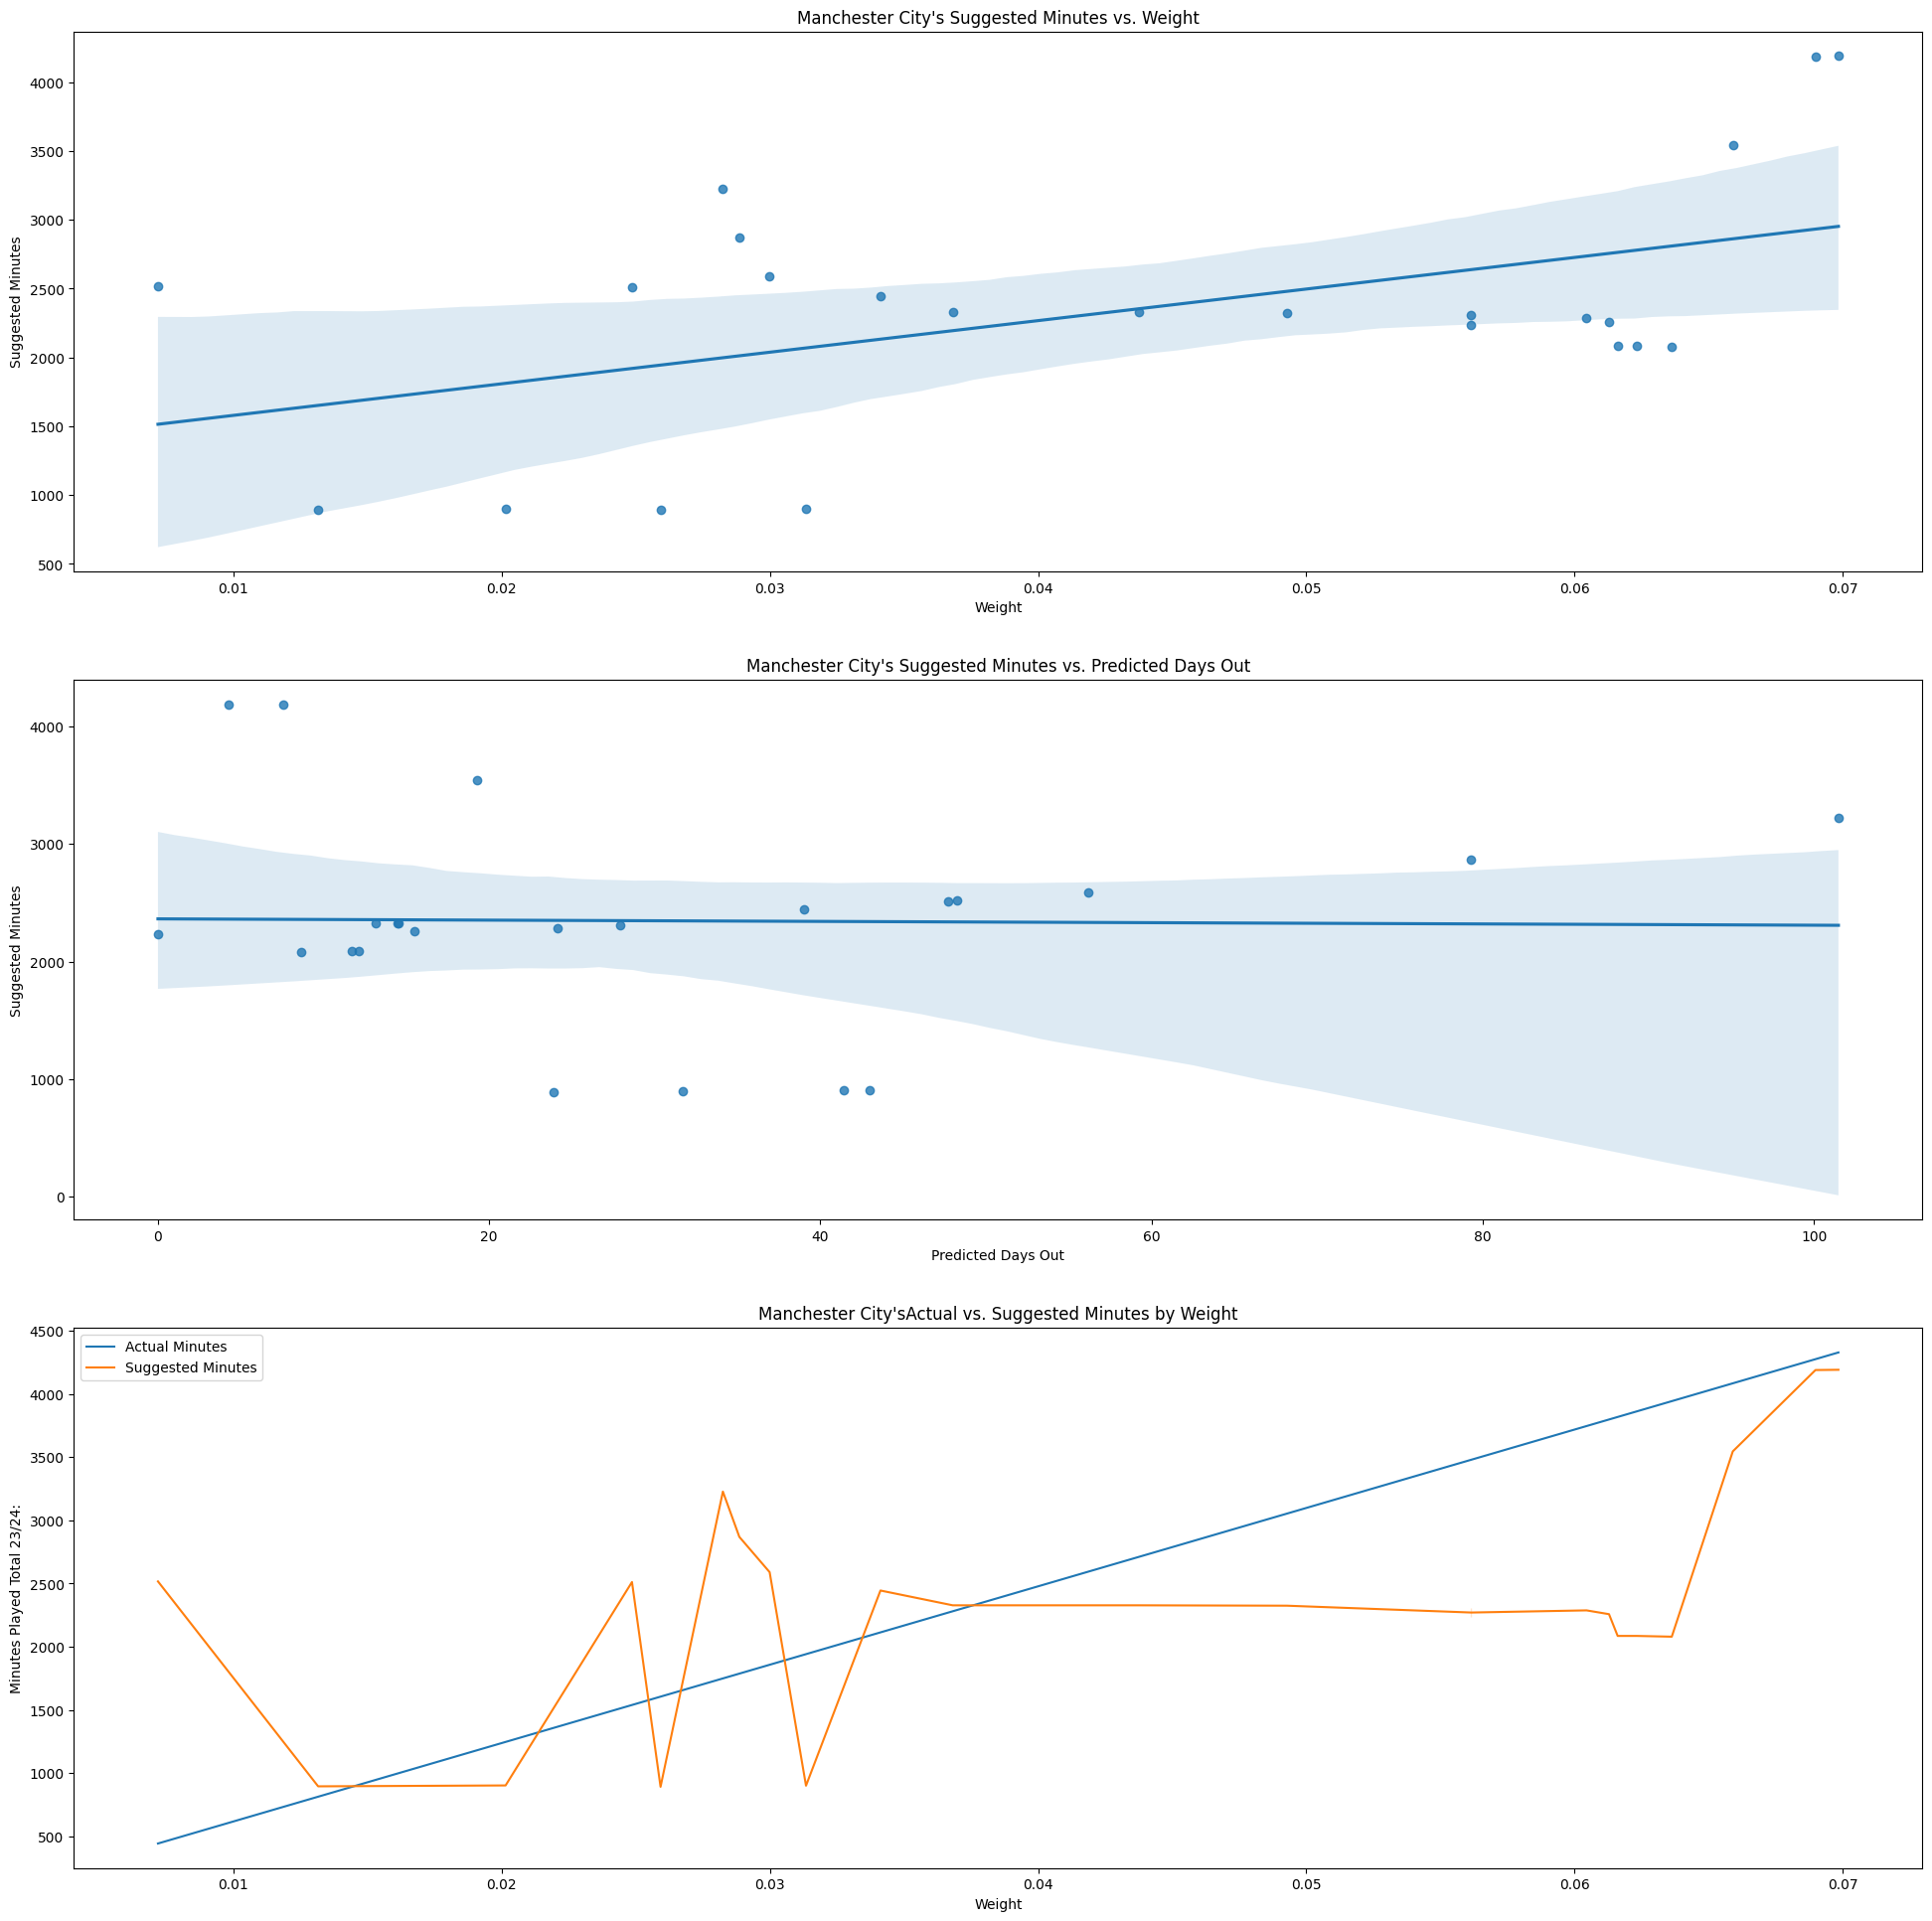

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=man_city_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Manchester City's Suggested Minutes vs. Weight")

sns.regplot(data=man_city_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Manchester City's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=man_city_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=man_city_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Manchester City'sActual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [227]:
man_city_df = optimise('Man City', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.2)
man_city_df

Name      Club  Age  Minutes Played Total 23/24:  \
198             Rúben Dias  Man City   27                         3817   
199          Manuel Akanji  Man City   28                         3861   
200             Nathan Aké  Man City   29                         3053   
201            John Stones  Man City   30                         1858   
202  Taylor Harwood-Bellis  Man City   22                         3942   
203         Josko Gvardiol  Man City   22                         3479   
204           Sergio Gómez  Man City   23                          445   
205    Josh Wilson-Esbrand  Man City   21                         1248   
206             Rico Lewis  Man City   19                         1606   
207            Kyle Walker  Man City   34                         4083   
208            Issa Kaboré  Man City   23                         1788   
209                  Rodri  Man City   27                         4327   
210          Matheus Nunes  Man City   25                         1540   
211          Mateo Kovacic  Man City   30                         2711   
212           James McAtee  Man City   21                         1942   
213         Bernardo Silva  Man City   29                         3797   
214        Kevin De Bruyne  Man City   32                         1750   
215            Jérémy Doku  Man City   22                         2281   
216          Jack Grealish  Man City   28                         2114   
217             Phil Foden  Man City   24                         4274   
218             Oscar Bobb  Man City   20                          815   
219         Erling Haaland  Man City   23                         3745   
220         Julián Álvarez  Man City   24                         3479   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
198  0.061609           11.715614            3524.3     0.2               3351  
199  0.062319           12.118954            3524.3     0.2               3392  
200  0.049278           13.162987            2168.8     0.2               2021  
201  0.029990           56.180477            1355.5     0.2               2169  
202  0.063627            8.670015            3524.3     0.2               3512  
203  0.056154           27.903629            2711.0     0.2               2059  
204  0.007183           48.224480               0.0     0.2               2168  
205  0.020144           41.408318               0.0     0.2               1039  
206  0.025922           23.911762               0.0     0.2               1028  
207  0.065903           19.281223            4337.6     0.2               4742  
208  0.028860           79.272749               0.0     0.2               2173  
209  0.069841            4.260078            4337.6     0.2               3748  
210  0.024857           47.740331               0.0     0.2               2168  
211  0.043758           14.511348            2168.8     0.2               2021  
212  0.031345           42.963722            1355.5     0.2               1040  
213  0.061286           15.459842            2711.0     0.2               2054  
214  0.028246          101.475521               0.0     0.2               2178  
215  0.036817           14.484747            2168.8     0.2               2021  
216  0.034122           39.032298            1355.5     0.2               2167  
217  0.068986            7.540023            4337.6     0.2               3691  
218  0.013155           31.661233               0.0     0.2               1032  
219  0.060447           24.129783            2711.0     0.2               2134  
220  0.056154            0.000000            2711.0     0.2               2091

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

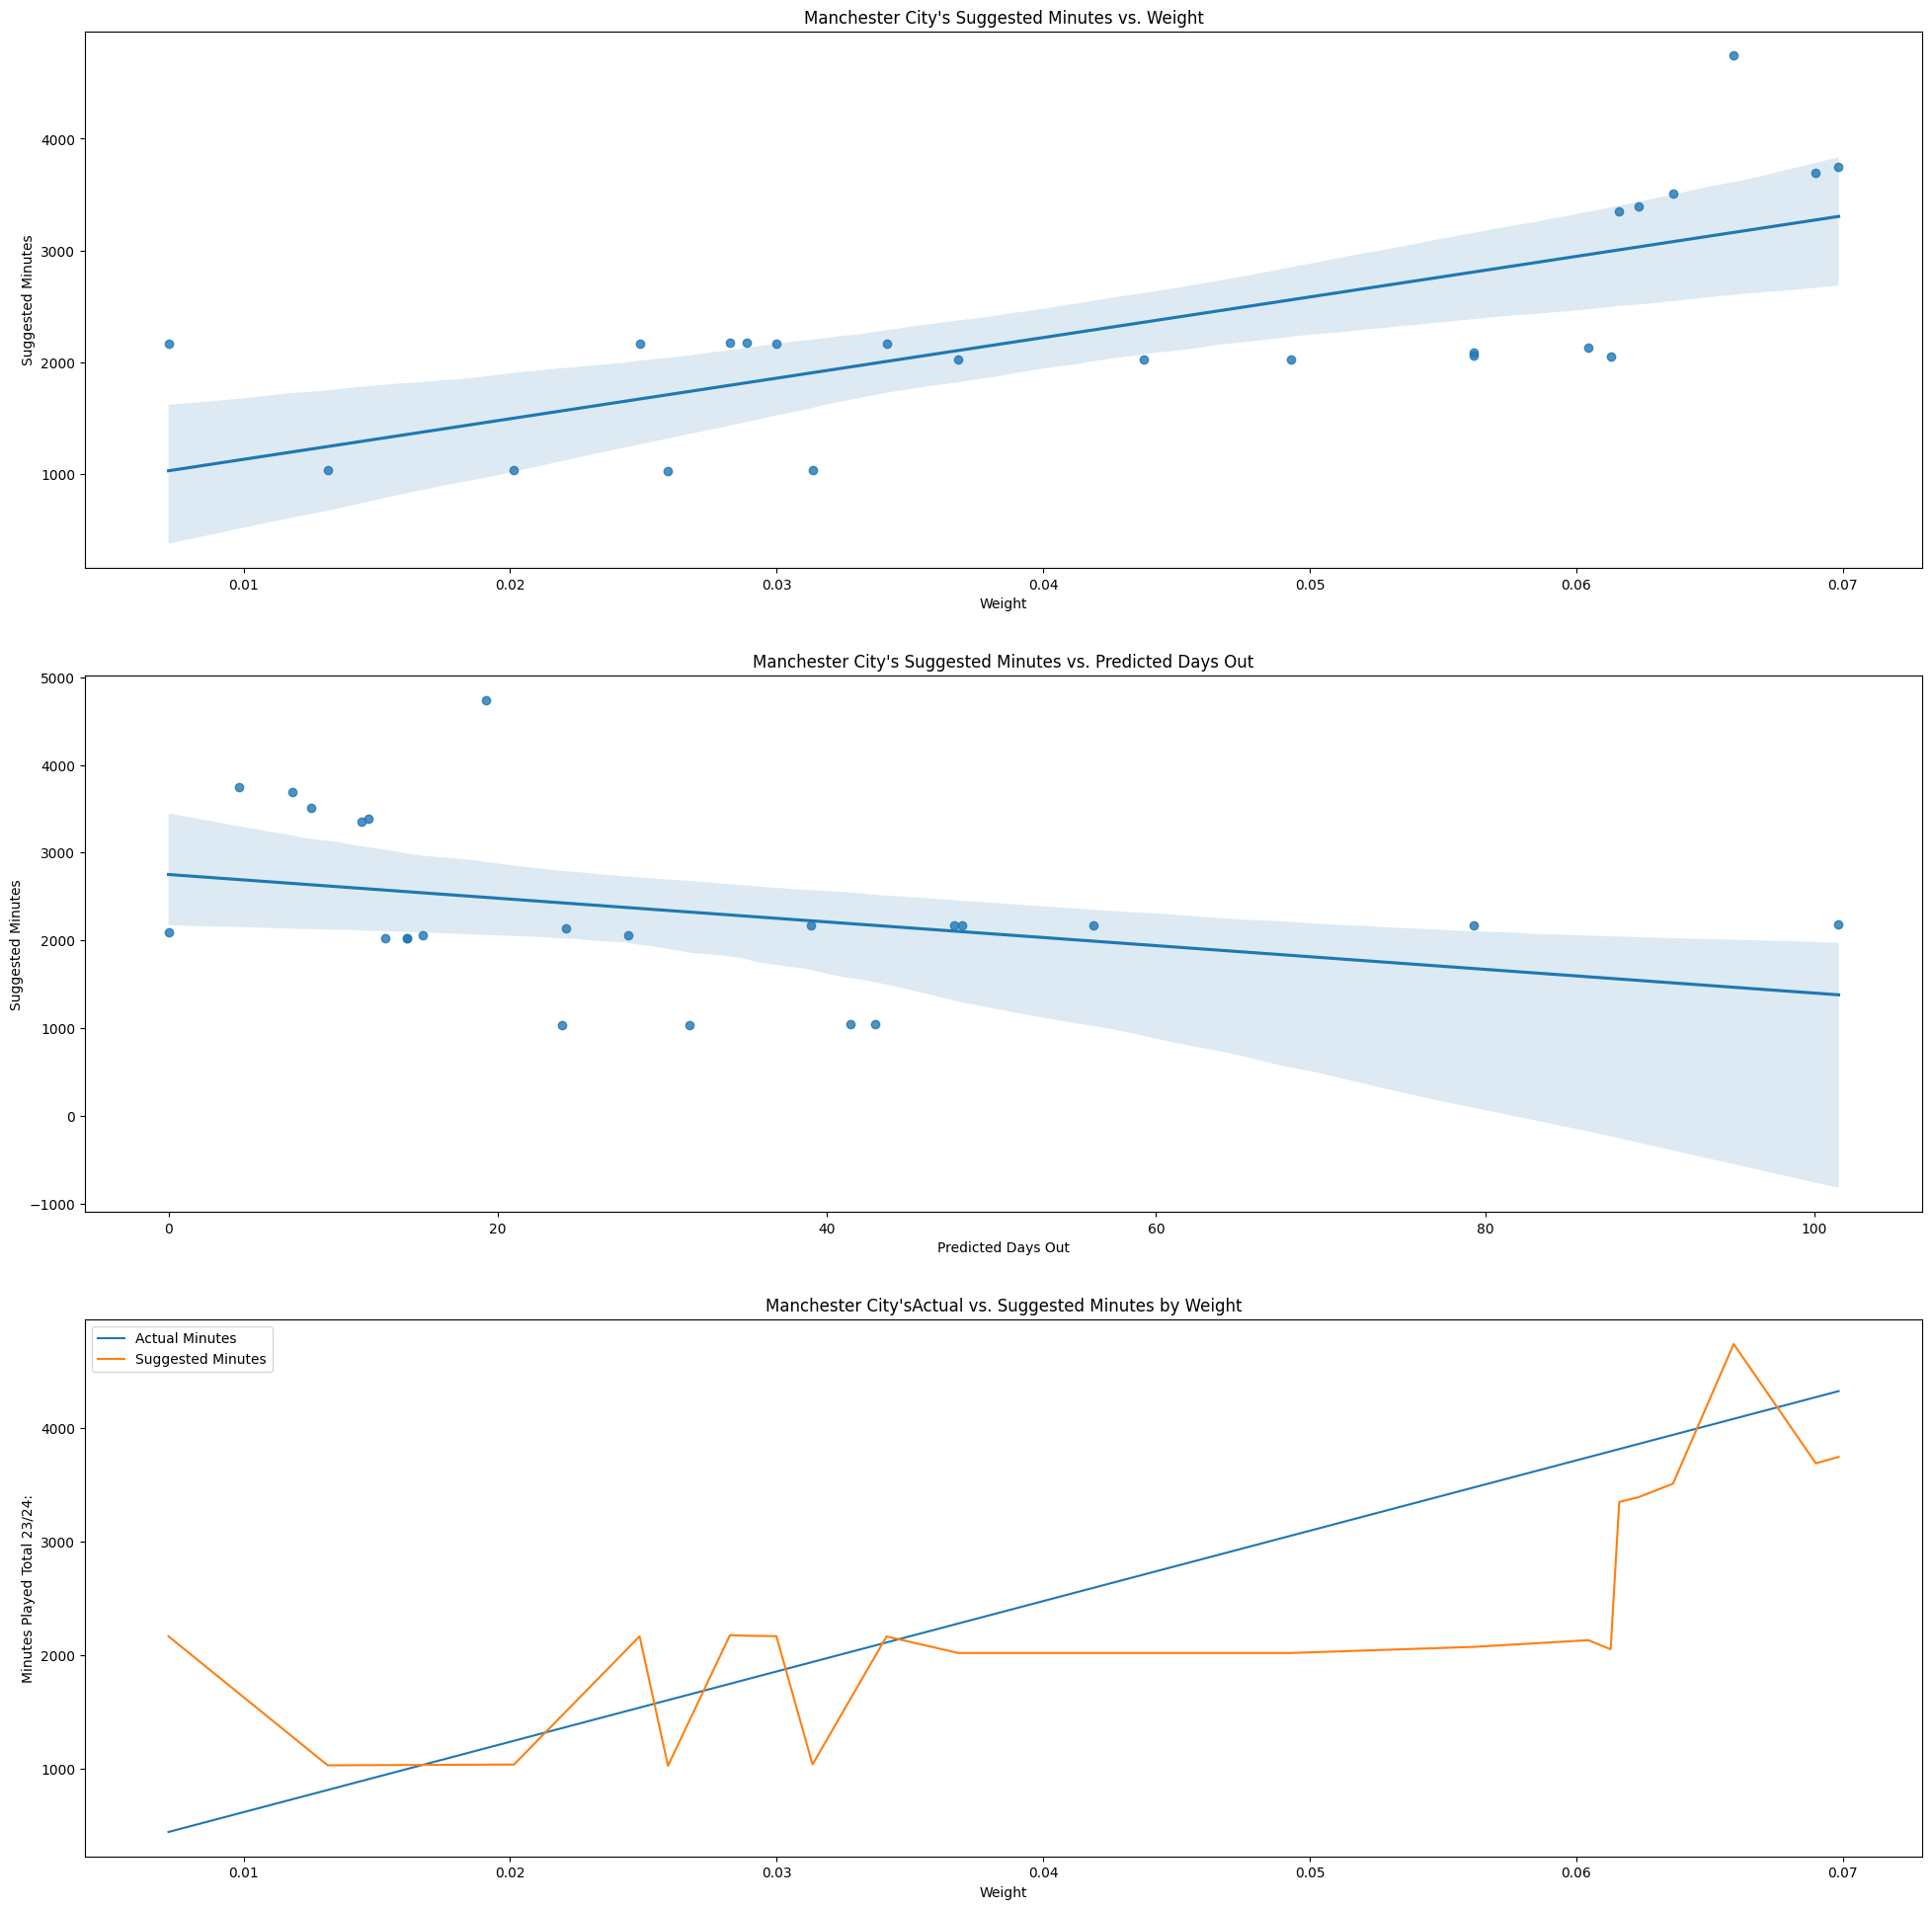

In [166]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=man_city_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Manchester City's Suggested Minutes vs. Weight")

sns.regplot(data=man_city_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Manchester City's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=man_city_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=man_city_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Manchester City'sActual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Sergio Gómez's Suggested Minutes vs. Lambda")

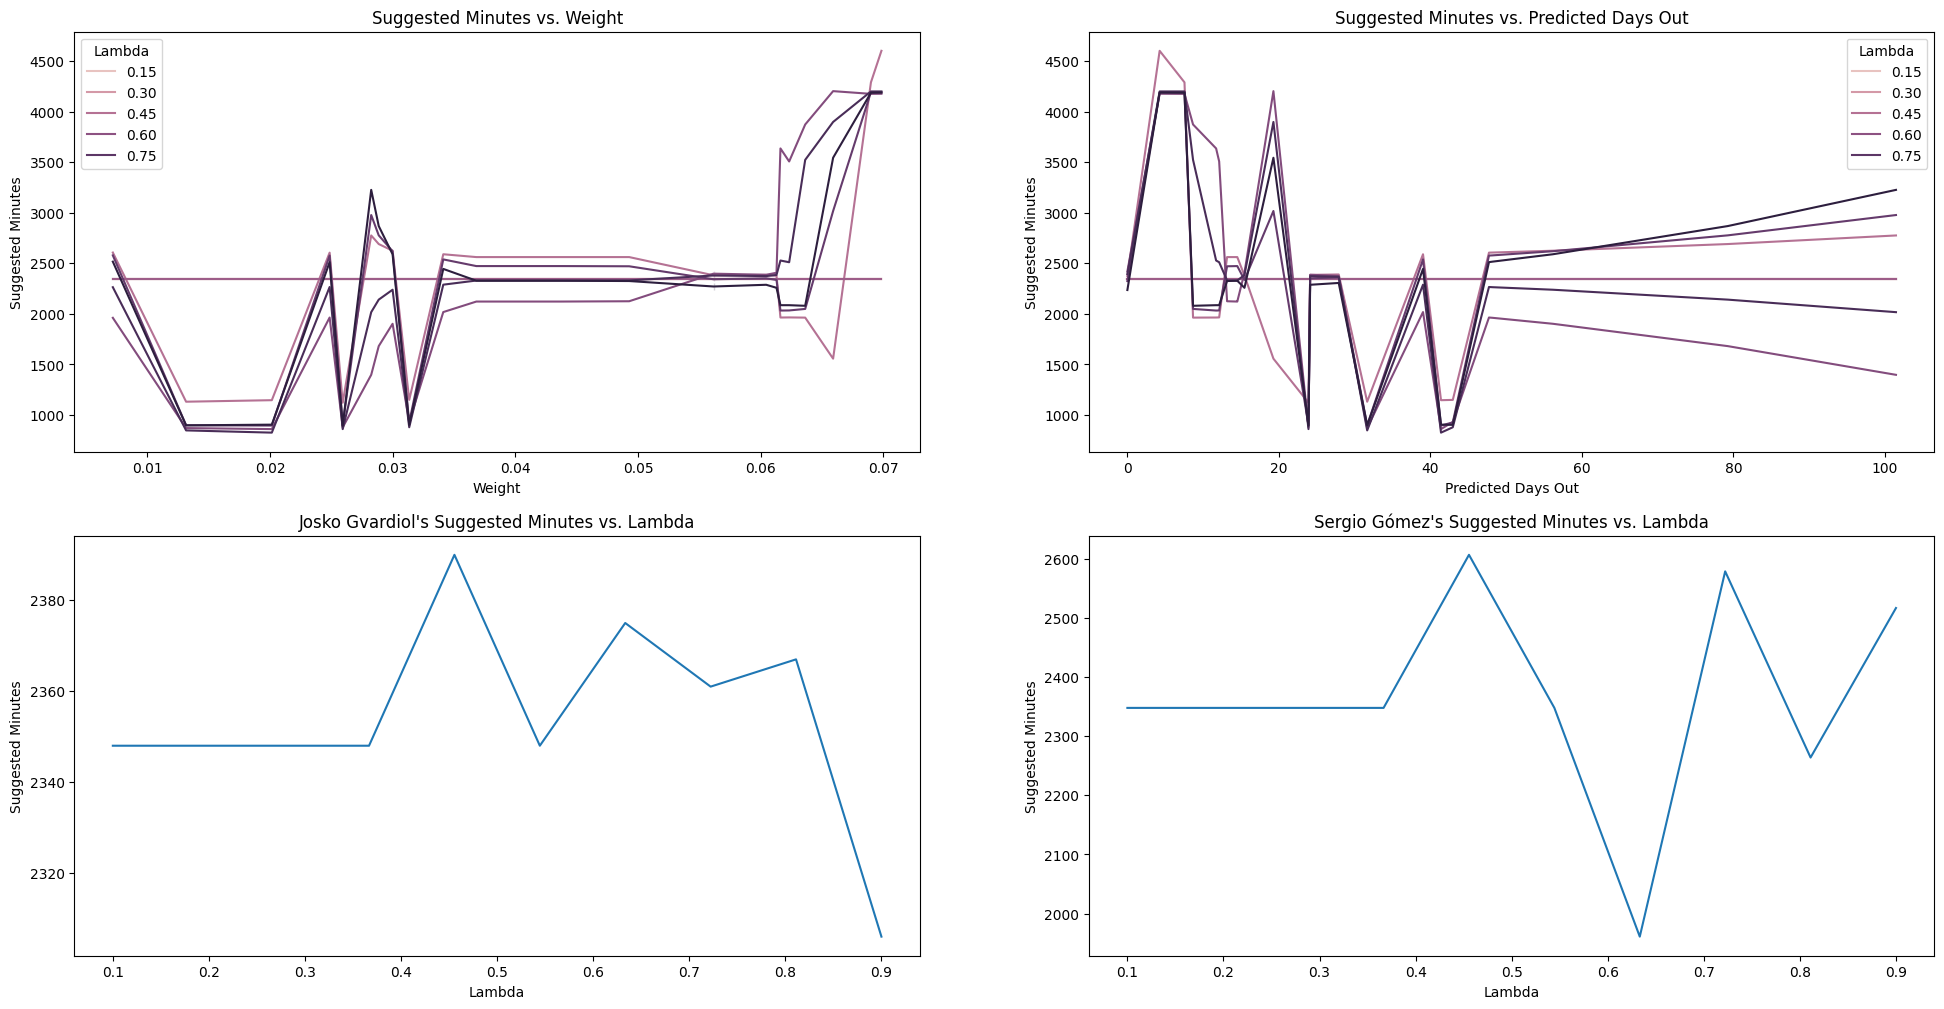

In [233]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Man City', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title('Suggested Minutes vs. Weight')

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title('Suggested Minutes vs. Predicted Days Out')

gvardiol_df = results_df[results_df['Name'] == 'Josko Gvardiol']
sns.lineplot(data=gvardiol_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Josko Gvardiol's Suggested Minutes vs. Lambda")

sergio_df = results_df[results_df['Name'] == 'Sergio Gómez']
sns.lineplot(data=sergio_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Sergio Gómez's Suggested Minutes vs. Lambda")

### Brighton (Mid Table)

In [168]:
brighton_df = optimise('Brighton', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.8)
brighton_df

Name      Club  Age  Minutes Played Total 23/24:    Weight  \
350        Adam Webster  Brighton   29                         1360  0.022310   
351  Jan Paul van Hecke  Brighton   23                         3352  0.054988   
352                Igor  Brighton   26                         2284  0.037468   
353          Lewis Dunk  Brighton   32                         3658  0.060008   
354            Ed Turns  Brighton   21                         2424  0.039764   
355    Pervis Estupiñán  Brighton   26                         1782  0.029233   
356      Valentín Barco  Brighton   19                          315  0.005167   
357       Tariq Lamptey  Brighton   23                         1361  0.022326   
358        Joël Veltman  Brighton   32                         1956  0.032087   
359       Carlos Baleba  Brighton   20                         1540  0.025263   
360       Billy Gilmour  Brighton   22                         2925  0.047983   
361    Jack Hinshelwood  Brighton   19                         1666  0.027330   
362         Jakub Moder  Brighton   25                          808  0.013255   
363         Pascal Groß  Brighton   32                         4104  0.067324   
364         Yasin Ayari  Brighton   20                         1023  0.016782   
365        James Milner  Brighton   38                          955  0.015666   
366        Marc Leonard  Brighton   22                         4344  0.071261   
367         Jensen Weir  Brighton   22                         1725  0.028298   
368        Julio Enciso  Brighton   20                          590  0.009679   
369  Facundo Buonanotte  Brighton   19                         1860  0.030512   
370        Andrew Moran  Brighton   20                         2589  0.042471   
371        Adam Lallana  Brighton   36                          951  0.015601   
372        Kaoru Mitoma  Brighton   27                         2064  0.033859   
373           Ansu Fati  Brighton   21                         1037  0.017011   
374    Jeremy Sarmiento  Brighton   21                         1470  0.024115   
375       Simon Adingra  Brighton   22                         2851  0.046769   
376         Solly March  Brighton   29                          770  0.012631   
377       Abdallah Sima  Brighton   22                         2642  0.043341   
378       Evan Ferguson  Brighton   19                         1720  0.028216   
379          João Pedro  Brighton   22                         2744  0.045014   
380       Danny Welbeck  Brighton   33                         2089  0.034269   

     Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
350           90.331617               0.0     0.8               1300  
351           28.319009            2851.2     0.8               3927  
352           30.341437            1782.0     0.8               1962  
353           25.941292            2851.2     0.8               2852  
354           41.009800            1782.0     0.8               1416  
355          108.209049            1425.6     0.8               1043  
356           55.572379               0.0     0.8               1221  
357           54.140801             891.0     0.8               1782  
358           45.477262            1425.6     0.8               1862  
359            1.405206             891.0     0.8               1434  
360           12.135381            2316.6     0.8               3848  
361           81.701664             891.0     0.8                977  
362           40.314118               0.0     0.8               1902  
363           12.942845            2851.2     0.8               2907  
364           20.674368               0.0     0.8               1403  
365           94.749782               0.0     0.8                819  
366           11.627335            2851.2     0.8               2910  
367           41.132645            1425.6     0.8               1897  
368           83.173095               0.0     0.8                960  
369   

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

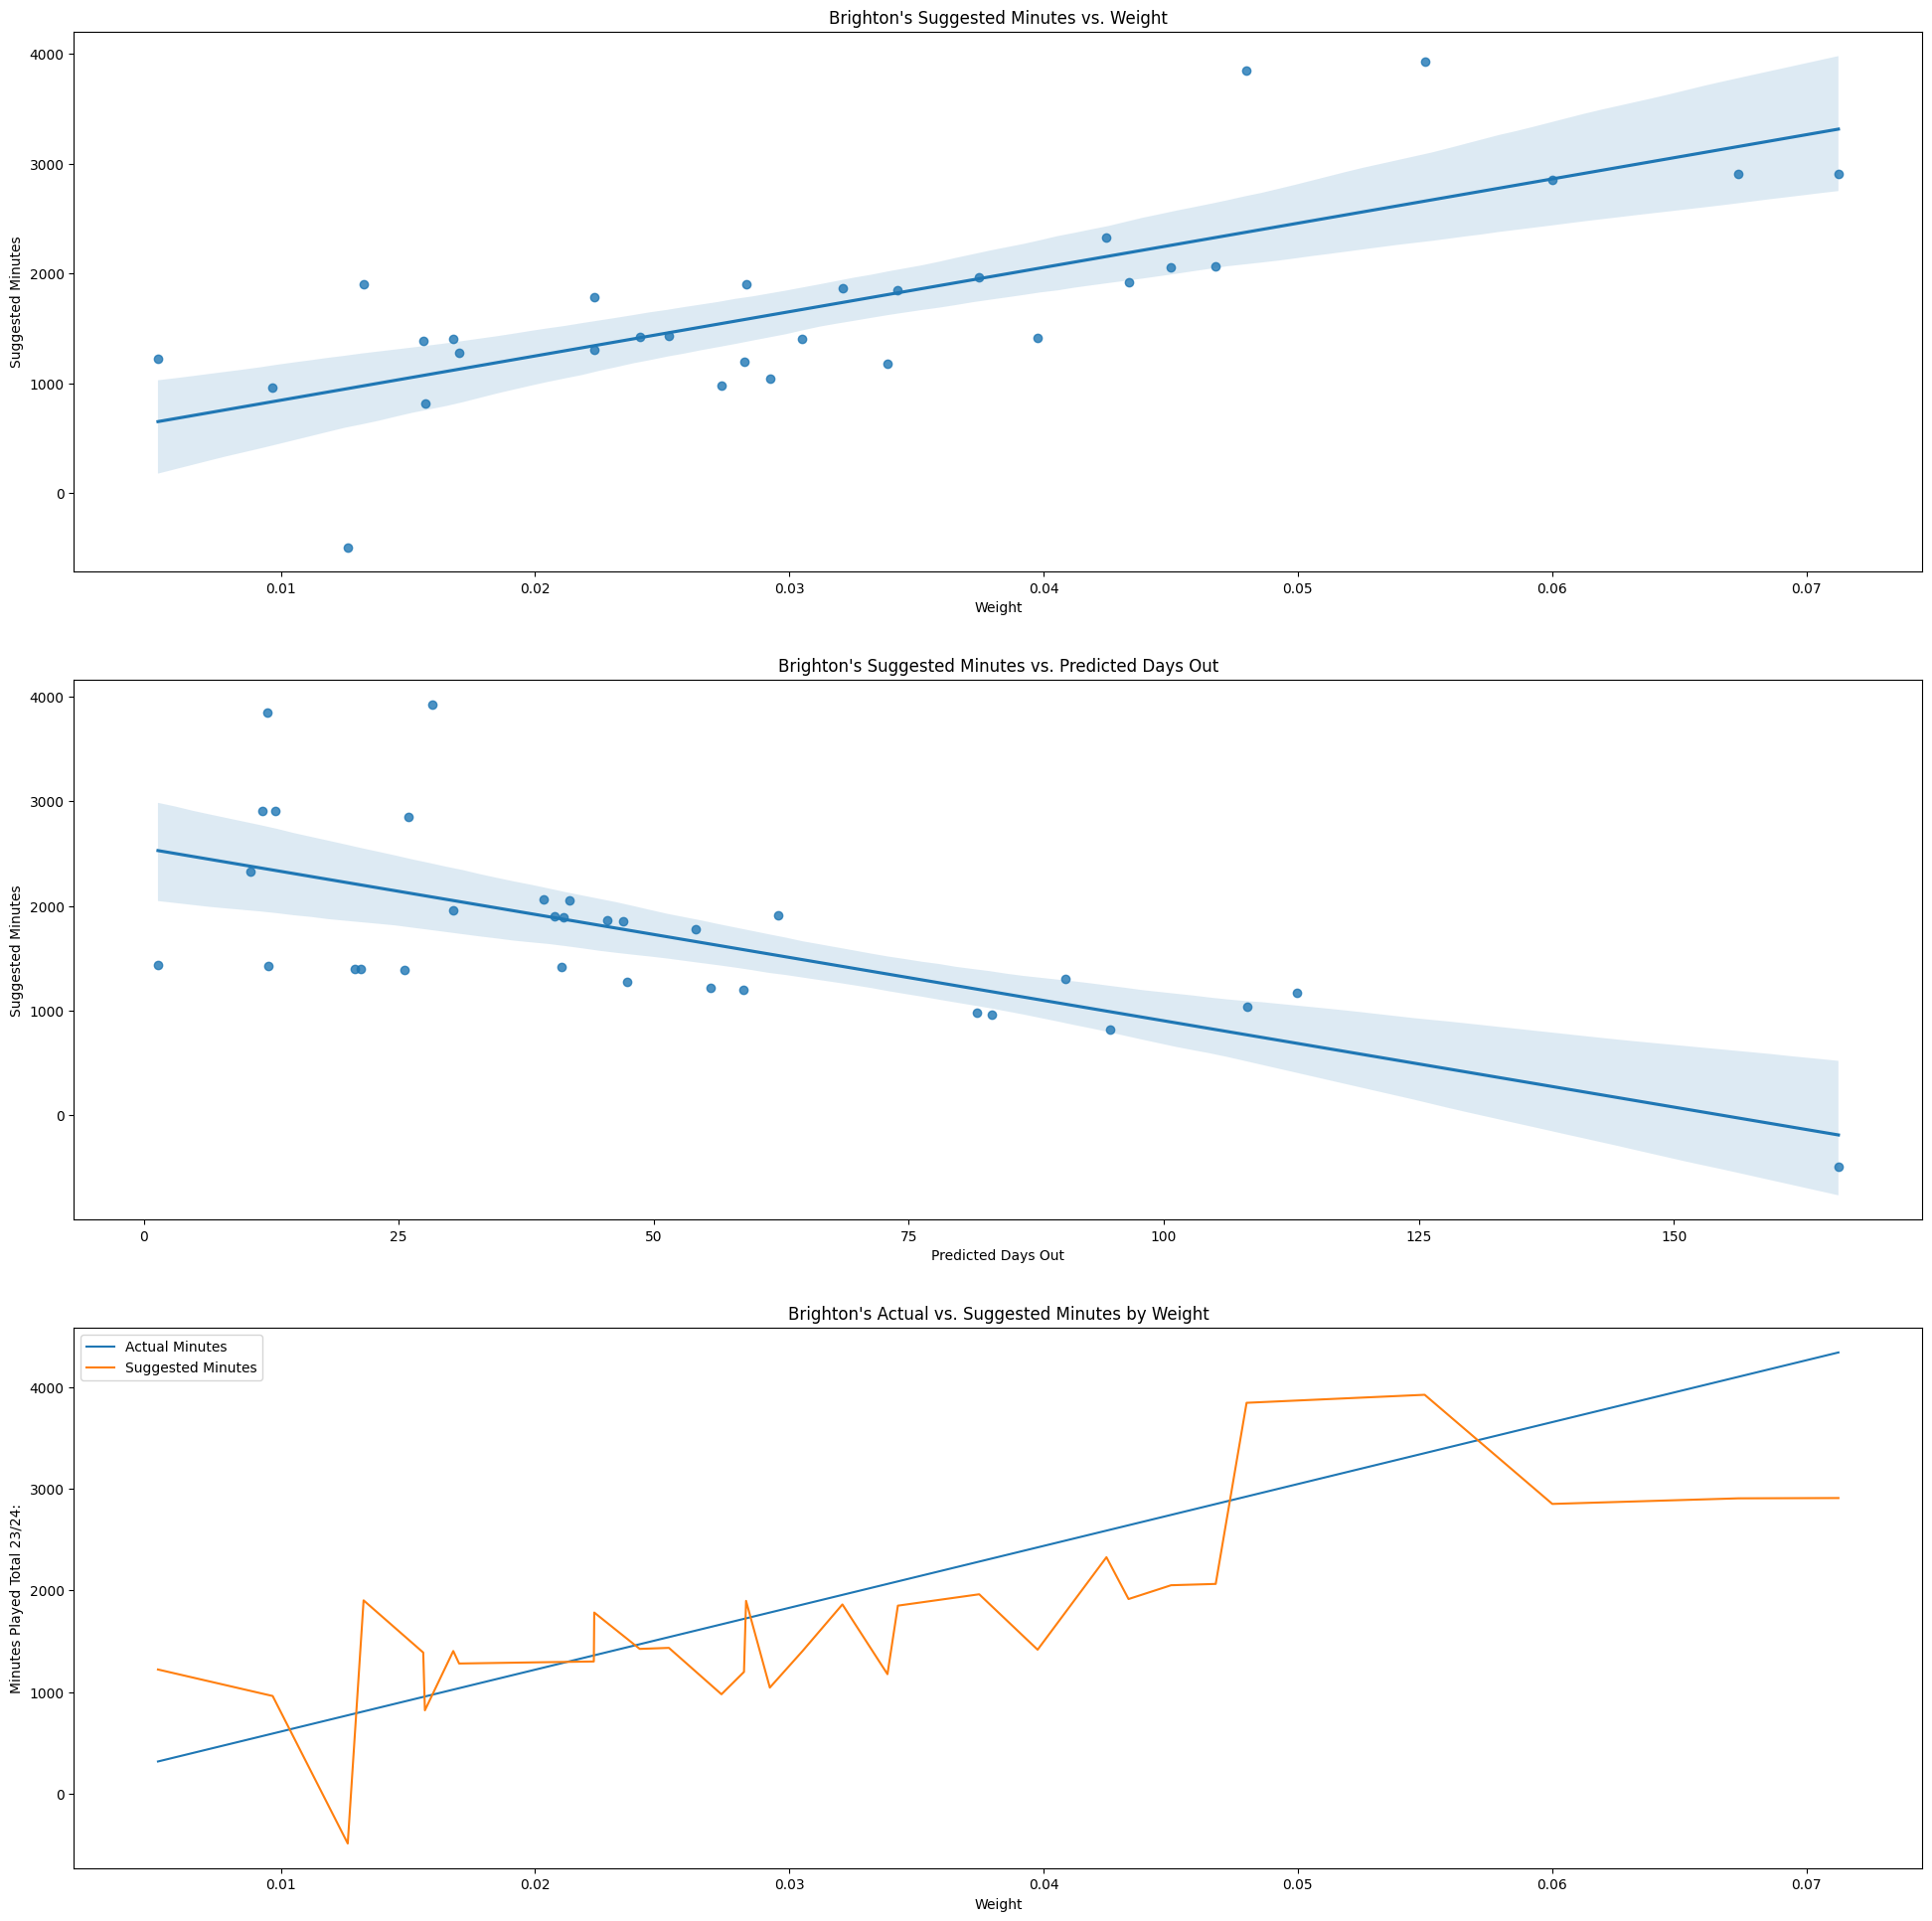

In [169]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=brighton_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Brighton's Suggested Minutes vs. Weight")

sns.regplot(data=brighton_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Brighton's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=brighton_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=brighton_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Brighton's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [170]:
brighton_df = optimise('Brighton', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.2)
brighton_df

Name      Club  Age  Minutes Played Total 23/24:    Weight  \
350        Adam Webster  Brighton   29                         1360  0.022310   
351  Jan Paul van Hecke  Brighton   23                         3352  0.054988   
352                Igor  Brighton   26                         2284  0.037468   
353          Lewis Dunk  Brighton   32                         3658  0.060008   
354            Ed Turns  Brighton   21                         2424  0.039764   
355    Pervis Estupiñán  Brighton   26                         1782  0.029233   
356      Valentín Barco  Brighton   19                          315  0.005167   
357       Tariq Lamptey  Brighton   23                         1361  0.022326   
358        Joël Veltman  Brighton   32                         1956  0.032087   
359       Carlos Baleba  Brighton   20                         1540  0.025263   
360       Billy Gilmour  Brighton   22                         2925  0.047983   
361    Jack Hinshelwood  Brighton   19                         1666  0.027330   
362         Jakub Moder  Brighton   25                          808  0.013255   
363         Pascal Groß  Brighton   32                         4104  0.067324   
364         Yasin Ayari  Brighton   20                         1023  0.016782   
365        James Milner  Brighton   38                          955  0.015666   
366        Marc Leonard  Brighton   22                         4344  0.071261   
367         Jensen Weir  Brighton   22                         1725  0.028298   
368        Julio Enciso  Brighton   20                          590  0.009679   
369  Facundo Buonanotte  Brighton   19                         1860  0.030512   
370        Andrew Moran  Brighton   20                         2589  0.042471   
371        Adam Lallana  Brighton   36                          951  0.015601   
372        Kaoru Mitoma  Brighton   27                         2064  0.033859   
373           Ansu Fati  Brighton   21                         1037  0.017011   
374    Jeremy Sarmiento  Brighton   21                         1470  0.024115   
375       Simon Adingra  Brighton   22                         2851  0.046769   
376         Solly March  Brighton   29                          770  0.012631   
377       Abdallah Sima  Brighton   22                         2642  0.043341   
378       Evan Ferguson  Brighton   19                         1720  0.028216   
379          João Pedro  Brighton   22                         2744  0.045014   
380       Danny Welbeck  Brighton   33                         2089  0.034269   

     Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
350           90.331617               0.0     0.2               1590  
351           28.319009            2851.2     0.2               2657  
352           30.341437            1782.0     0.2               1611  
353           25.941292            2851.2     0.2               3567  
354           41.009800            1782.0     0.2               1489  
355          108.209049            1425.6     0.2               1574  
356           55.572379               0.0     0.2                915  
357           54.140801             891.0     0.2               1612  
358           45.477262            1425.6     0.2               1615  
359            1.405206             891.0     0.2                917  
360           12.135381            2316.6     0.2               3524  
361           81.701664             891.0     0.2                911  
362           40.314118               0.0     0.2               1617  
363           12.942845            2851.2     0.2               3741  
364           20.674368               0.0     0.2                917  
365           94.749782               0.0     0.2                906  
366           11.627335            2851.2     0.2               3741  
367           41.132645            1425.6     0.2               1617  
368           83.173095               0.0     0.2                910  
369   

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

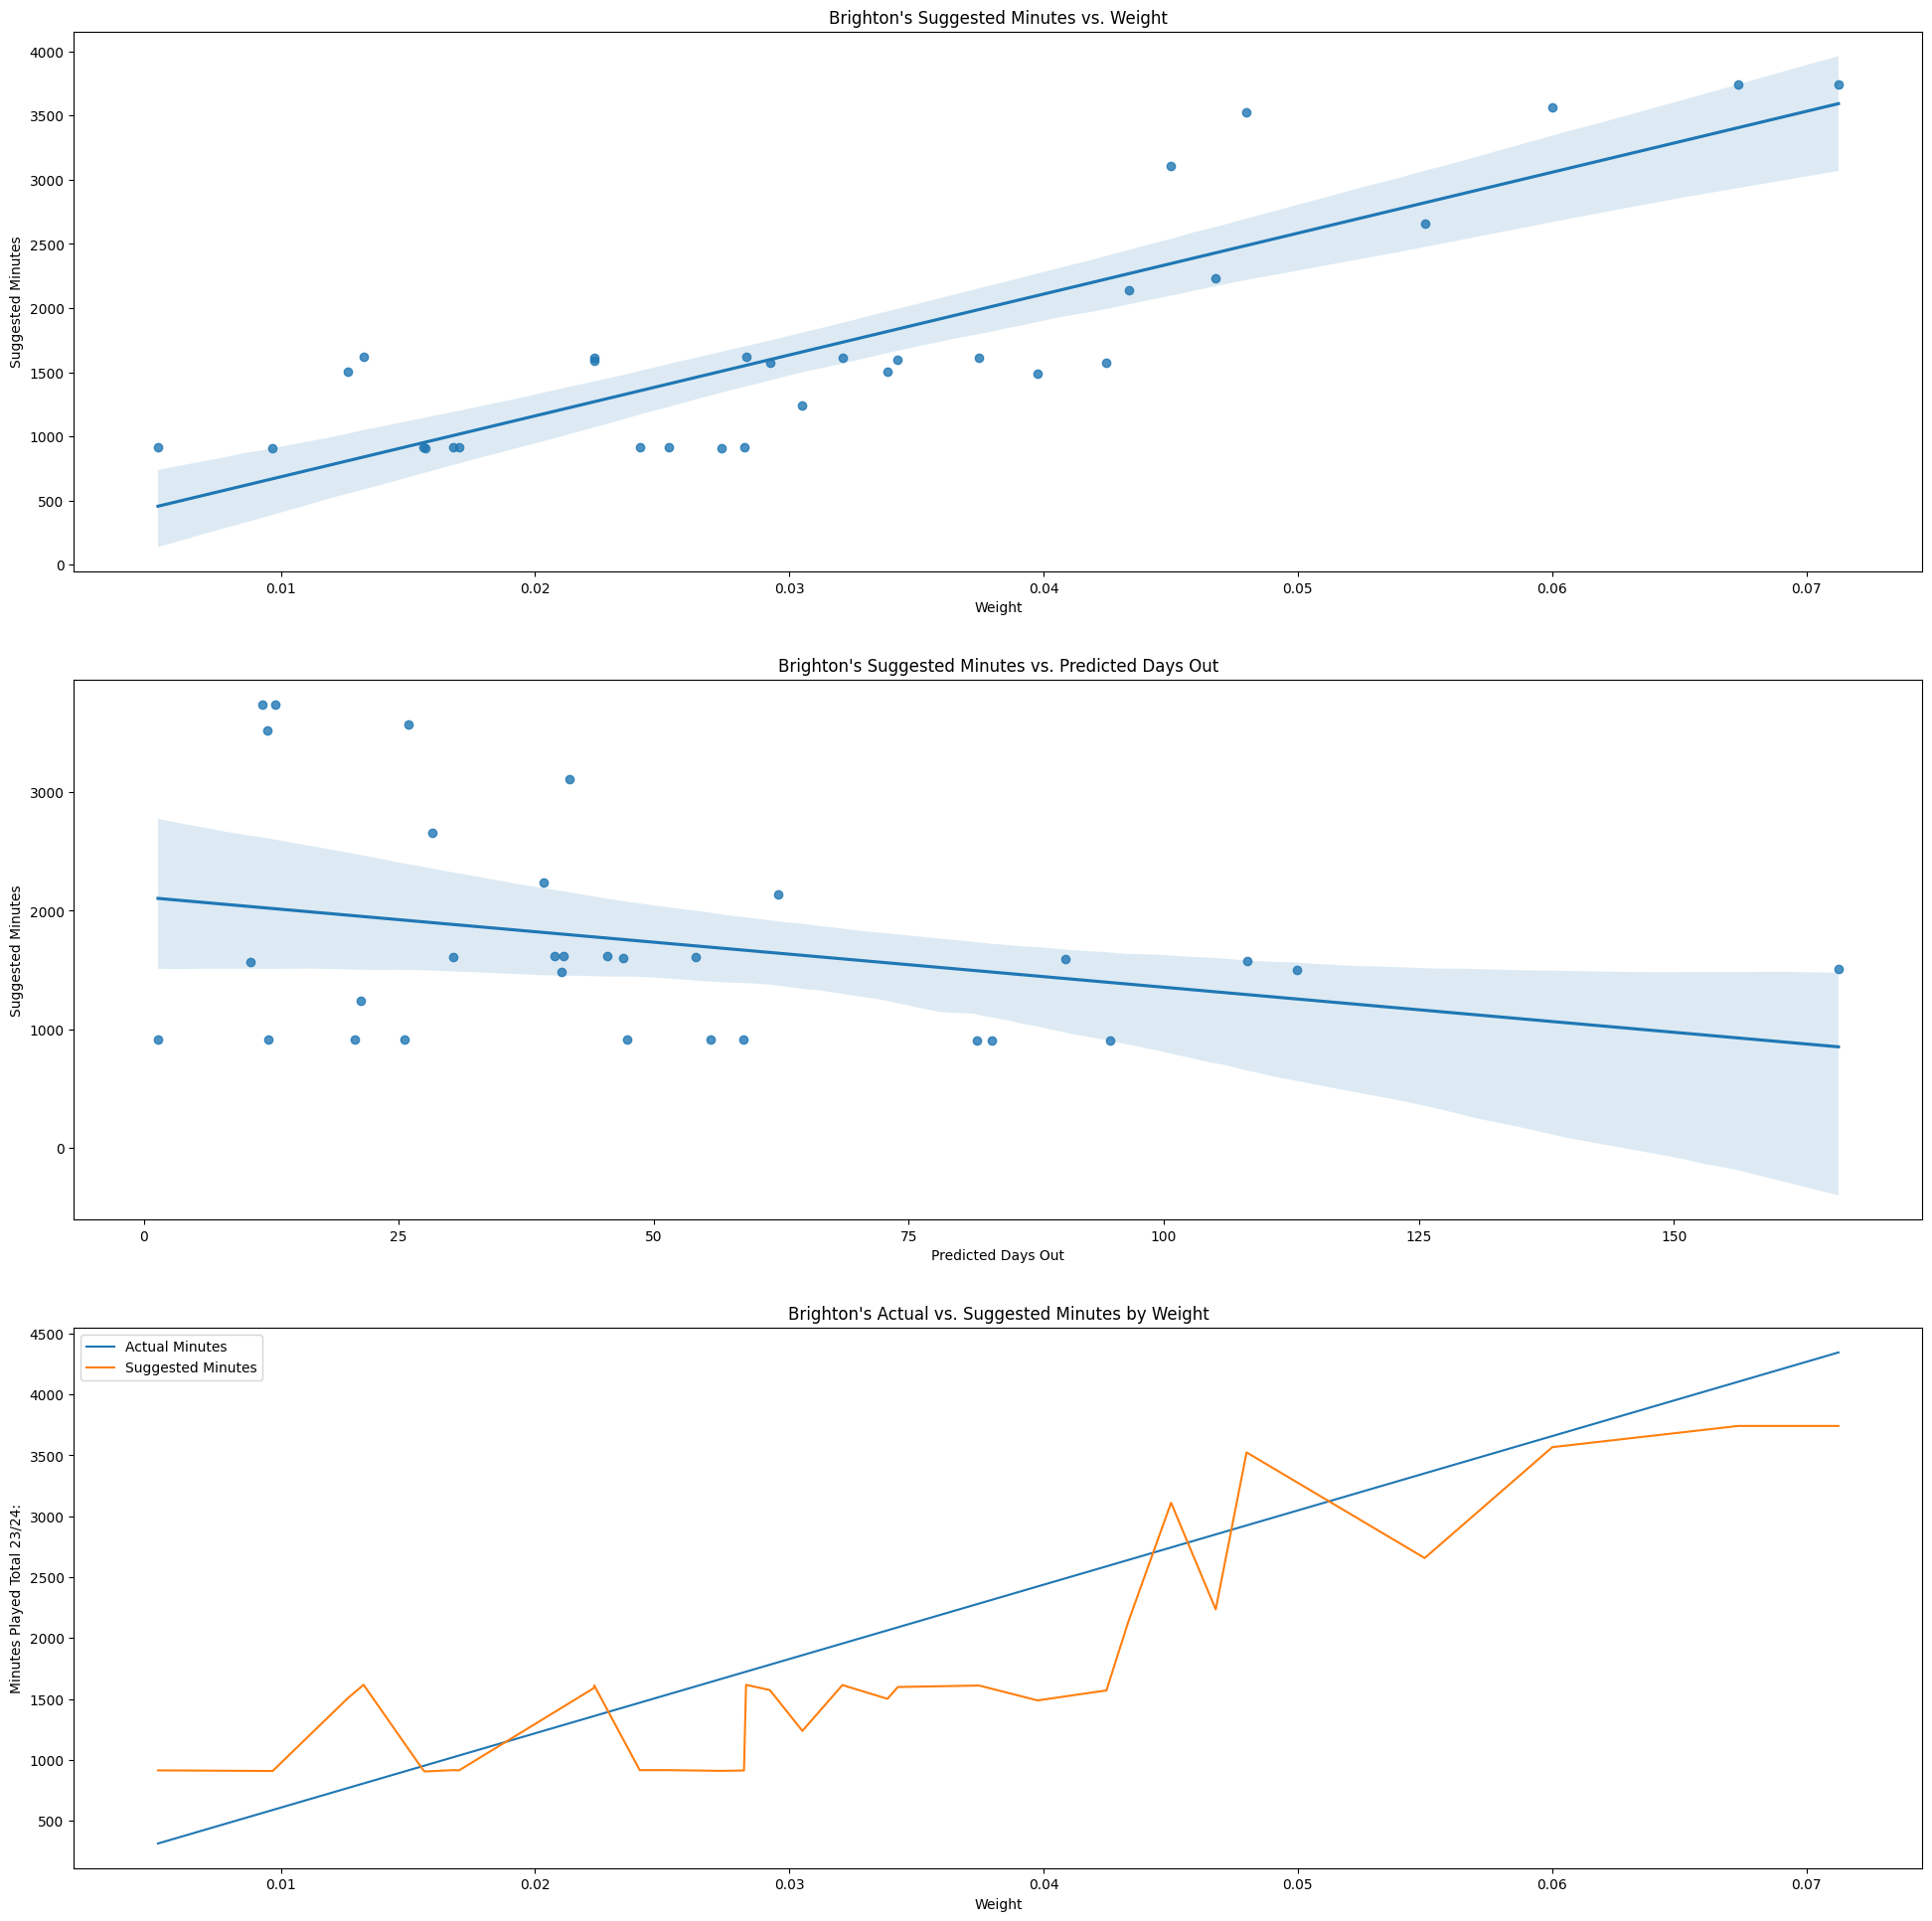

In [171]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=brighton_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Brighton's Suggested Minutes vs. Weight")

sns.regplot(data=brighton_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Brighton's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=brighton_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=brighton_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Brighton's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Solly March's Suggested Minutes vs. Lambda")

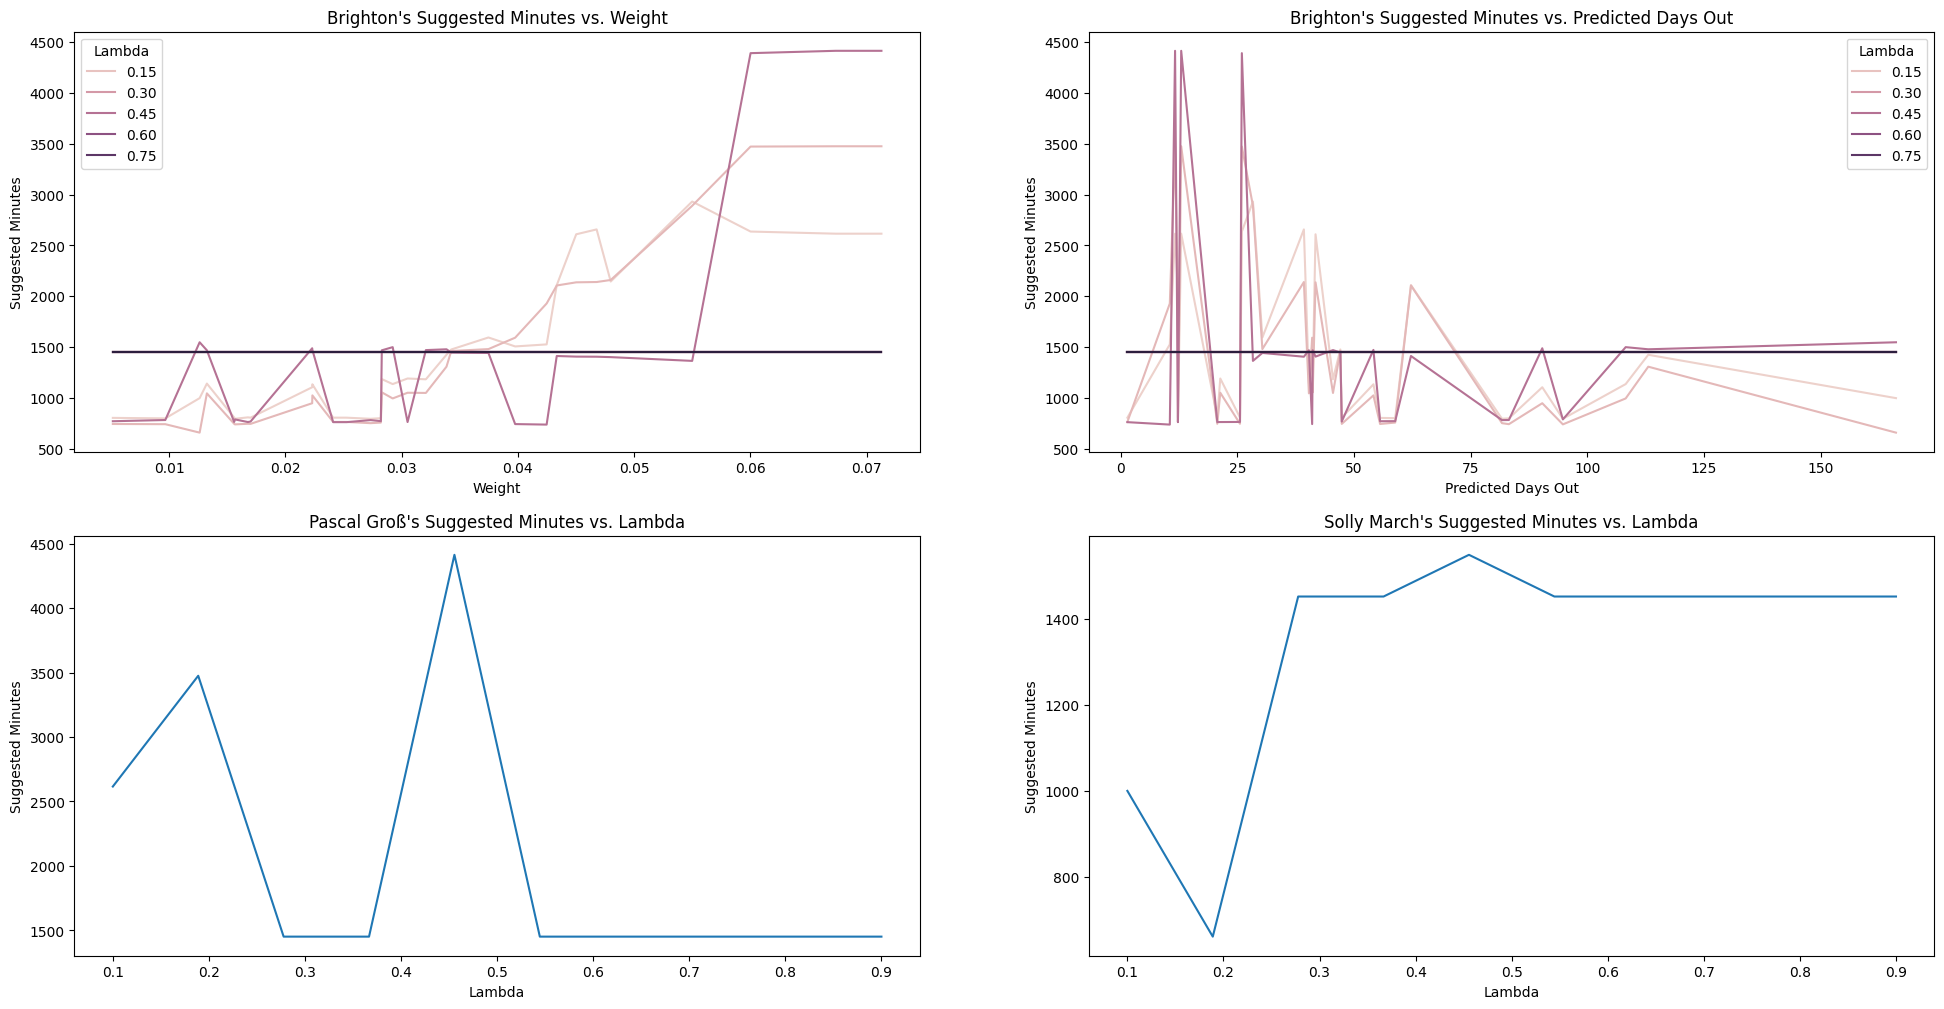

In [172]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Brighton', total_days_out_mse_prediction_df, games_per_season=50, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Brighton's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Brighton's Suggested Minutes vs. Predicted Days Out")

gros_df = results_df[results_df['Name'] == 'Pascal Groß']
sns.lineplot(data=gros_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Pascal Groß's Suggested Minutes vs. Lambda")

march_df = results_df[results_df['Name'] == 'Solly March']
sns.lineplot(data=march_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Solly March's Suggested Minutes vs. Lambda")

### Sheffield United (Bottom)

In [173]:
sheff_df = optimise('Sheff Utd', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=0.8)
sheff_df

Name       Club  Age  Minutes Played Total 23/24:  \
293        Anel Ahmedhodzic  Sheff Utd   25                         2739   
294           Auston Trusty  Sheff Utd   25                         2752   
295               John Egan  Sheff Utd   31                          574   
296           Jack Robinson  Sheff Utd   30                         2976   
297            Chris Basham  Sheff Utd   35                          408   
298          Yasser Larouci  Sheff Utd   23                          629   
299                Max Lowe  Sheff Utd   27                          499   
300  Rhys Norrington-Davies  Sheff Utd   25                          251   
301            Jayden Bogle  Sheff Utd   23                         2946   
302          George Baldock  Sheff Utd   31                          969   
303             Femi Seriki  Sheff Utd   22                          360   
304              Vini Souza  Sheff Utd   24                         2696   
305           Gustavo Hamer  Sheff Utd   26                         3217   
306              Tom Davies  Sheff Utd   25                          214   
307            Anis Slimane  Sheff Utd   23                          411   
308            Andre Brooks  Sheff Utd   20                         1088   
309          Oliver Norwood  Sheff Utd   33                         1703   
310              Ben Osborn  Sheff Utd   29                         1430   
311        Oliver Arblaster  Sheff Utd   20                         2850   
312       Ben Brereton Díaz  Sheff Utd   25                         1759   
313          Cameron Archer  Sheff Utd   22                         2065   
314            Oli McBurnie  Sheff Utd   27                         1354   
315          Rhian Brewster  Sheff Utd   24                          358   
316           William Osula  Sheff Utd   20                          943   
317         Daniel Jebbison  Sheff Utd   20                           20   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
293  0.077788           16.574005            1414.4     0.8               1461  
294  0.078157            6.146398            1414.4     0.8               1466  
295  0.016302          131.780905             544.0     0.8               1131  
296  0.084519            7.161556            1740.8     0.8               2125  
297  0.011587           74.240789               0.0     0.8               1360  
298  0.017864           14.656405             544.0     0.8               1462  
299  0.014172           32.914369               0.0     0.8               1445  
300  0.007128           50.033798               0.0     0.8               1418  
301  0.083667            0.000000            1740.8     0.8               1713  
302  0.027520           36.415216             870.4     0.8               1441  
303  0.010224           20.474682               0.0     0.8               1458  
304  0.076567            0.000000            1414.4     0.8               1466  
305  0.091363            0.000000            1740.8     0.8               1713  
306  0.006078           69.063339               0.0     0.8               1374  
307  0.011672           36.641268               0.0     0.8               1440  
308  0.030899            4.425573             870.4     0.8               1132  
309  0.048366            1.746051            1088.0     0.8               1466  
310  0.040612            7.761583             870.4     0.8               1465  
311  0.080941            0.000000            1414.4     0.8               1372  
312  0.049956            0.000000            1088.0     0.8               1466  
313  0.058646            3.308637            1088.0     0.8               1466  
314  0.038454           15.935488             870.4     0.8               1461  
315  0.010167           17.855917               0.0     0.8               1460  
316  0.026781            6.153313             544.0     0.8               1132  
317  0.000568        

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

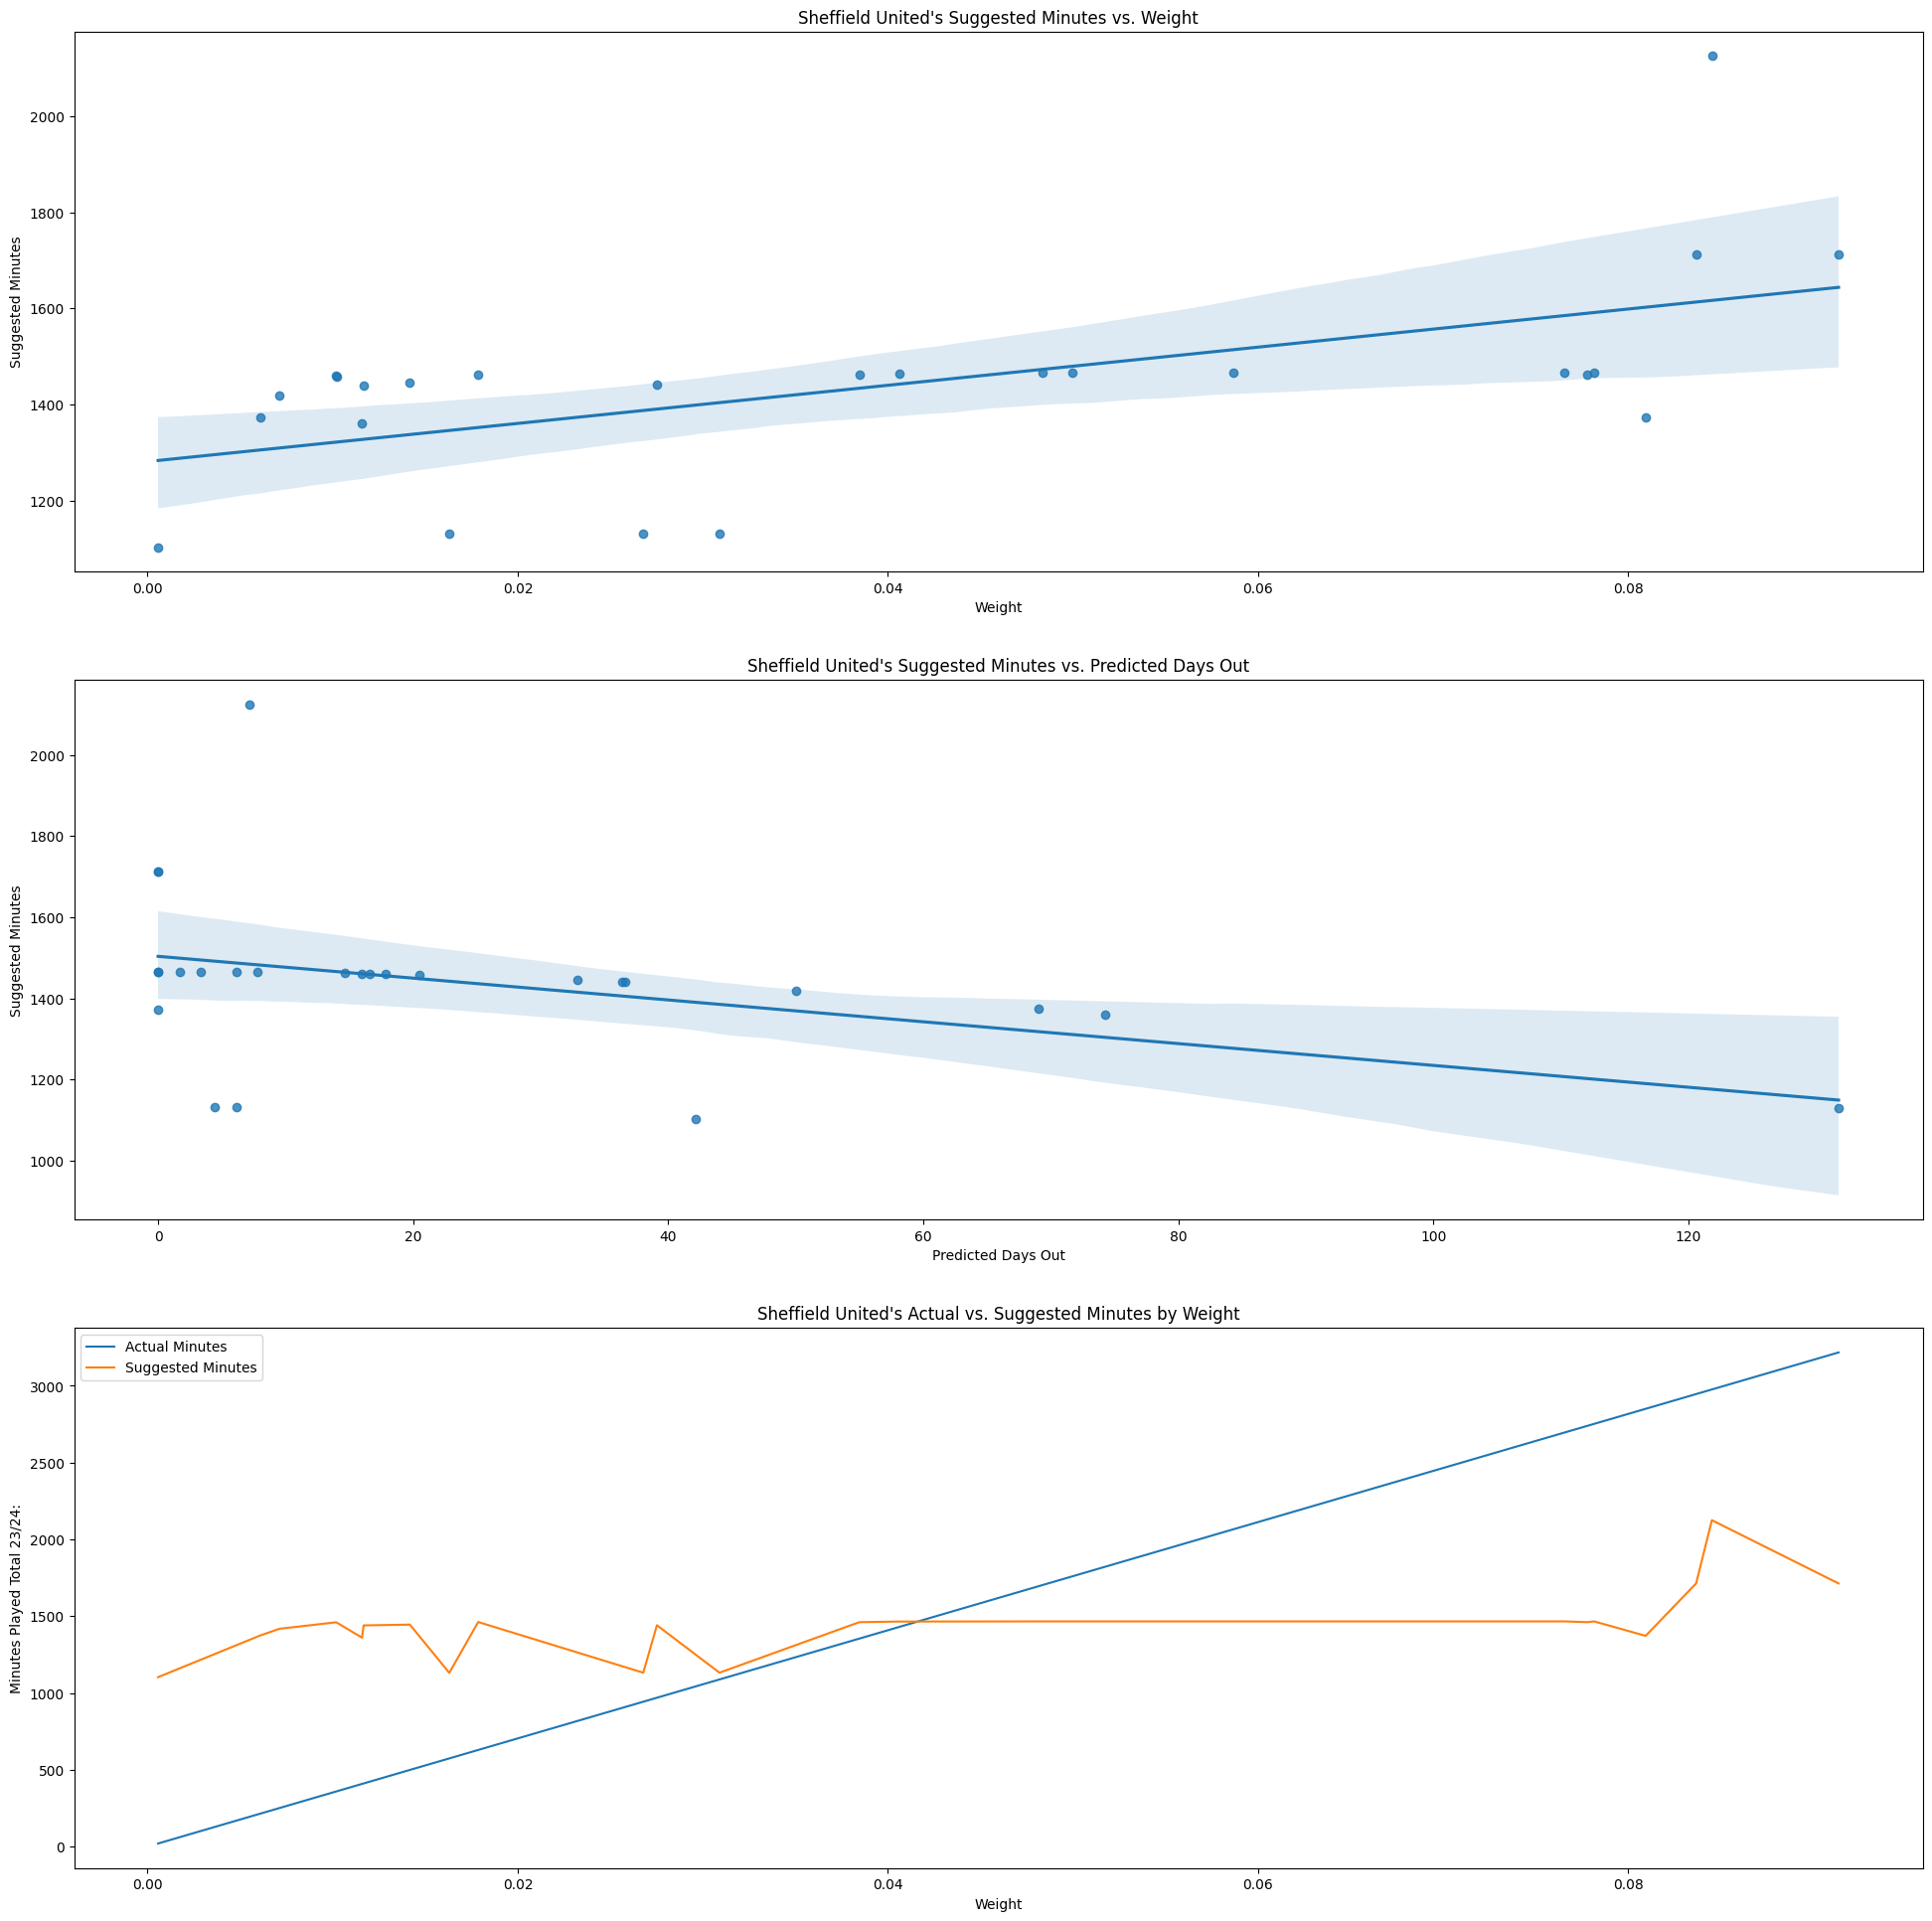

In [174]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=sheff_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Sheffield United's Suggested Minutes vs. Weight")

sns.regplot(data=sheff_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Sheffield United's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=sheff_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=sheff_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Sheffield United's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [175]:
sheff_df = optimise('Sheff Utd', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=0.2)
sheff_df

Name       Club  Age  Minutes Played Total 23/24:  \
293        Anel Ahmedhodzic  Sheff Utd   25                         2739   
294           Auston Trusty  Sheff Utd   25                         2752   
295               John Egan  Sheff Utd   31                          574   
296           Jack Robinson  Sheff Utd   30                         2976   
297            Chris Basham  Sheff Utd   35                          408   
298          Yasser Larouci  Sheff Utd   23                          629   
299                Max Lowe  Sheff Utd   27                          499   
300  Rhys Norrington-Davies  Sheff Utd   25                          251   
301            Jayden Bogle  Sheff Utd   23                         2946   
302          George Baldock  Sheff Utd   31                          969   
303             Femi Seriki  Sheff Utd   22                          360   
304              Vini Souza  Sheff Utd   24                         2696   
305           Gustavo Hamer  Sheff Utd   26                         3217   
306              Tom Davies  Sheff Utd   25                          214   
307            Anis Slimane  Sheff Utd   23                          411   
308            Andre Brooks  Sheff Utd   20                         1088   
309          Oliver Norwood  Sheff Utd   33                         1703   
310              Ben Osborn  Sheff Utd   29                         1430   
311        Oliver Arblaster  Sheff Utd   20                         2850   
312       Ben Brereton Díaz  Sheff Utd   25                         1759   
313          Cameron Archer  Sheff Utd   22                         2065   
314            Oli McBurnie  Sheff Utd   27                         1354   
315          Rhian Brewster  Sheff Utd   24                          358   
316           William Osula  Sheff Utd   20                          943   
317         Daniel Jebbison  Sheff Utd   20                           20   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
293  0.077788           16.574005            1414.4     0.2               1437  
294  0.078157            6.146398            1414.4     0.2               1438  
295  0.016302          131.780905             544.0     0.2               1379  
296  0.084519            7.161556            1740.8     0.2               1905  
297  0.011587           74.240789               0.0     0.2               1419  
298  0.017864           14.656405             544.0     0.2               1437  
299  0.014172           32.914369               0.0     0.2               1434  
300  0.007128           50.033798               0.0     0.2               1430  
301  0.083667            0.000000            1740.8     0.2               2065  
302  0.027520           36.415216             870.4     0.2               1434  
303  0.010224           20.474682               0.0     0.2               1437  
304  0.076567            0.000000            1414.4     0.2               1443  
305  0.091363            0.000000            1740.8     0.2               2065  
306  0.006078           69.063339               0.0     0.2               1422  
307  0.011672           36.641268               0.0     0.2               1433  
308  0.030899            4.425573             870.4     0.2               1359  
309  0.048366            1.746051            1088.0     0.2               1438  
310  0.040612            7.761583             870.4     0.2               1438  
311  0.080941            0.000000            1414.4     0.2               1632  
312  0.049956            0.000000            1088.0     0.2               1443  
313  0.058646            3.308637            1088.0     0.2               1438  
314  0.038454           15.935488             870.4     0.2               1437  
315  0.010167           17.855917               0.0     0.2               1437  
316  0.026781            6.153313             544.0     0.2                600  
317  0.000568        

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

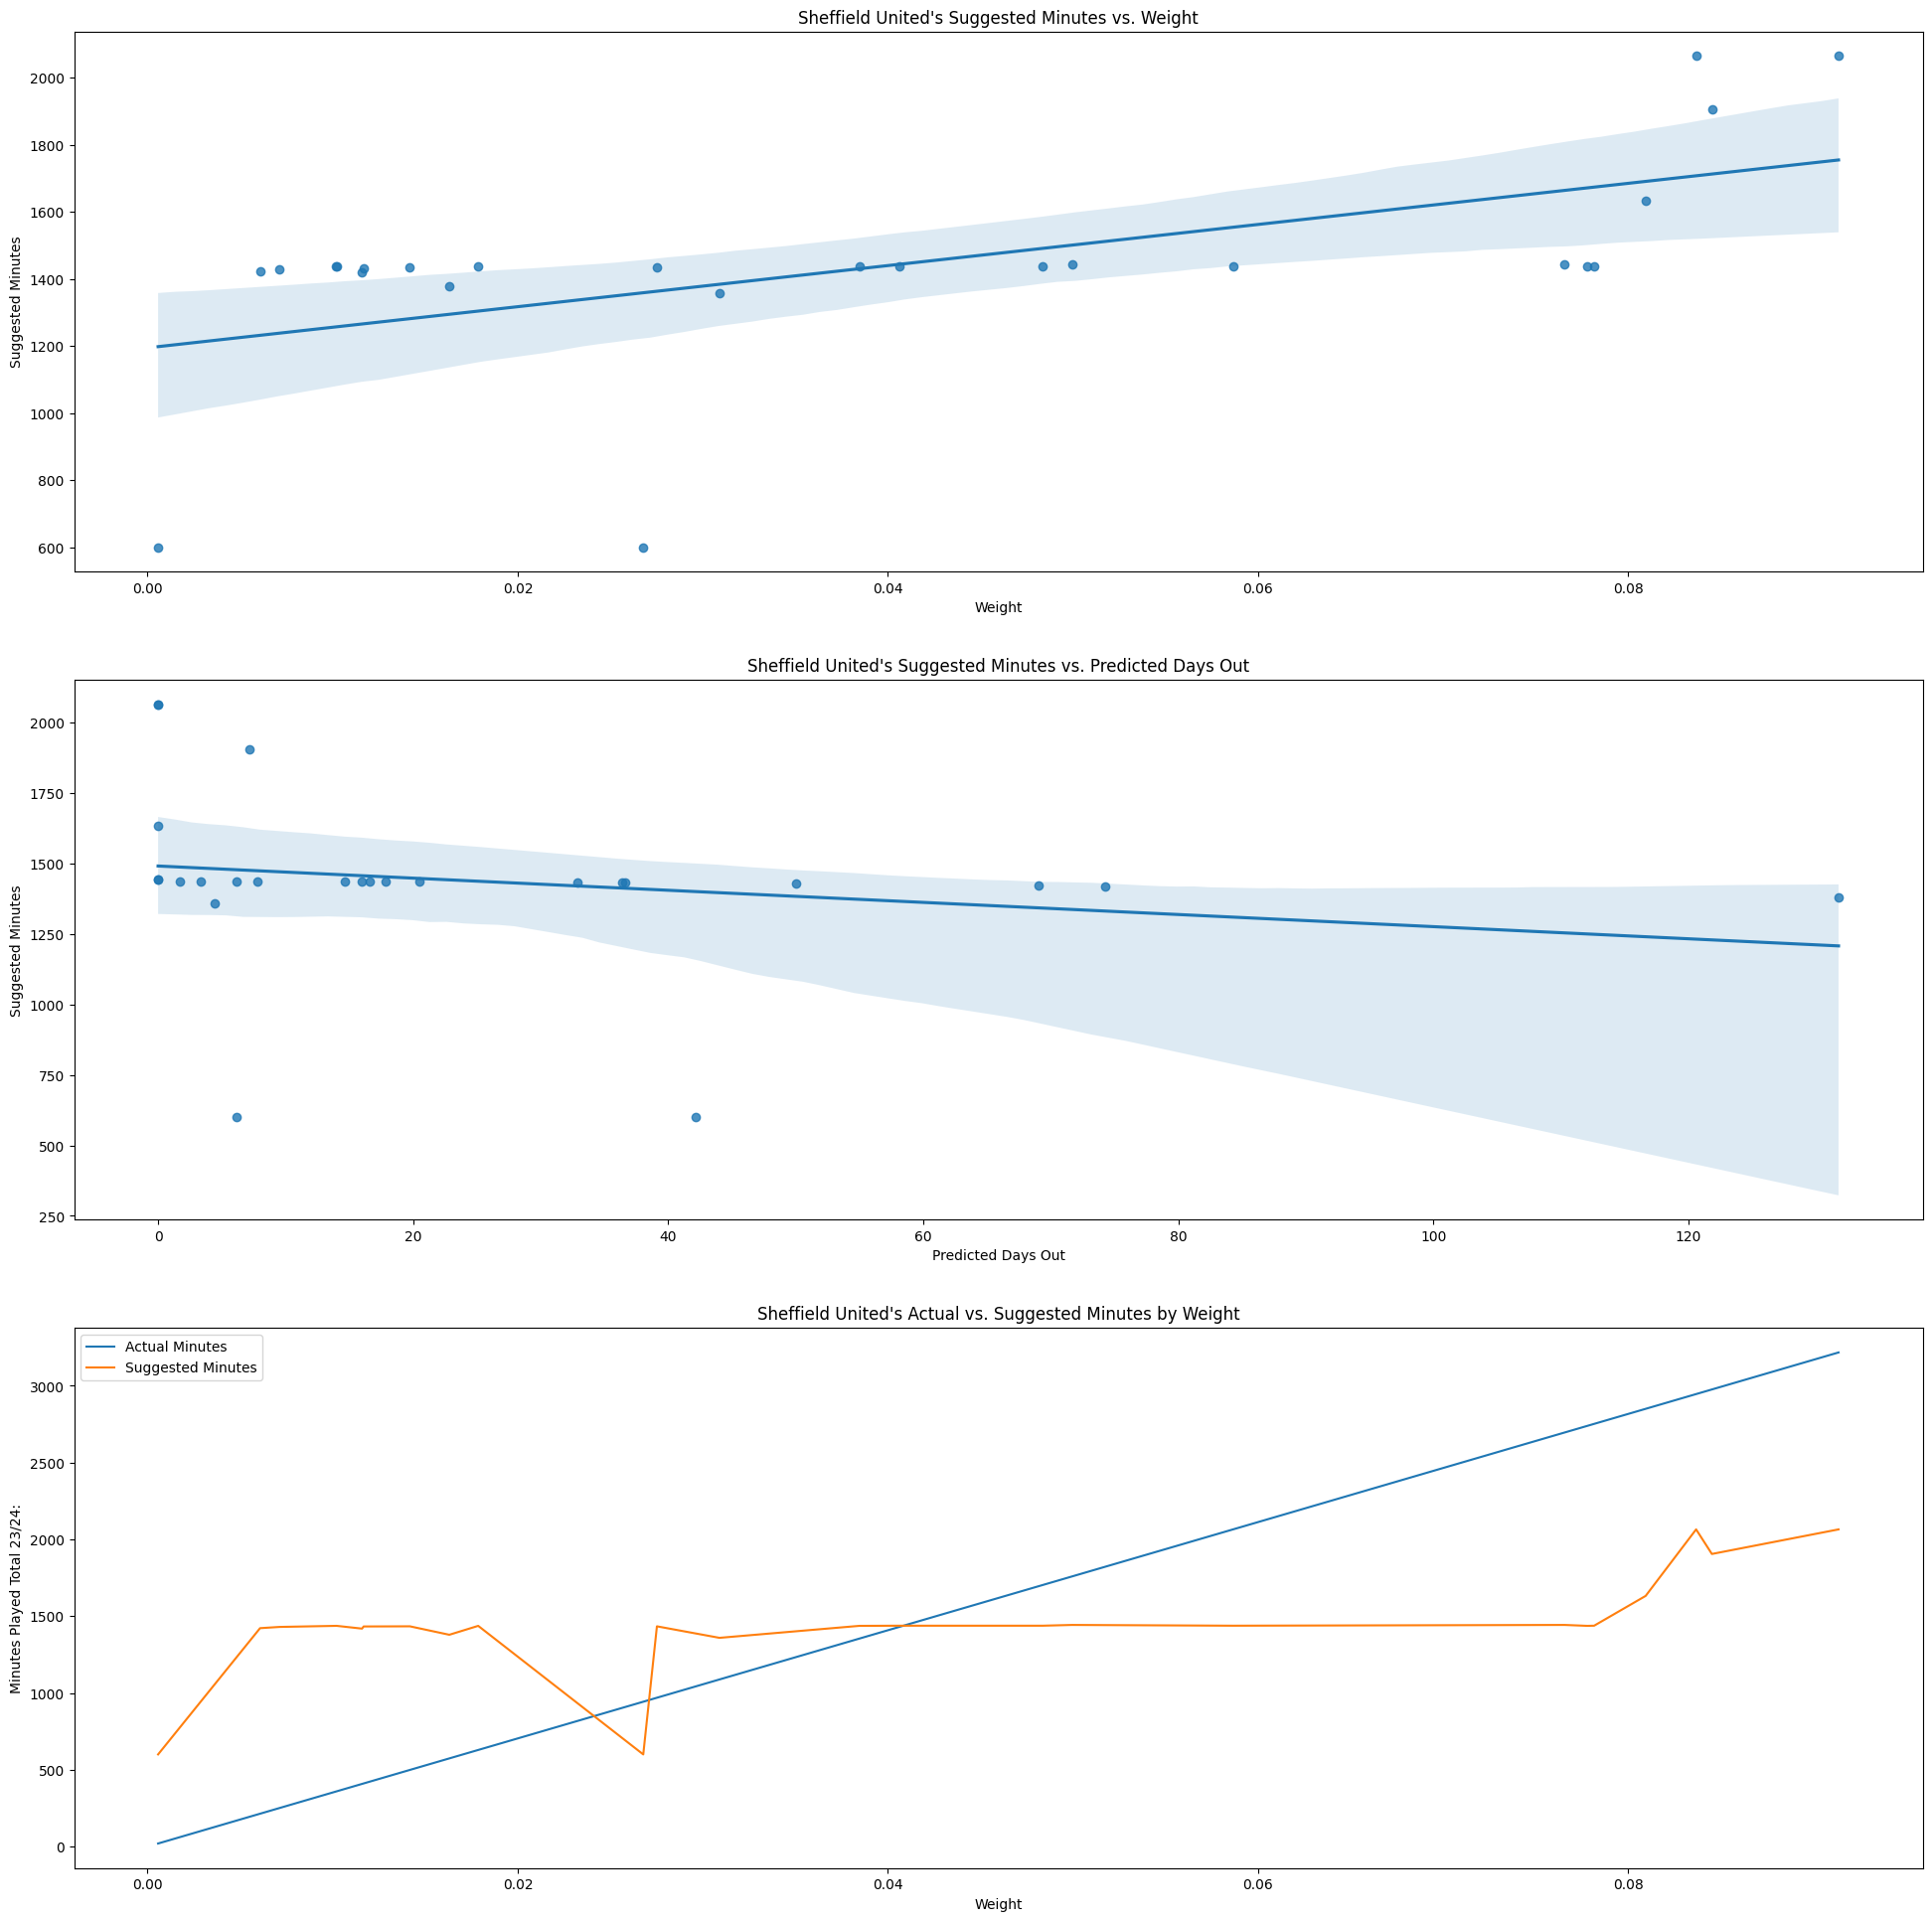

In [176]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=sheff_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Sheffield United's Suggested Minutes vs. Weight")

sns.regplot(data=sheff_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Sheffield United's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=sheff_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=sheff_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Sheffield United's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Daniel Jebbison's Suggested Minutes vs. Lambda")

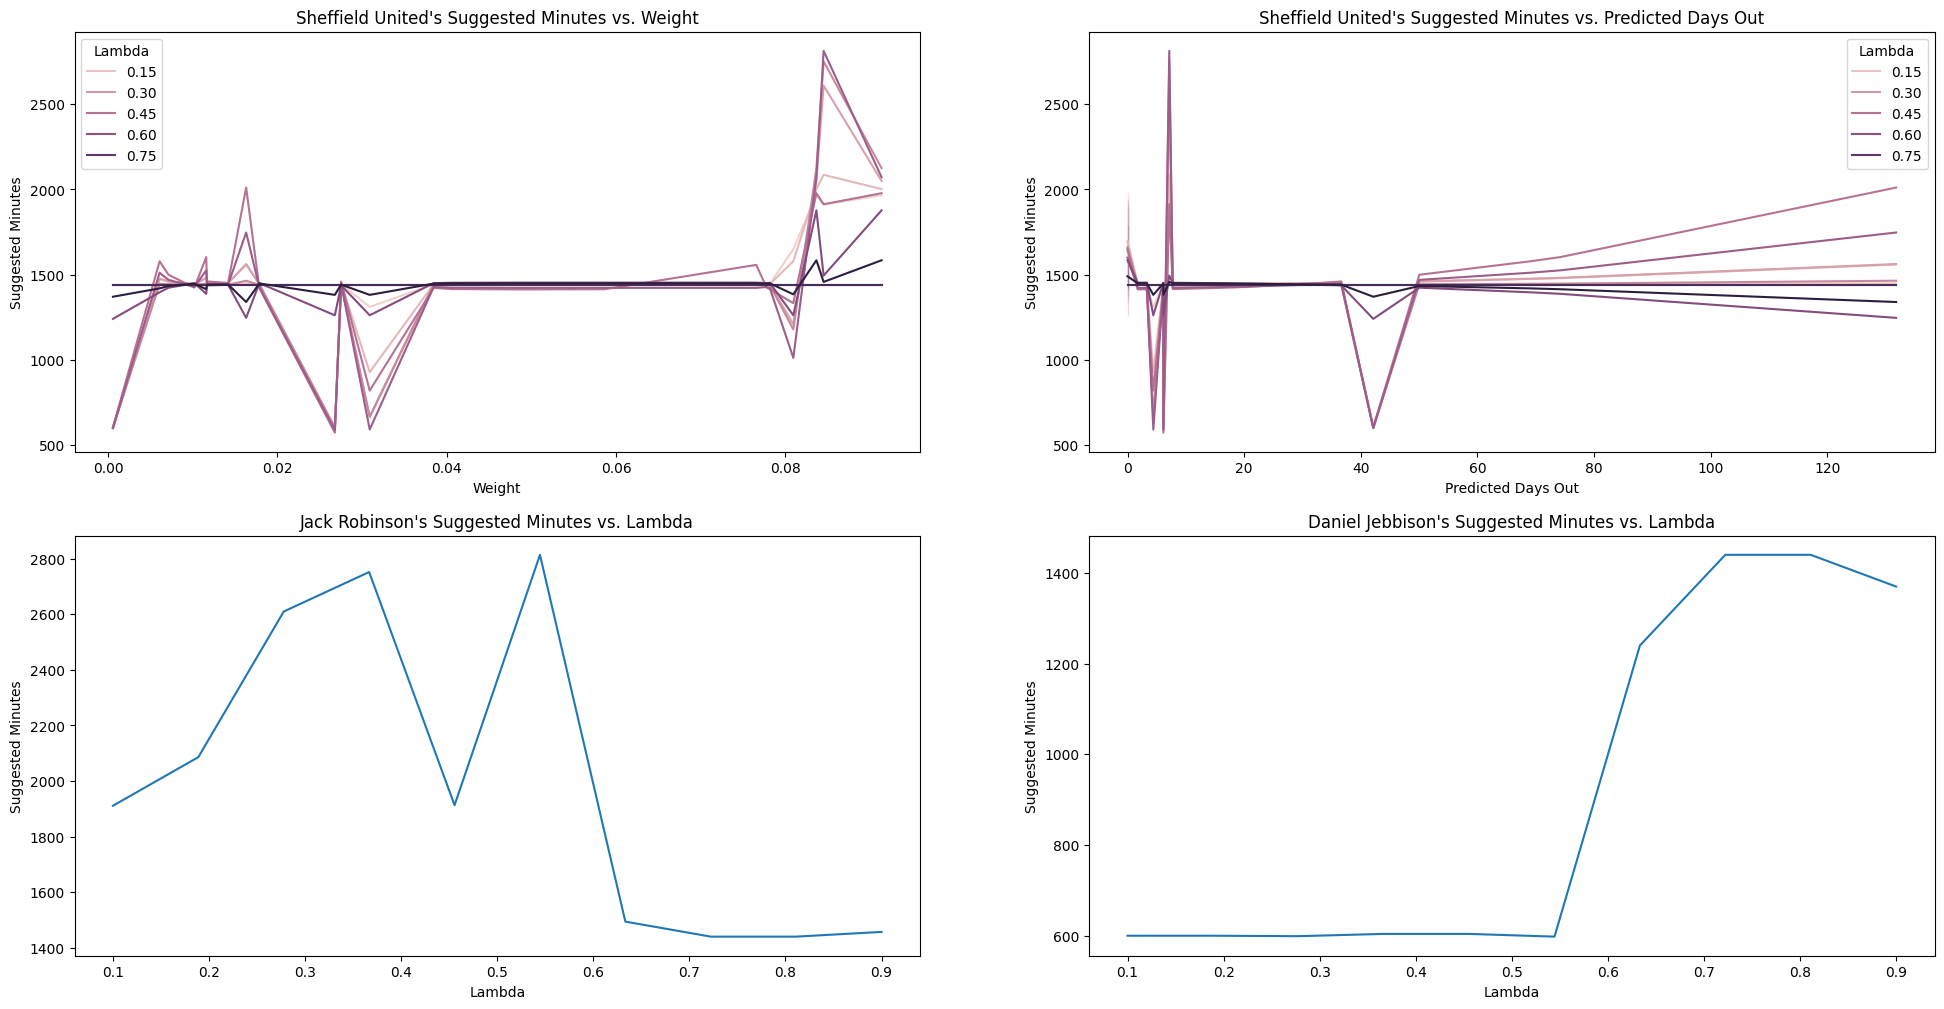

In [177]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Sheff Utd', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Sheffield United's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Sheffield United's Suggested Minutes vs. Predicted Days Out")

robinson_df = results_df[results_df['Name'] == 'Jack Robinson']
sns.lineplot(data=robinson_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Jack Robinson's Suggested Minutes vs. Lambda")

daniel_df = results_df[results_df['Name'] == 'Daniel Jebbison']
sns.lineplot(data=daniel_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Daniel Jebbison's Suggested Minutes vs. Lambda")

### Real Madrid (Champions)

In [208]:
real_madrid_df = optimise('Real Madrid', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.6)
real_madrid_df

Name         Club  Age  Minutes Played Total 23/24:  \
849         Éder Militão  Real Madrid   26                          505   
850          David Alaba  Real Madrid   31                         1407   
851      Antonio Rüdiger  Real Madrid   31                         3986   
852      Nacho Fernández  Real Madrid   34                         3035   
853        Ferland Mendy  Real Madrid   28                         2744   
854          Fran García  Real Madrid   24                         1686   
855      Daniel Carvajal  Real Madrid   32                         3261   
856        Lucas Vázquez  Real Madrid   32                         1780   
857  Aurélien Tchouaméni  Real Madrid   24                         2809   
858    Federico Valverde  Real Madrid   25                         4190   
859    Eduardo Camavinga  Real Madrid   21                         2733   
860           Toni Kroos  Real Madrid   34                         3094   
861          Luka Modric  Real Madrid   38                         2238   
862        Dani Ceballos  Real Madrid   27                          862   
863      Jude Bellingham  Real Madrid   20                         3559   
864          Brahim Díaz  Real Madrid   24                         2064   
865           Arda Güler  Real Madrid   19                          440   
866             Nico Paz  Real Madrid   19                         2757   
867      Vinicius Junior  Real Madrid   23                         2994   
868              Rodrygo  Real Madrid   23                         3616   
869               Joselu  Real Madrid   34                         2090   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
849  0.009740          161.049497               0.0     0.6               1459  
850  0.027136          137.460755               0.0     0.6               1736  
851  0.076876           13.708890            4390.4     0.6               4473  
852  0.058534           15.343626            2744.0     0.6               2563  
853  0.052922           51.527754            2195.2     0.6               2376  
854  0.032517           35.197406               0.0     0.6               2432  
855  0.062893           25.899997            3567.2     0.6               2978  
856  0.034330           16.854470               0.0     0.6               2470  
857  0.054176           25.589066            2744.0     0.6               2546  
858  0.080810            4.016790            4390.4     0.6               4530  
859  0.052710           10.931446            2195.2     0.6               1830  
860  0.059672            8.981627            3567.2     0.6               3001  
861  0.043163            5.119133            1372.0     0.6               1834  
862  0.016625           43.860810               0.0     0.6               2405  
863  0.068640           33.097226            3567.2     0.6               2315  
864  0.039807            3.557439            1372.0     0.6               2481  
865  0.008486          122.694315               0.0     0.6               1242  
866  0.053173           10.600582            2195.2     0.6               1831  
867  0.057743           43.992237            2744.0     0.6               2496  
868  0.069740           13.143800            4390.4     0.6               4524  
869  0.040309            9.265594            1372.0     0.6               2478

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

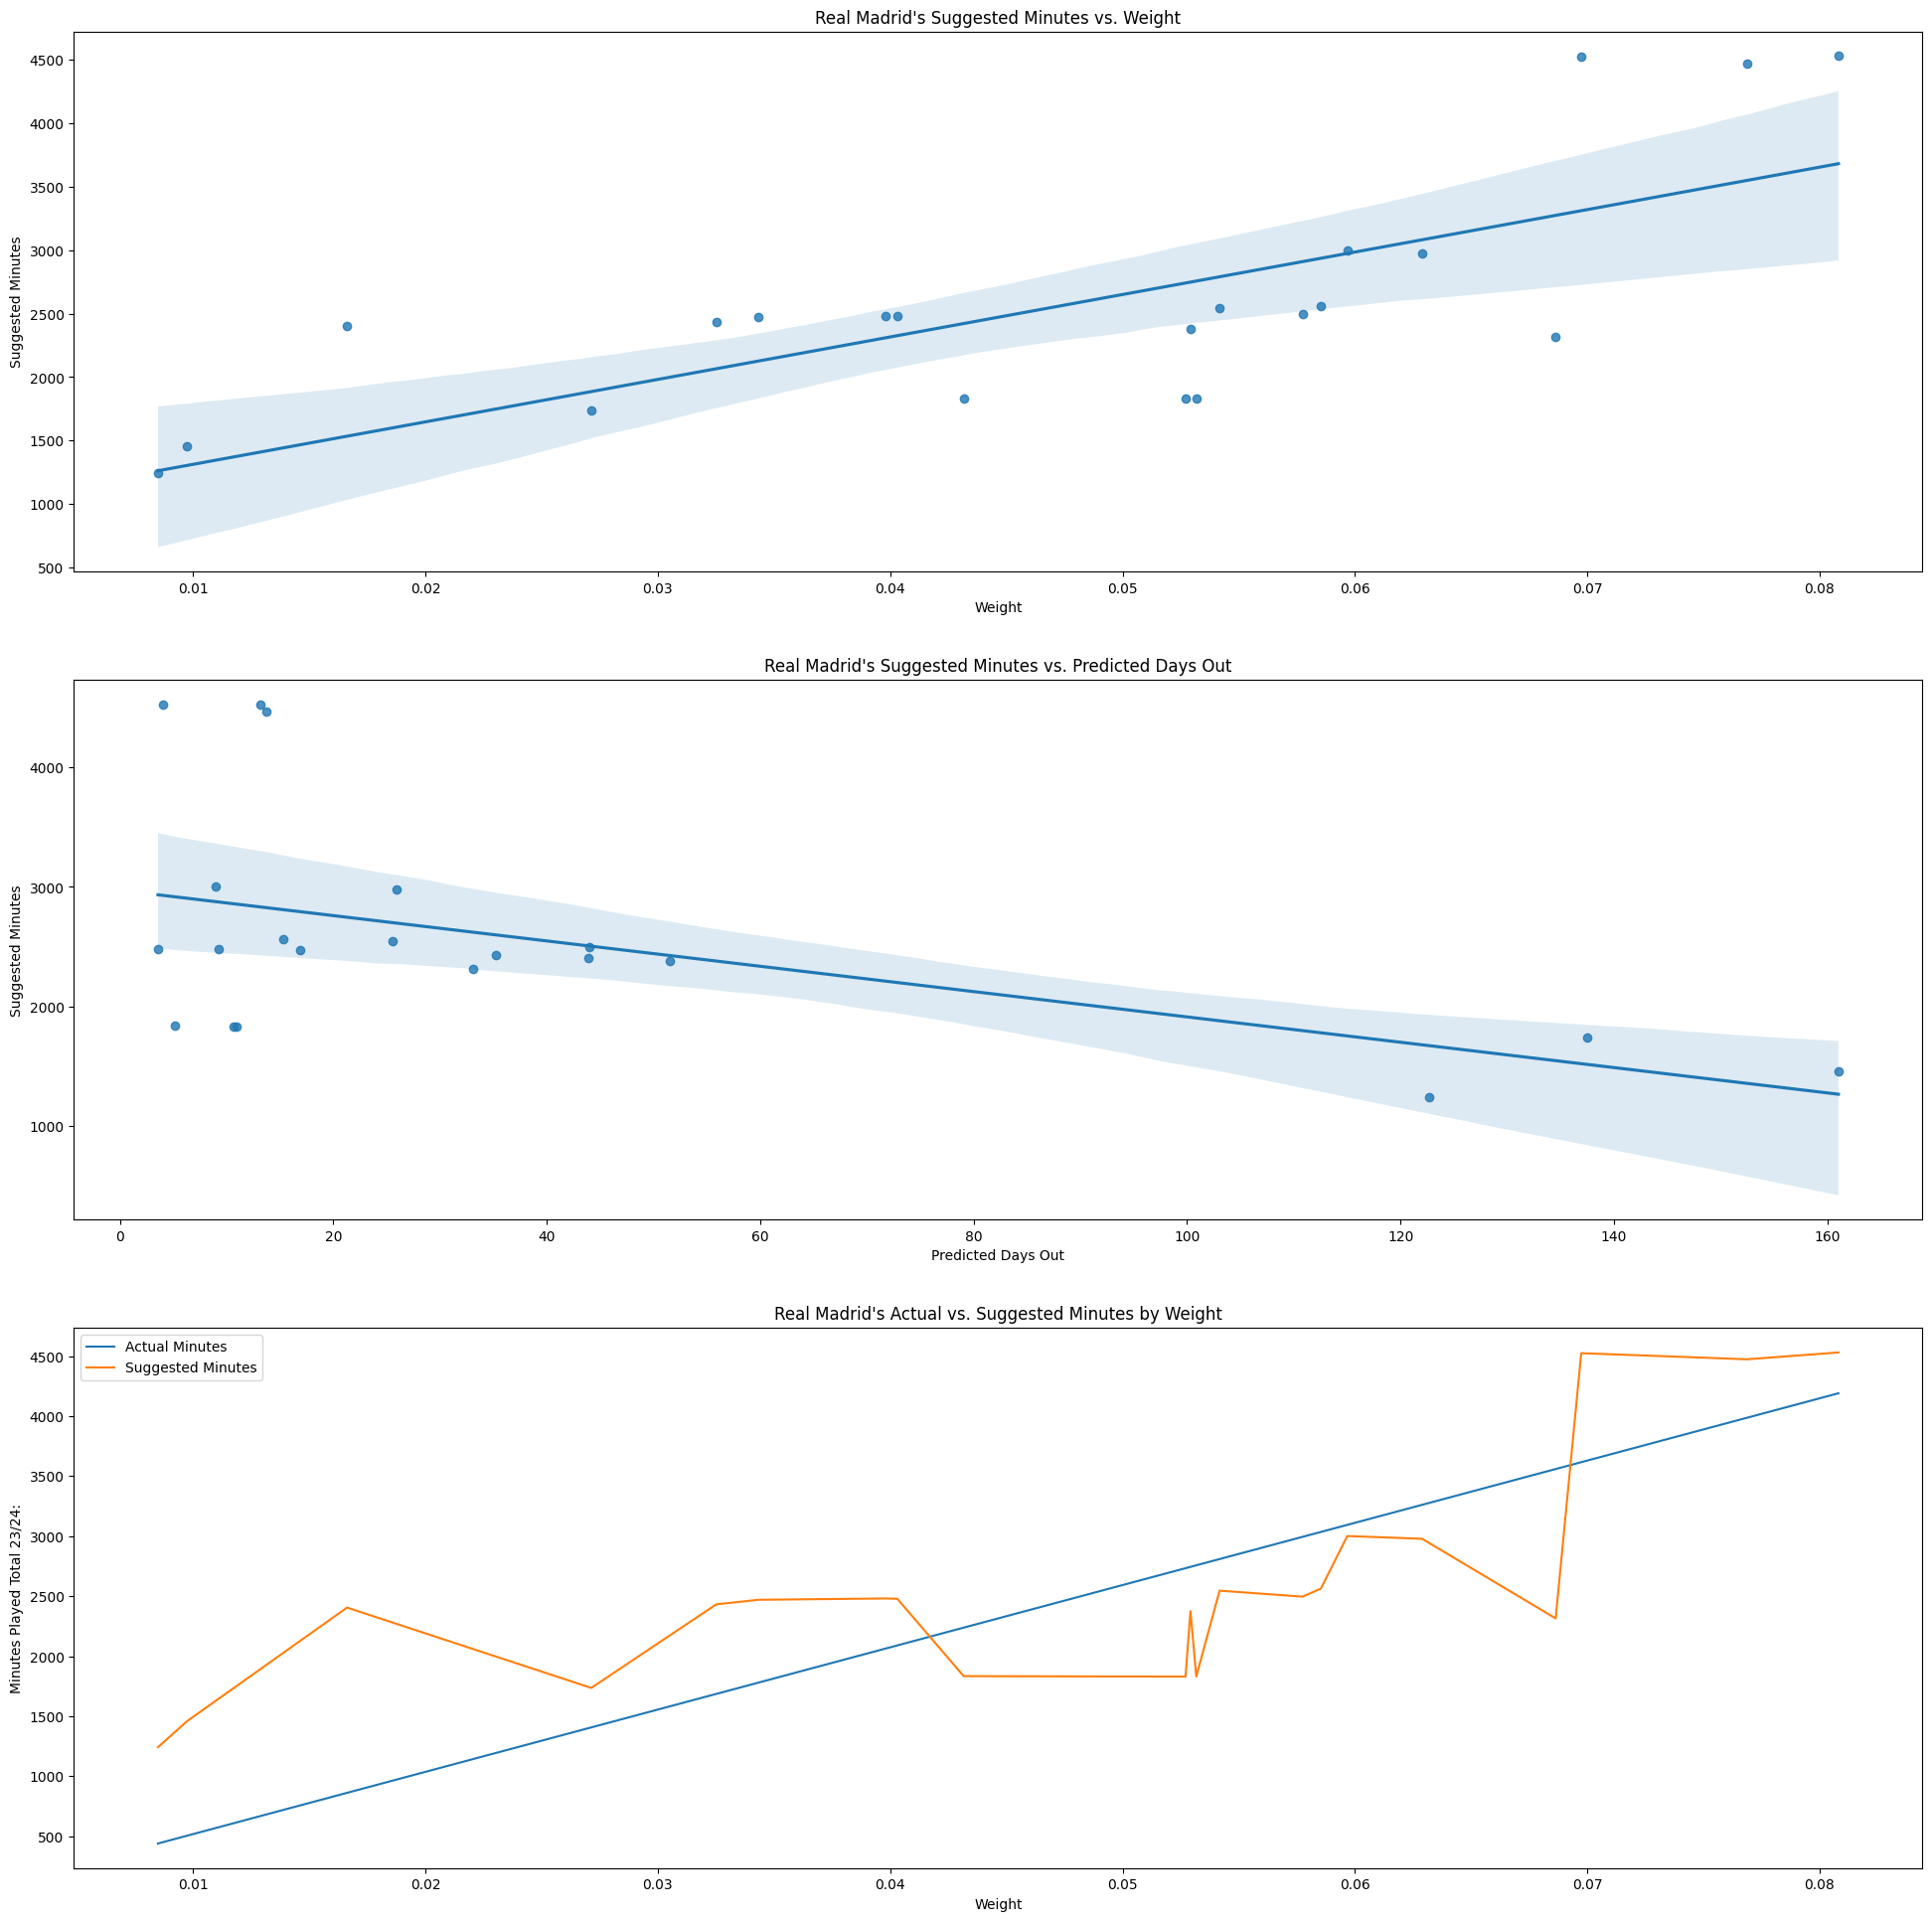

In [179]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=real_madrid_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Real Madrid's Suggested Minutes vs. Weight")

sns.regplot(data=real_madrid_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Real Madrid's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=real_madrid_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=real_madrid_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Real Madrid's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [180]:
real_madrid_df = optimise('Real Madrid', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.2)
real_madrid_df

Name         Club  Age  Minutes Played Total 23/24:  \
849         Éder Militão  Real Madrid   26                          505   
850          David Alaba  Real Madrid   31                         1407   
851      Antonio Rüdiger  Real Madrid   31                         3986   
852      Nacho Fernández  Real Madrid   34                         3035   
853        Ferland Mendy  Real Madrid   28                         2744   
854          Fran García  Real Madrid   24                         1686   
855      Daniel Carvajal  Real Madrid   32                         3261   
856        Lucas Vázquez  Real Madrid   32                         1780   
857  Aurélien Tchouaméni  Real Madrid   24                         2809   
858    Federico Valverde  Real Madrid   25                         4190   
859    Eduardo Camavinga  Real Madrid   21                         2733   
860           Toni Kroos  Real Madrid   34                         3094   
861          Luka Modric  Real Madrid   38                         2238   
862        Dani Ceballos  Real Madrid   27                          862   
863      Jude Bellingham  Real Madrid   20                         3559   
864          Brahim Díaz  Real Madrid   24                         2064   
865           Arda Güler  Real Madrid   19                          440   
866             Nico Paz  Real Madrid   19                         2757   
867      Vinicius Junior  Real Madrid   23                         2994   
868              Rodrygo  Real Madrid   23                         3616   
869               Joselu  Real Madrid   34                         2090   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
849  0.009740          161.049497               0.0     0.2               2171  
850  0.027136          137.460755               0.0     0.2               2222  
851  0.076876           13.708890            4390.4     0.2               4168  
852  0.058534           15.343626            2744.0     0.2               2444  
853  0.052922           51.527754            2195.2     0.2               2338  
854  0.032517           35.197406               0.0     0.2               2346  
855  0.062893           25.899997            3567.2     0.2               4174  
856  0.034330           16.854470               0.0     0.2               2354  
857  0.054176           25.589066            2744.0     0.2               2441  
858  0.080810            4.016790            4390.4     0.2               4112  
859  0.052710           10.931446            2195.2     0.2               1543  
860  0.059672            8.981627            3567.2     0.2               4282  
861  0.043163            5.119133            1372.0     0.2                987  
862  0.016625           43.860810               0.0     0.2               2341  
863  0.068640           33.097226            3567.2     0.2               2901  
864  0.039807            3.557439            1372.0     0.2               2355  
865  0.008486          122.694315               0.0     0.2                738  
866  0.053173           10.600582            2195.2     0.2               1539  
867  0.057743           43.992237            2744.0     0.2               2433  
868  0.069740           13.143800            4390.4     0.2               3753  
869  0.040309            9.265594            1372.0     0.2               2356

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

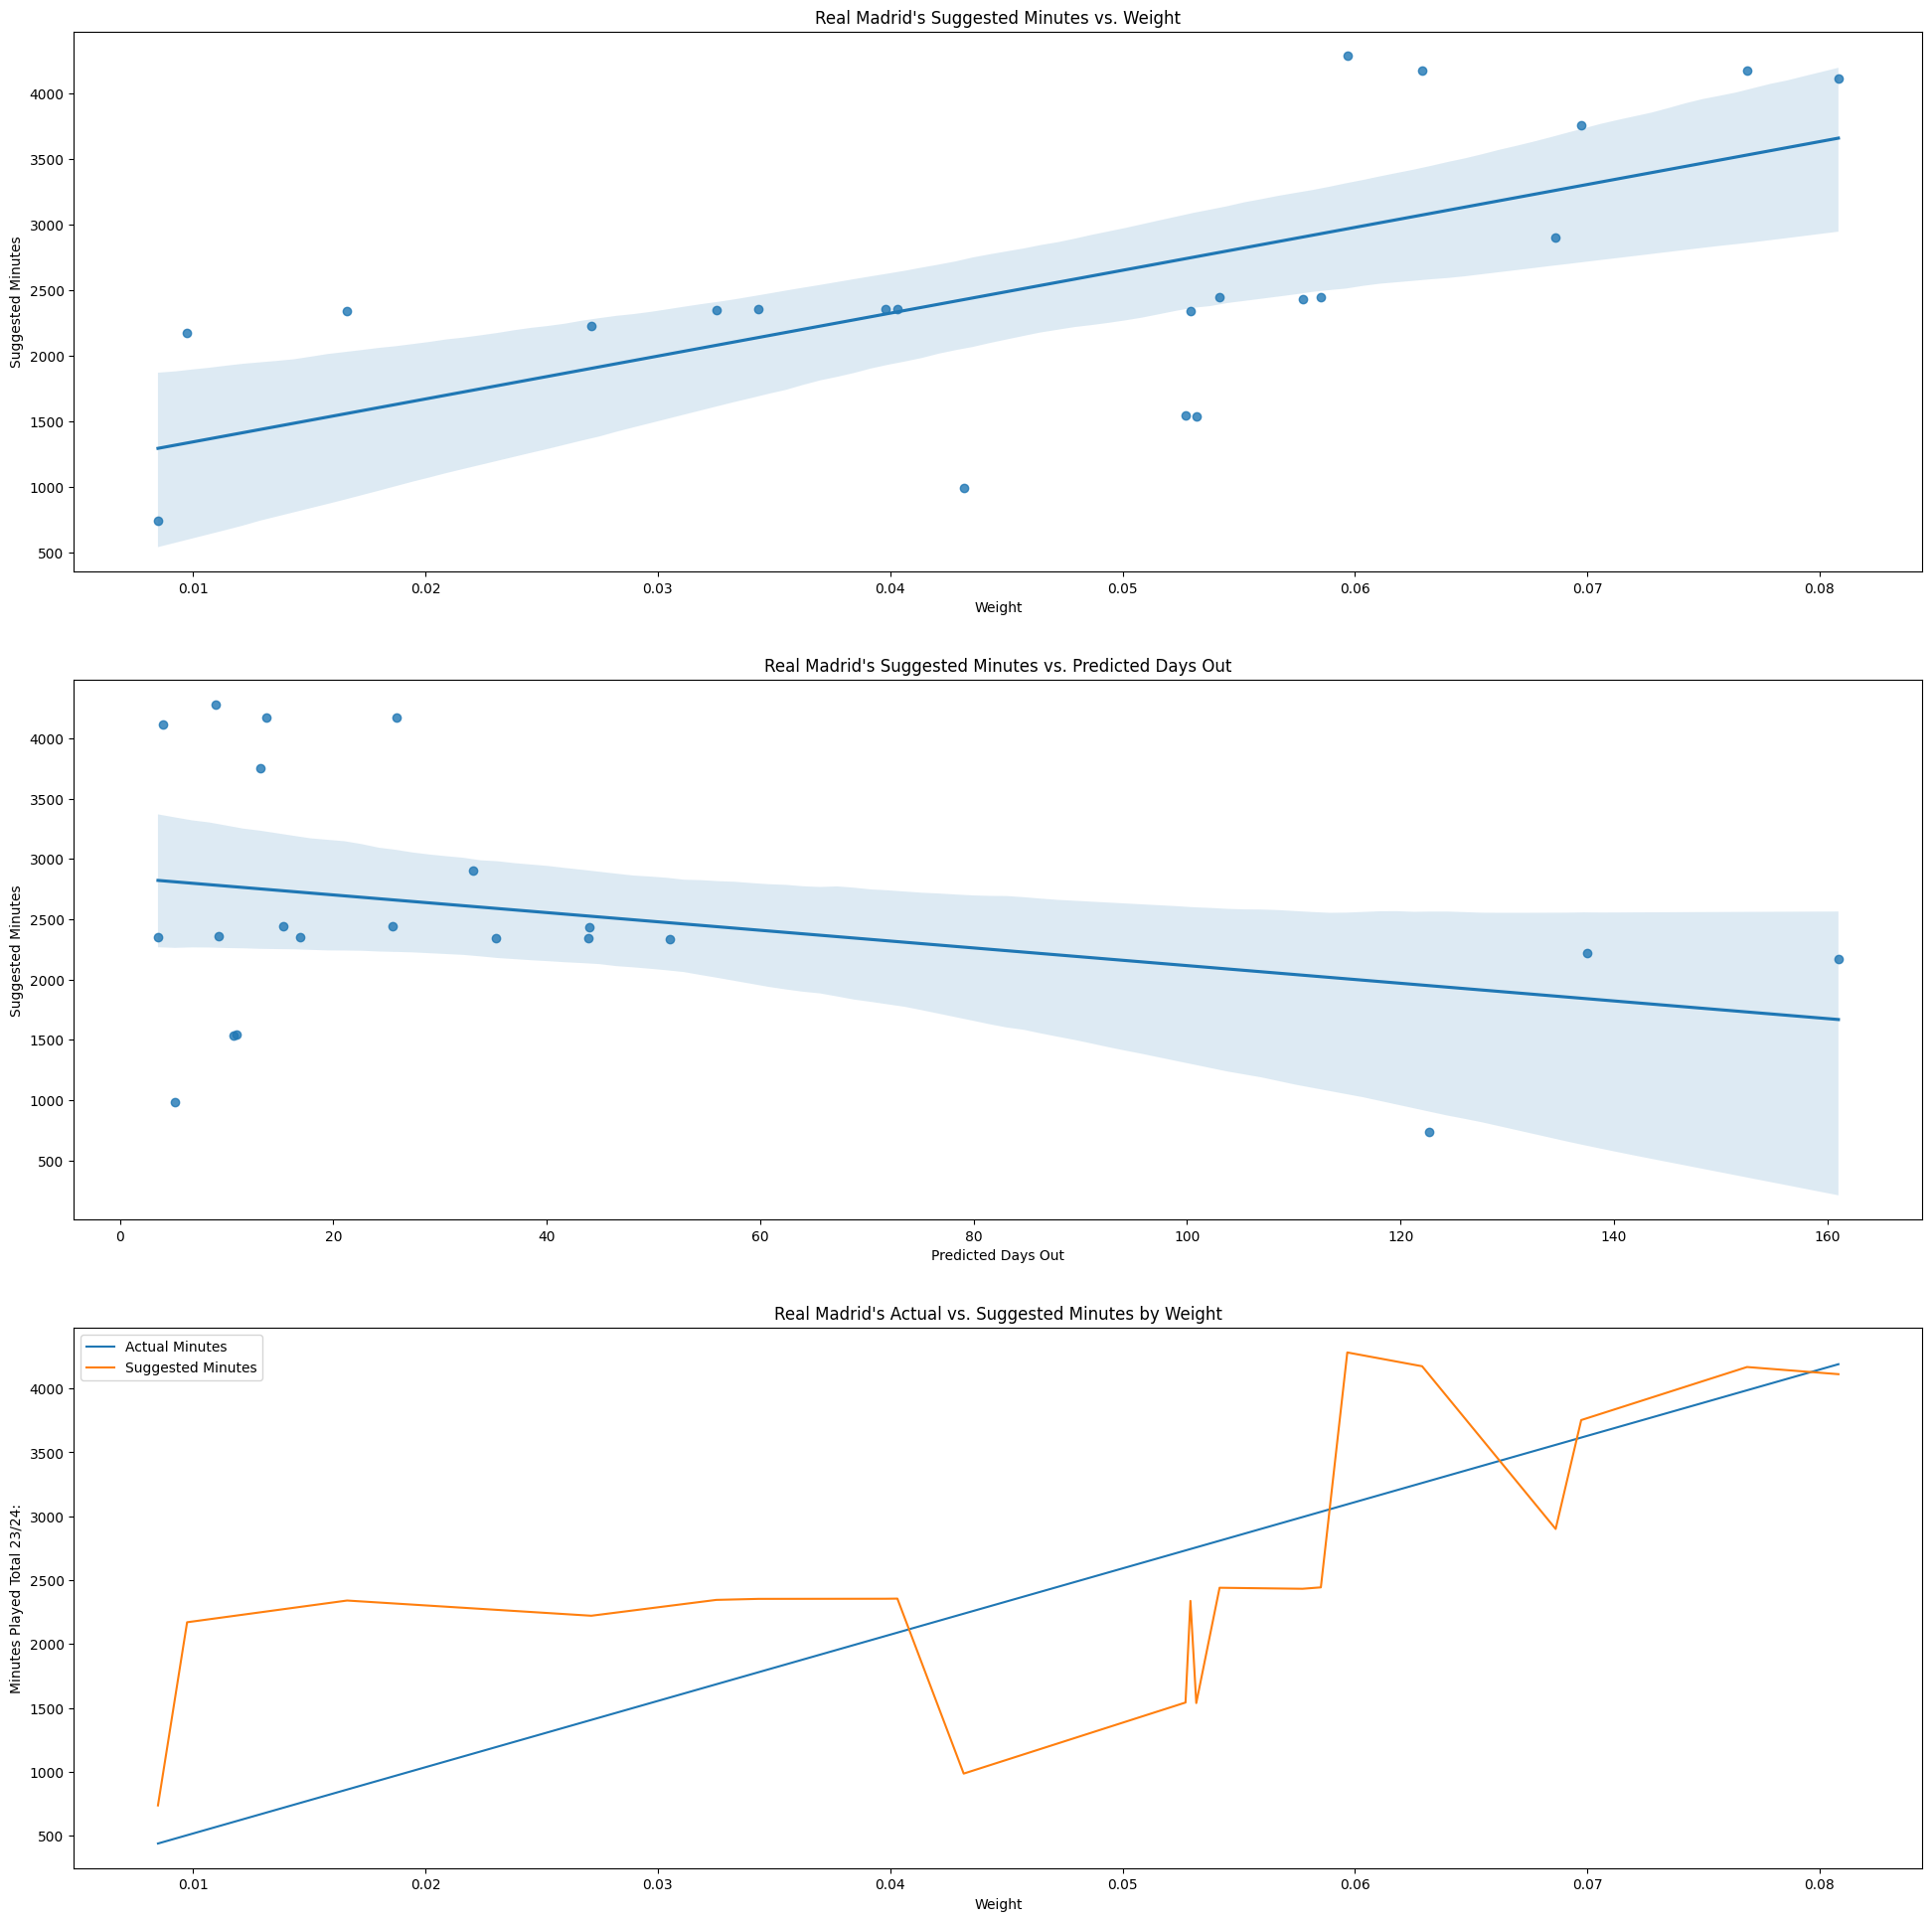

In [181]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=real_madrid_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Real Madrid's Suggested Minutes vs. Weight")

sns.regplot(data=real_madrid_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Real Madrid's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=real_madrid_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=real_madrid_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Real Madrid's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Guler's Suggested Minutes vs. Lambda")

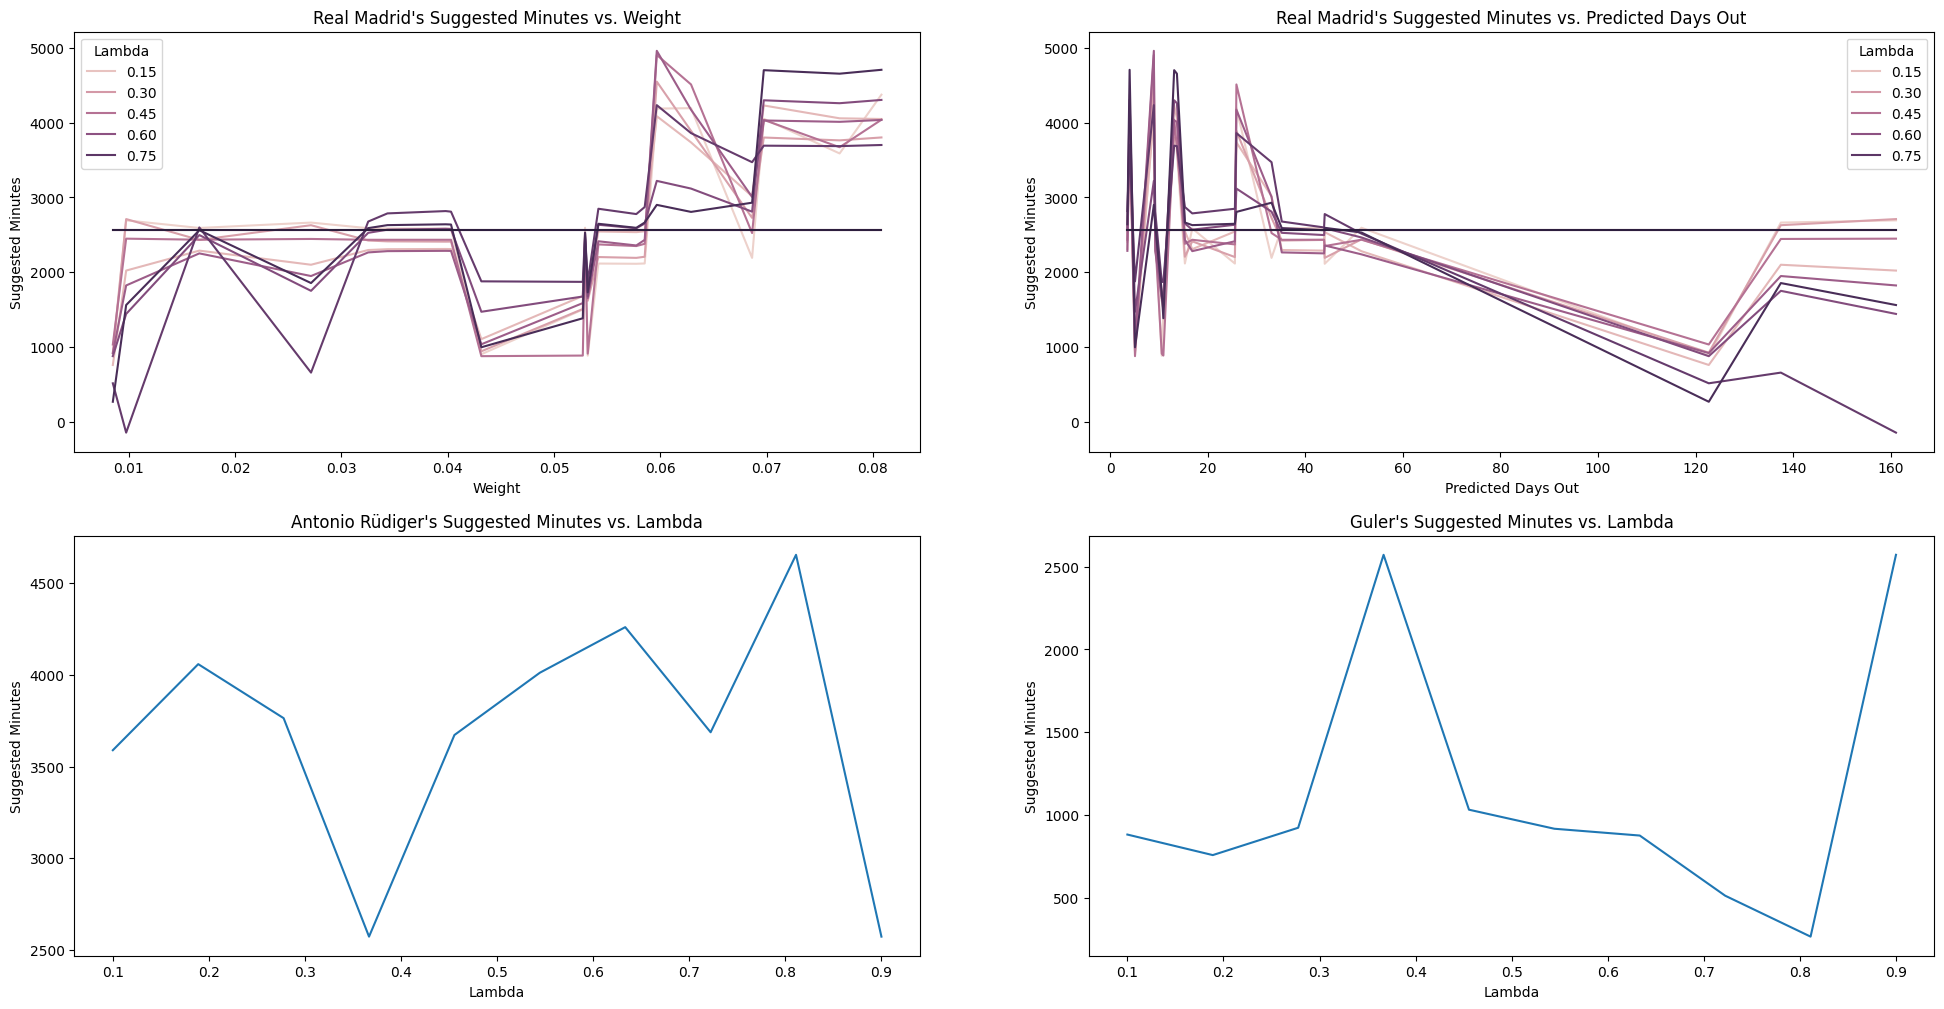

In [182]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Real Madrid', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Real Madrid's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Real Madrid's Suggested Minutes vs. Predicted Days Out")

rudiger_df = results_df[results_df['Name'] == 'Antonio Rüdiger']
sns.lineplot(data=rudiger_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Antonio Rüdiger's Suggested Minutes vs. Lambda")

guler_df = results_df[results_df['Name'] == 'Arda Güler']
sns.lineplot(data=guler_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Guler's Suggested Minutes vs. Lambda")

### Osasuna (Mid Table)

In [209]:
osasuna_df = optimise('CA Osasuna', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=0.9)
osasuna_df

Name        Club  Age  Minutes Played Total 23/24:  \
689        David García  CA Osasuna   30                         2816   
690    Alejandro Catena  CA Osasuna   29                         2862   
691         Unai García  CA Osasuna   32                          559   
692      Jorge Herrando  CA Osasuna   23                         1764   
693           Juan Cruz  CA Osasuna   31                         2040   
694        Johan Mojica  CA Osasuna   31                         2298   
695         Jesús Areso  CA Osasuna   24                         2899   
696          Rubén Peña  CA Osasuna   32                         2411   
697         Lucas Torró  CA Osasuna   29                         2141   
698          Iker Muñoz  CA Osasuna   21                         1923   
699       Jon Moncayola  CA Osasuna   26                         2106   
700        Pablo Ibáñez  CA Osasuna   25                         1259   
701          Aimar Oroz  CA Osasuna   22                         2655   
702           Moi Gómez  CA Osasuna   29                         2252   
703        Rubén García  CA Osasuna   30                         1757   
704  José Manuel Arnáiz  CA Osasuna   29                         1136   
705          Kike Barja  CA Osasuna   27                          397   
706        Ante Budimir  CA Osasuna   32                         2761   
707         Raúl García  CA Osasuna   23                         1474   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
689  0.075073           41.183196            2737.8     0.9               1898  
690  0.076300           17.944567            3369.6     0.9               2327  
691  0.014903           88.584142               0.0     0.9               1833  
692  0.047027           26.861534            1053.0     0.9               1890  
693  0.054385           22.919017            1053.0     0.9               1892  
694  0.061264           19.712879            2106.0     0.9               1897  
695  0.077286            0.000000            3369.6     0.9               2802  
696  0.064276           29.084247            2106.0     0.9               1893  
697  0.057078           10.951659            1684.8     0.9               1895  
698  0.051266            8.601684            1053.0     0.9                604  
699  0.056145            6.632598            1684.8     0.9               1896  
700  0.033564            0.000000               0.0     0.9               1896  
701  0.070781           18.211386            2737.8     0.9               1909  
702  0.060037           32.691527            2106.0     0.9               1891  
703  0.046841           14.552830               0.0     0.9               1895  
704  0.030285           24.628379               0.0     0.9               1891  
705  0.010584           34.614847               0.0     0.9               1887  
706  0.073607           18.895933            2737.8     0.9               1908  
707  0.039296            0.000000               0.0     0.9               1896

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

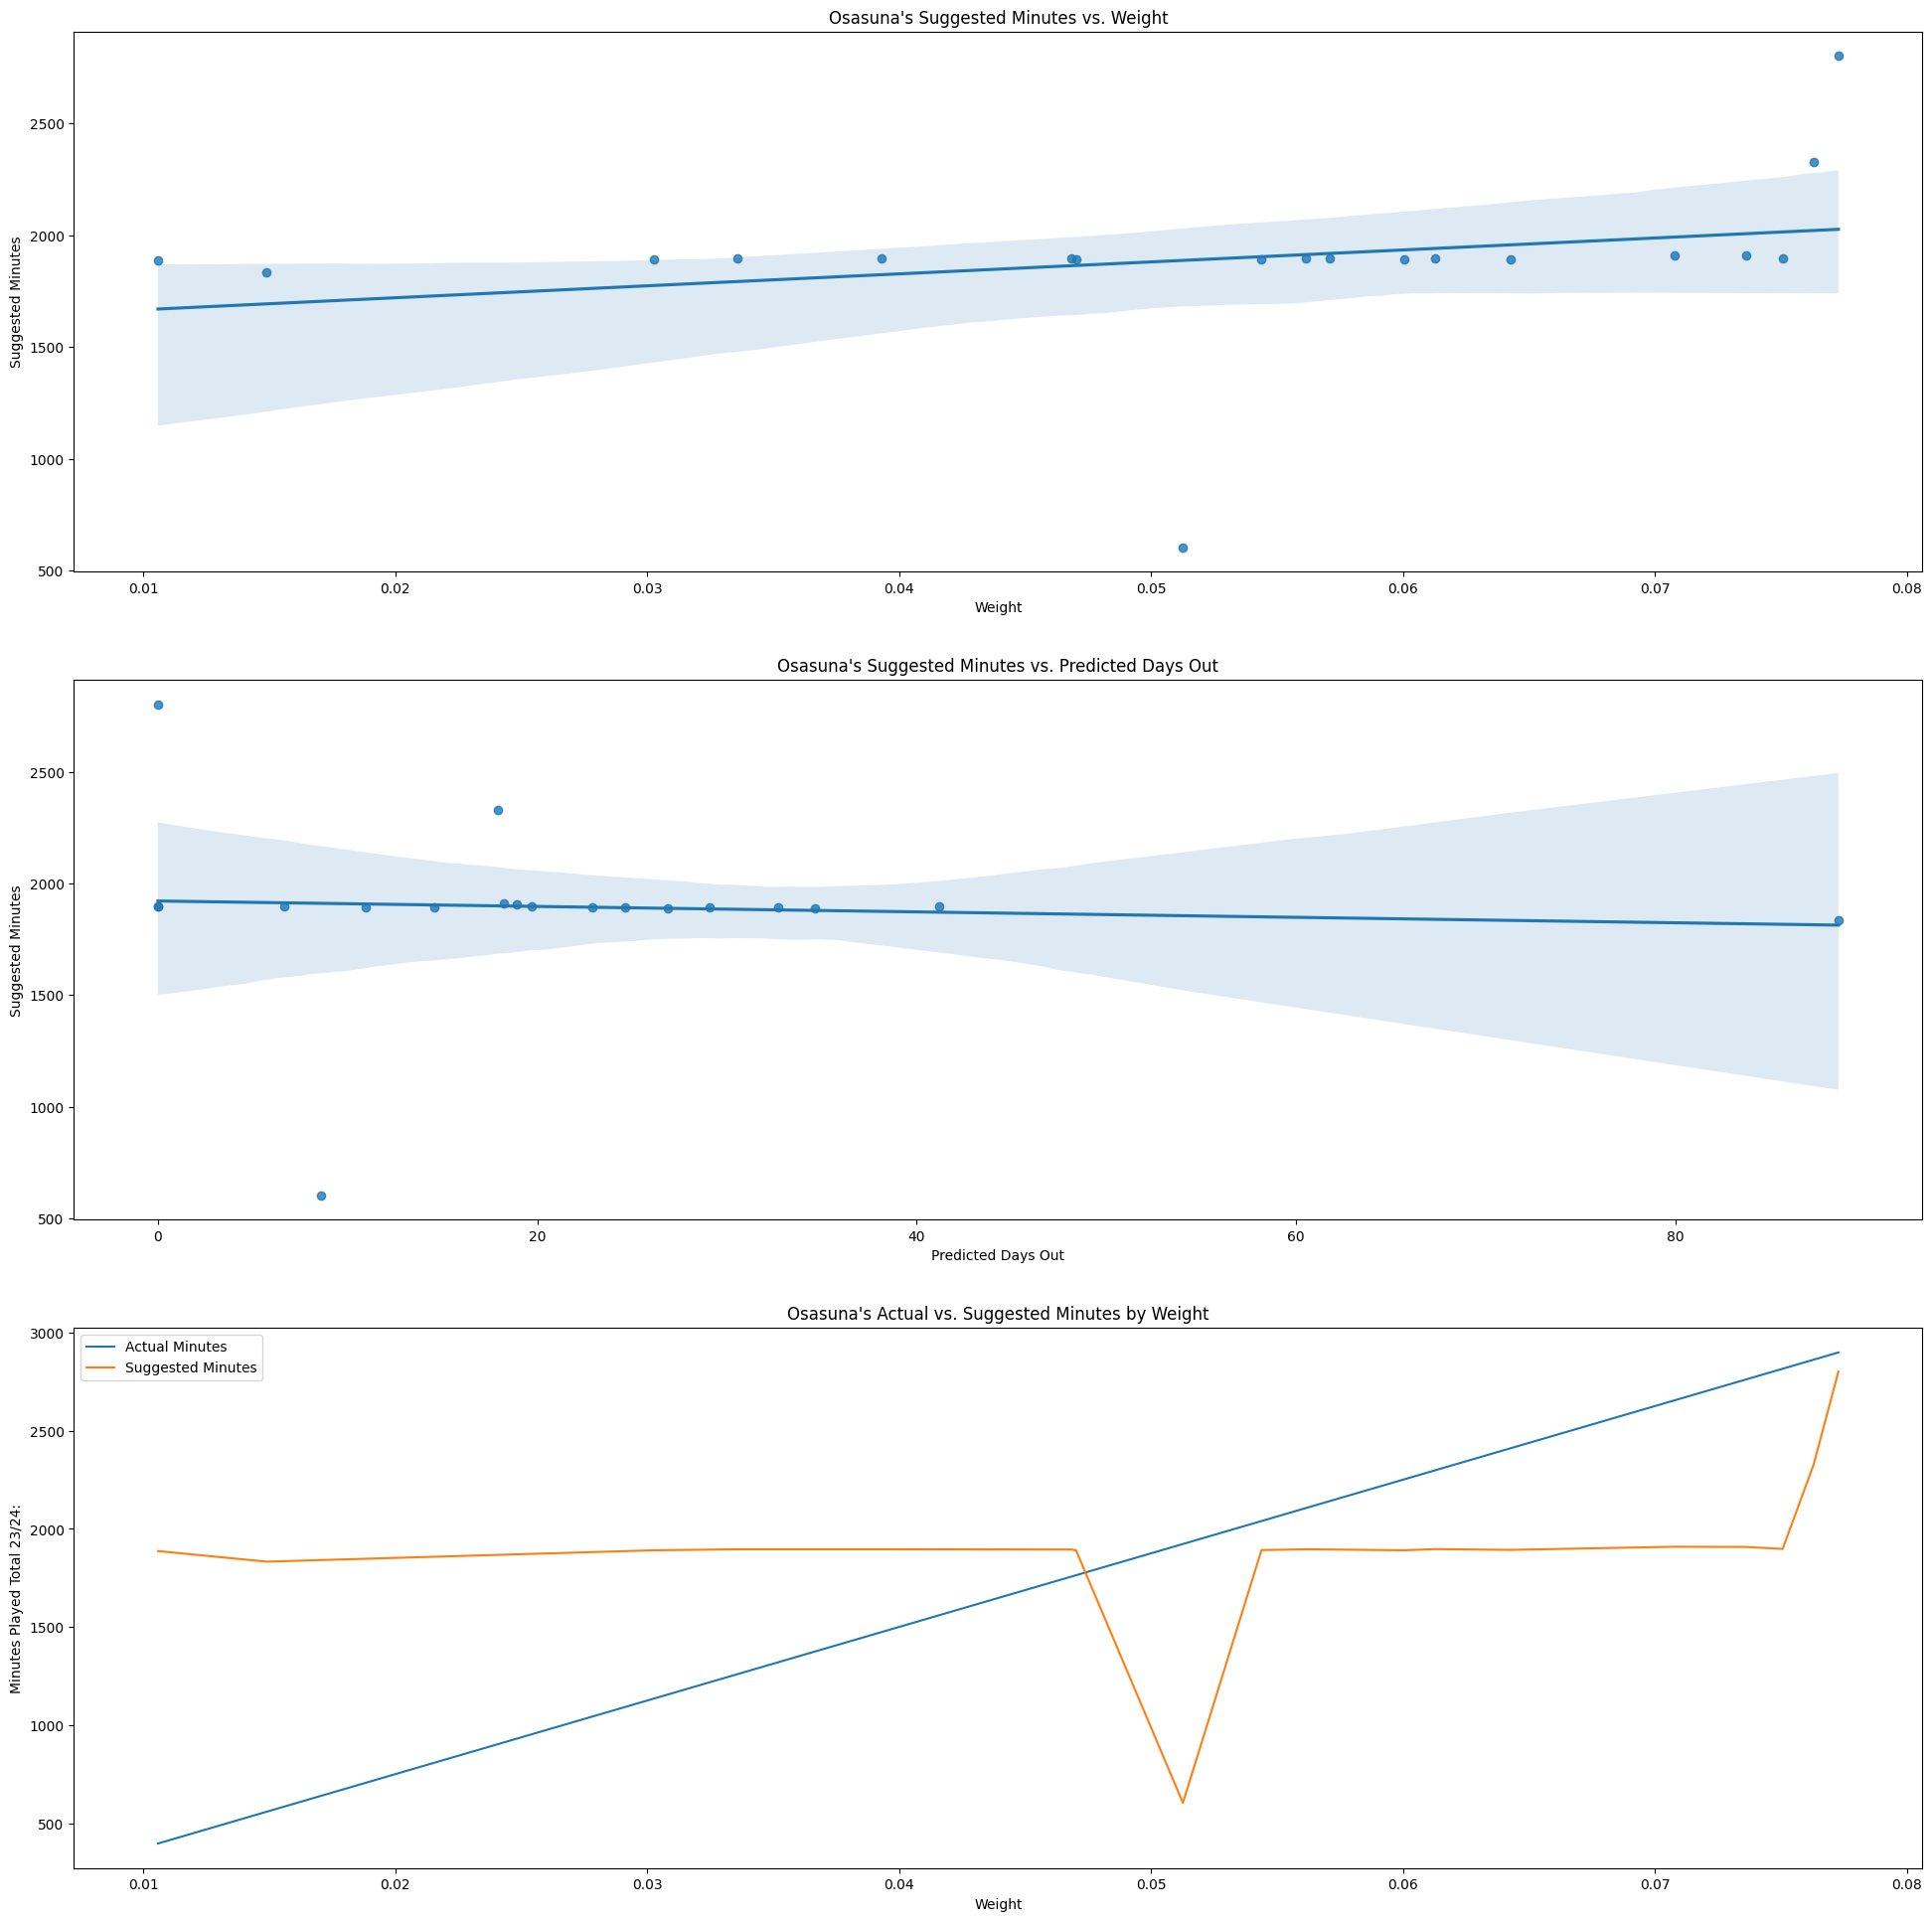

In [210]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=osasuna_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Osasuna's Suggested Minutes vs. Weight")

sns.regplot(data=osasuna_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Osasuna's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=osasuna_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=osasuna_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Osasuna's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [213]:
osasuna_df = optimise('CA Osasuna', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=0.4)
osasuna_df

Name        Club  Age  Minutes Played Total 23/24:  \
689        David García  CA Osasuna   30                         2816   
690    Alejandro Catena  CA Osasuna   29                         2862   
691         Unai García  CA Osasuna   32                          559   
692      Jorge Herrando  CA Osasuna   23                         1764   
693           Juan Cruz  CA Osasuna   31                         2040   
694        Johan Mojica  CA Osasuna   31                         2298   
695         Jesús Areso  CA Osasuna   24                         2899   
696          Rubén Peña  CA Osasuna   32                         2411   
697         Lucas Torró  CA Osasuna   29                         2141   
698          Iker Muñoz  CA Osasuna   21                         1923   
699       Jon Moncayola  CA Osasuna   26                         2106   
700        Pablo Ibáñez  CA Osasuna   25                         1259   
701          Aimar Oroz  CA Osasuna   22                         2655   
702           Moi Gómez  CA Osasuna   29                         2252   
703        Rubén García  CA Osasuna   30                         1757   
704  José Manuel Arnáiz  CA Osasuna   29                         1136   
705          Kike Barja  CA Osasuna   27                          397   
706        Ante Budimir  CA Osasuna   32                         2761   
707         Raúl García  CA Osasuna   23                         1474   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
689  0.075073           41.183196            2737.8     0.4               2084  
690  0.076300           17.944567            3369.6     0.4               2800  
691  0.014903           88.584142               0.0     0.4               1702  
692  0.047027           26.861534            1053.0     0.4               1786  
693  0.054385           22.919017            1053.0     0.4               1788  
694  0.061264           19.712879            2106.0     0.4               1871  
695  0.077286            0.000000            3369.6     0.4               2752  
696  0.064276           29.084247            2106.0     0.4               1865  
697  0.057078           10.951659            1684.8     0.4               1793  
698  0.051266            8.601684            1053.0     0.4                610  
699  0.056145            6.632598            1684.8     0.4               1794  
700  0.033564            0.000000               0.0     0.4               1794  
701  0.070781           18.211386            2737.8     0.4               2107  
702  0.060037           32.691527            2106.0     0.4               1862  
703  0.046841           14.552830               0.0     0.4               1792  
704  0.030285           24.628379               0.0     0.4               1787  
705  0.010584           34.614847               0.0     0.4               1780  
706  0.073607           18.895933            2737.8     0.4               2239  
707  0.039296            0.000000               0.0     0.4               1794

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

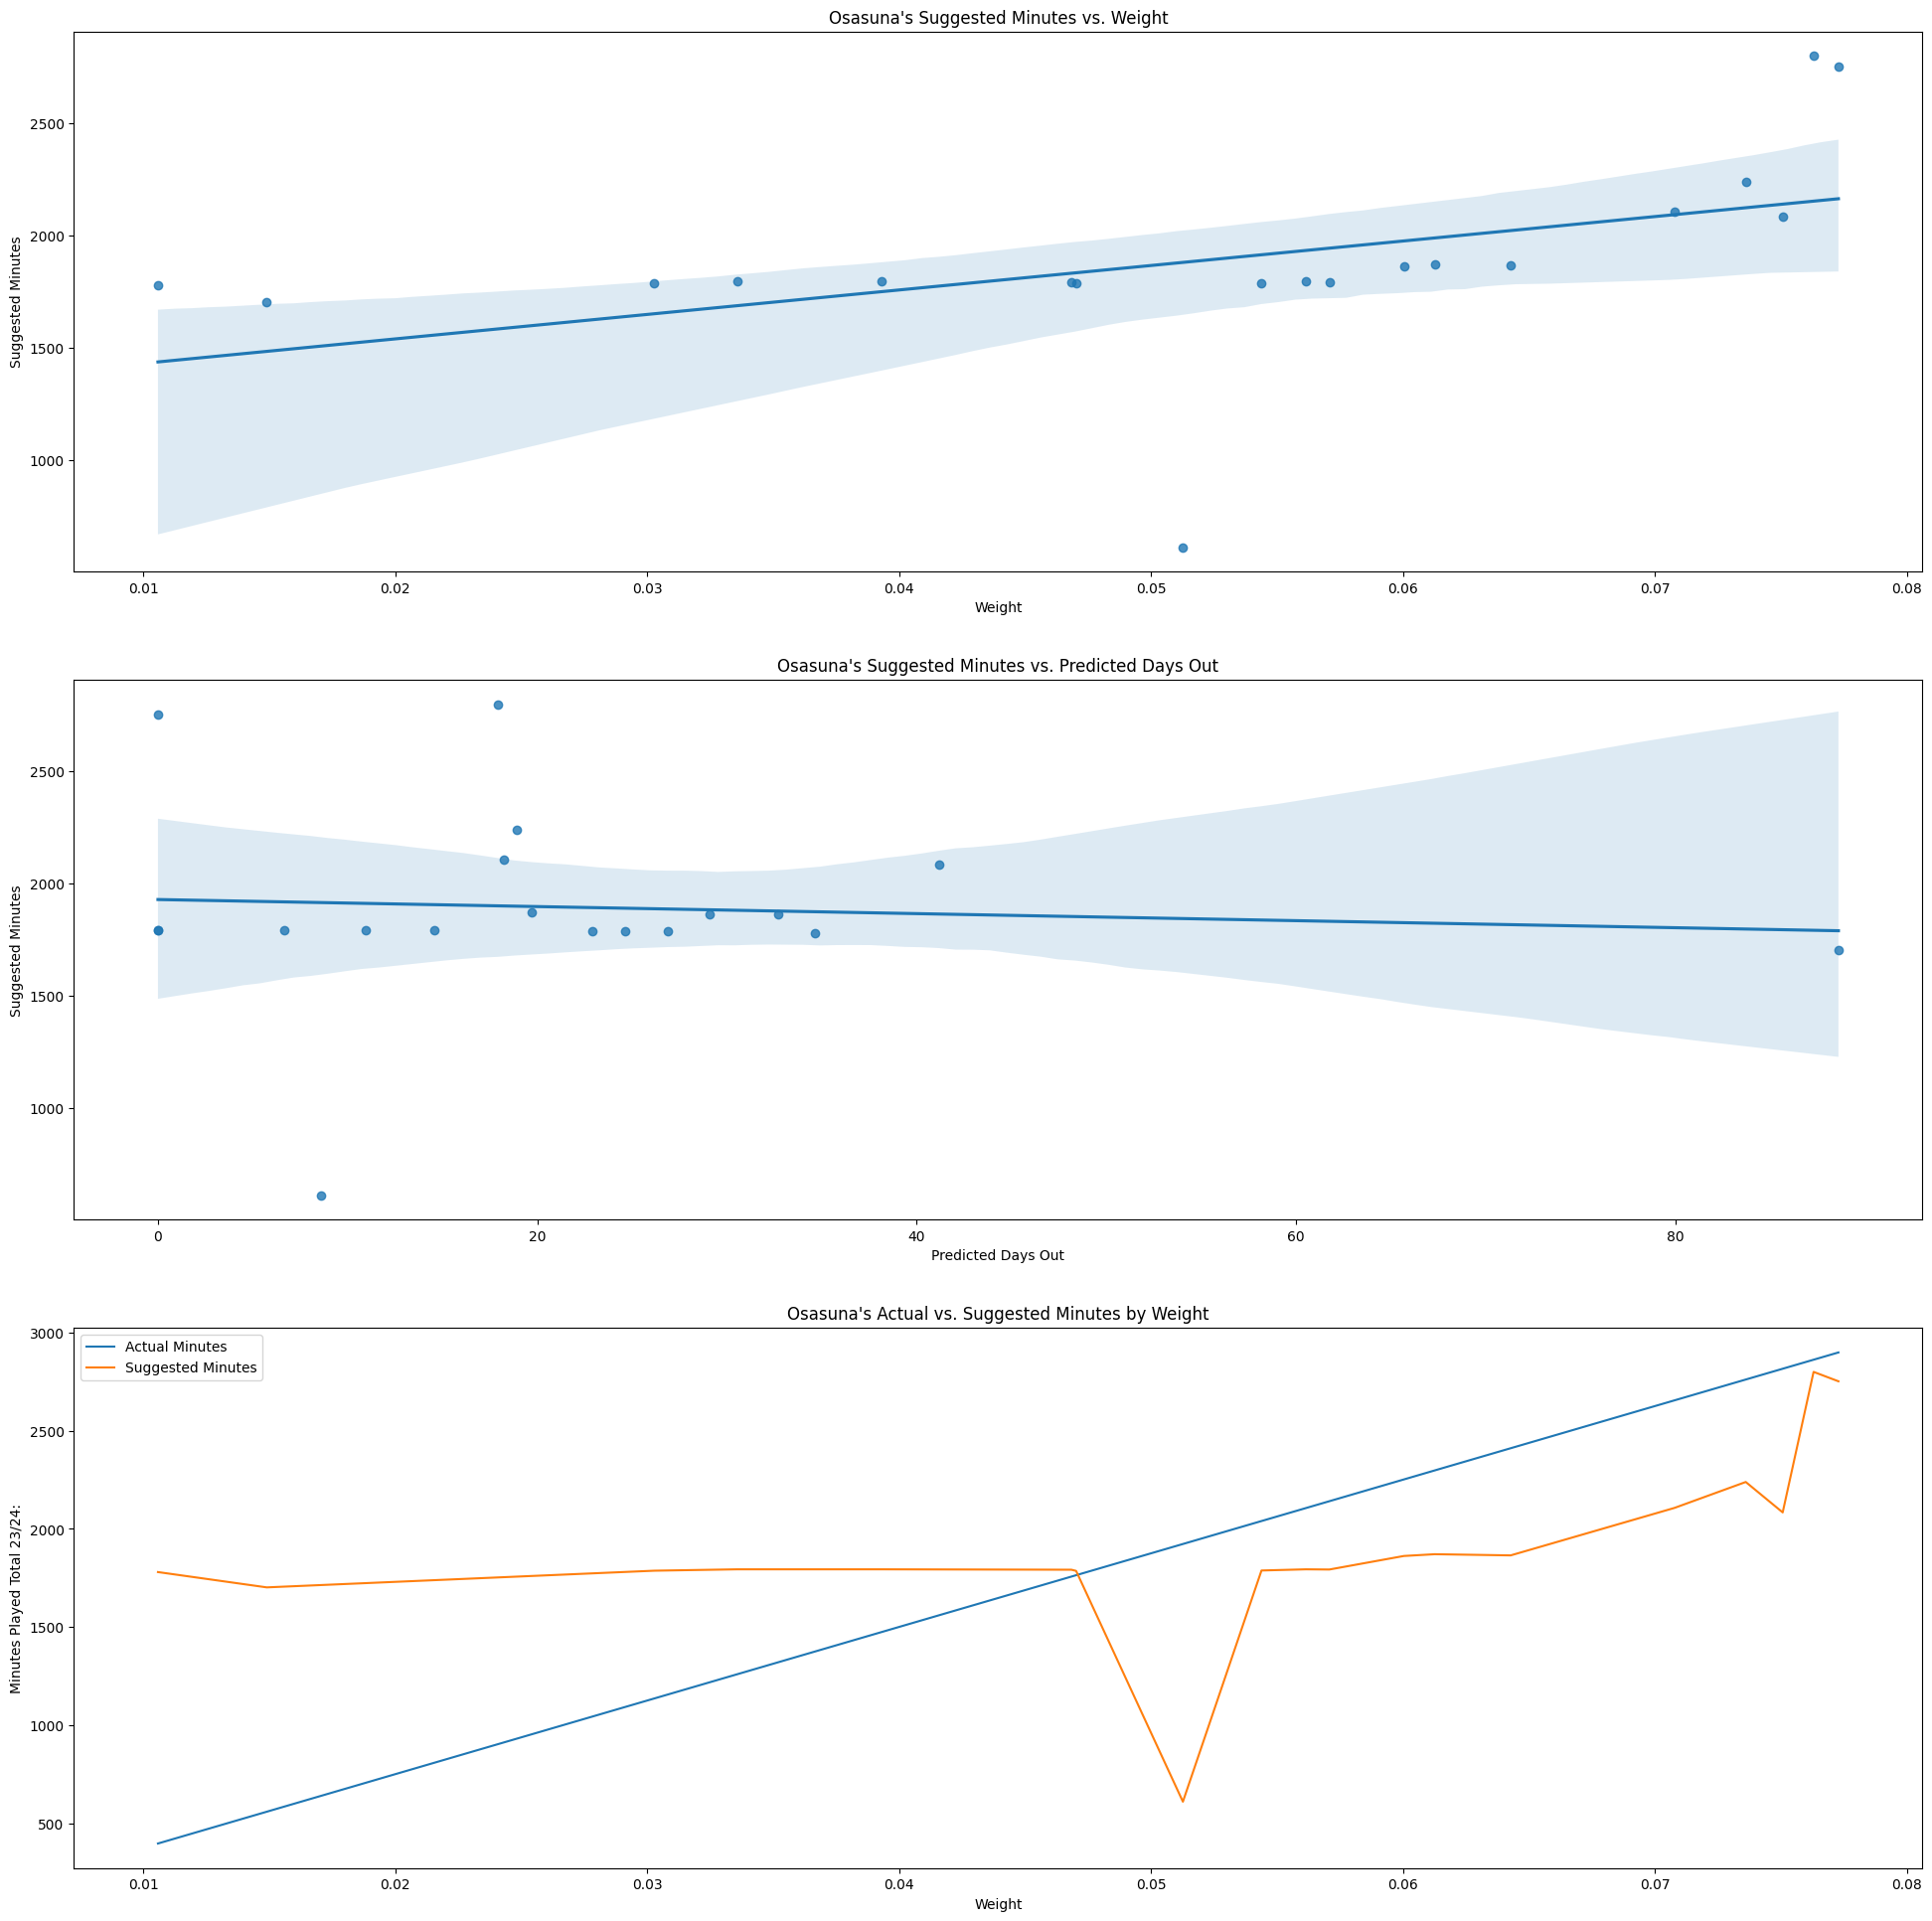

In [214]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=osasuna_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Osasuna's Suggested Minutes vs. Weight")

sns.regplot(data=osasuna_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Osasuna's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=osasuna_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=osasuna_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Osasuna's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Unai García's Suggested Minutes vs. Lambda")

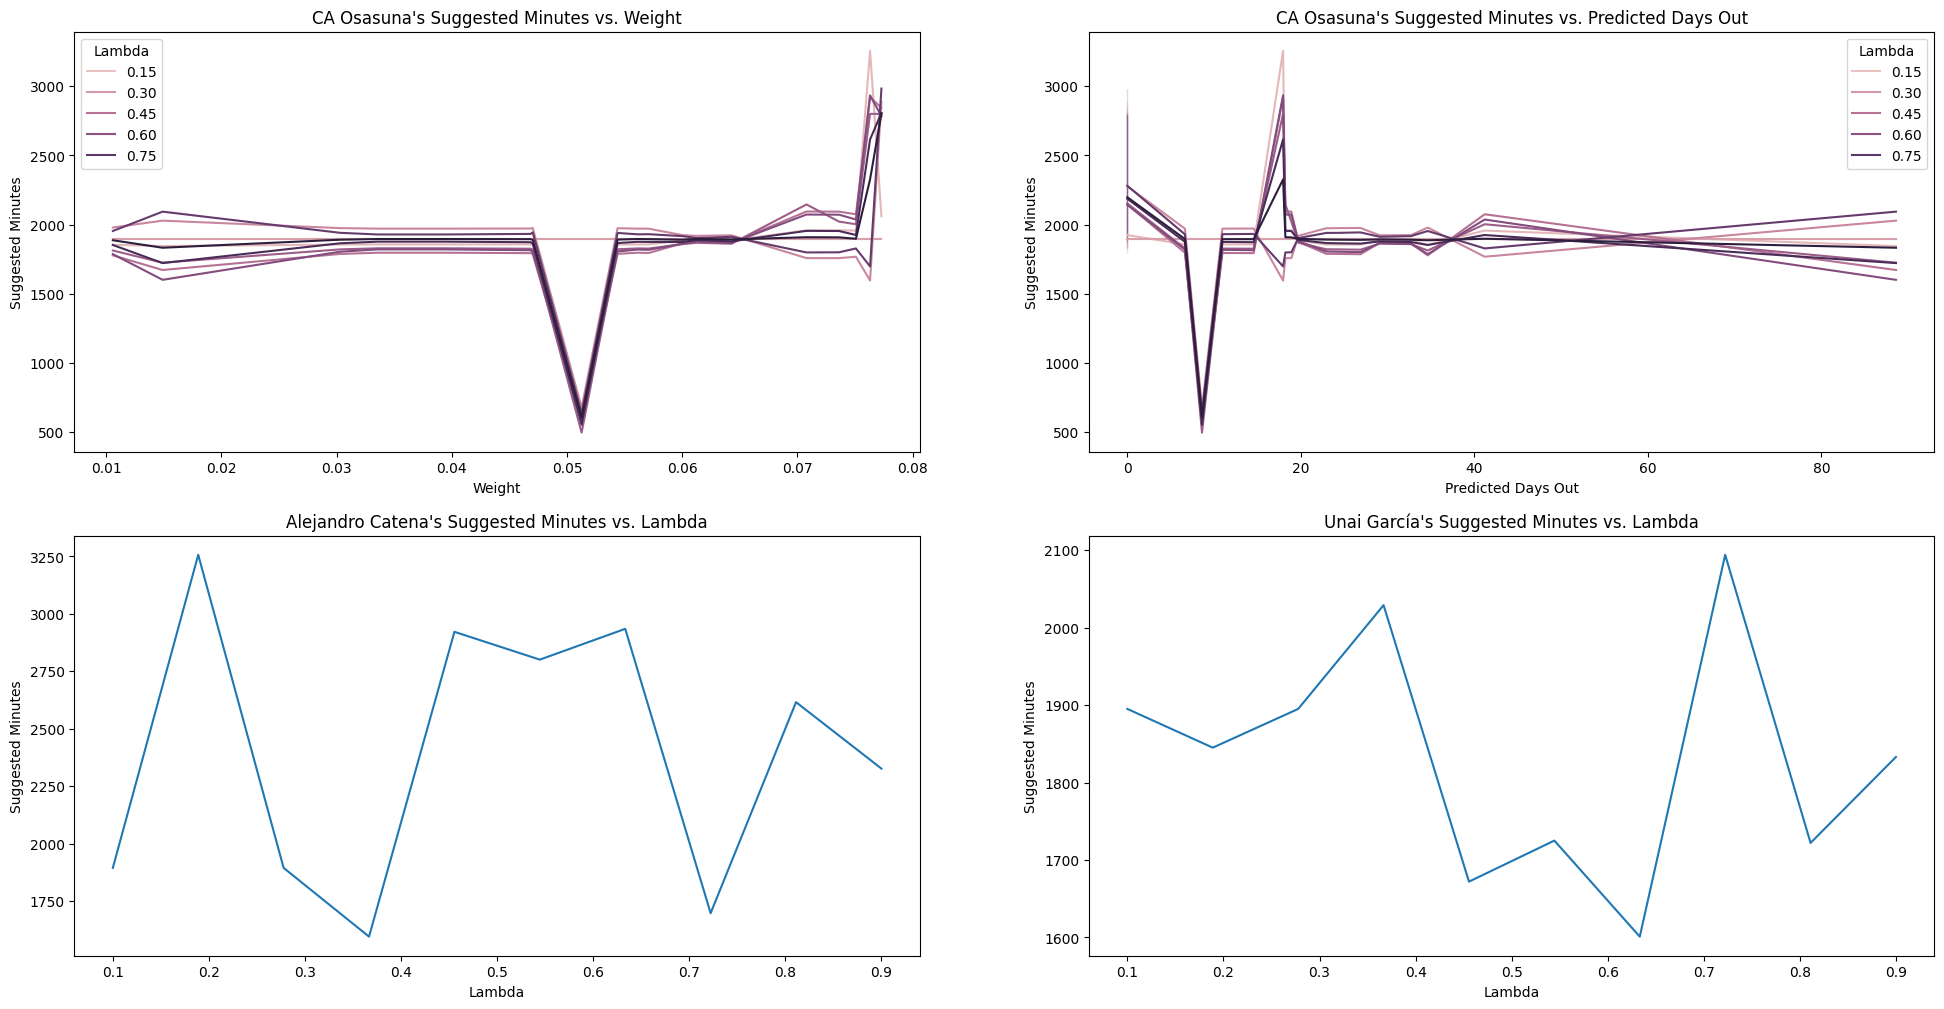

In [187]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('CA Osasuna', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("CA Osasuna's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("CA Osasuna's Suggested Minutes vs. Predicted Days Out")

Catena_df = results_df[results_df['Name'] == 'Alejandro Catena']
sns.lineplot(data=Catena_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Alejandro Catena's Suggested Minutes vs. Lambda")

garcia_df = results_df[results_df['Name'] == 'Unai García']
sns.lineplot(data=garcia_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Unai García's Suggested Minutes vs. Lambda")

### Granada (Bottom)

In [219]:
granada_df = optimise('Granada CF', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=0.6)
granada_df

Name        Club  Age  Minutes Played Total 23/24:  \
735       Bruno Méndez  Granada CF   24                         1336   
736   Kamil Piatkowski  Granada CF   23                         1077   
737      Raúl Torrente  Granada CF   22                         1250   
738      Jesús Vallejo  Granada CF   27                          106   
739      Ignasi Miquel  Granada CF   31                         3006   
740       Miguel Rubio  Granada CF   26                         1560   
741   Faitout Maouassa  Granada CF   25                          645   
742        Carlos Neva  Granada CF   27                         3156   
743     Ricard Sánchez  Granada CF   24                         2299   
744        Víctor Díaz  Granada CF   35                          252   
745      Gerard Gumbau  Granada CF   29                         2714   
746      Martin Hongla  Granada CF   26                         1805   
747     Gonzalo Villar  Granada CF   26                         1841   
748        Sergio Ruiz  Granada CF   29                         2519   
749      Óscar Melendo  Granada CF   26                         1126   
750        Myrto Uzuni  Granada CF   29                         2459   
751      Kamil Jóźwiak  Granada CF   26                          572   
752  Facundo Pellistri  Granada CF   22                         1587   
753    Antonio Puertas  Granada CF   32                          715   
754      Theo Corbeanu  Granada CF   22                         1364   
755      José Callejón  Granada CF   37                          881   
756       Matías Arezo  Granada CF   21                          359   
757         Lucas Boyé  Granada CF   28                         2767   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
735  0.037744           24.527861            1091.2     0.6               1565  
736  0.030427            8.325076             682.0     0.6               1565  
737  0.035315           16.771774             682.0     0.6               1565  
738  0.002995          163.750577               0.0     0.6               1565  
739  0.084925            2.807759            2182.4     0.6               1565  
740  0.044073           17.193781            1091.2     0.6               1565  
741  0.018222           16.771791               0.0     0.6               1565  
742  0.089163            4.111828            2182.4     0.6               1565  
743  0.064951            0.000000            1364.0     0.6               1565  
744  0.007119           53.306429               0.0     0.6               1565  
745  0.076675            0.000000            1773.2     0.6               1565  
746  0.050994            0.742741            1364.0     0.6               1565  
747  0.052012            0.000000            1364.0     0.6               1565  
748  0.071166            0.352159            1773.2     0.6               1565  
749  0.031812            4.209096             682.0     0.6               1565  
750  0.069471            4.142879            1773.2     0.6               1565  
751  0.016160           32.505333               0.0     0.6               1565  
752  0.044836           10.349203            1091.2     0.6               1565  
753  0.020200            7.608153               0.0     0.6               1565  
754  0.038535           15.981357            1091.2     0.6               1565  
755  0.024890           11.393583               0.0     0.6               1565  
756  0.010142           24.833905               0.0     0.6               1565  
757  0.078173           12.804128            2182.4     0.6               1565

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

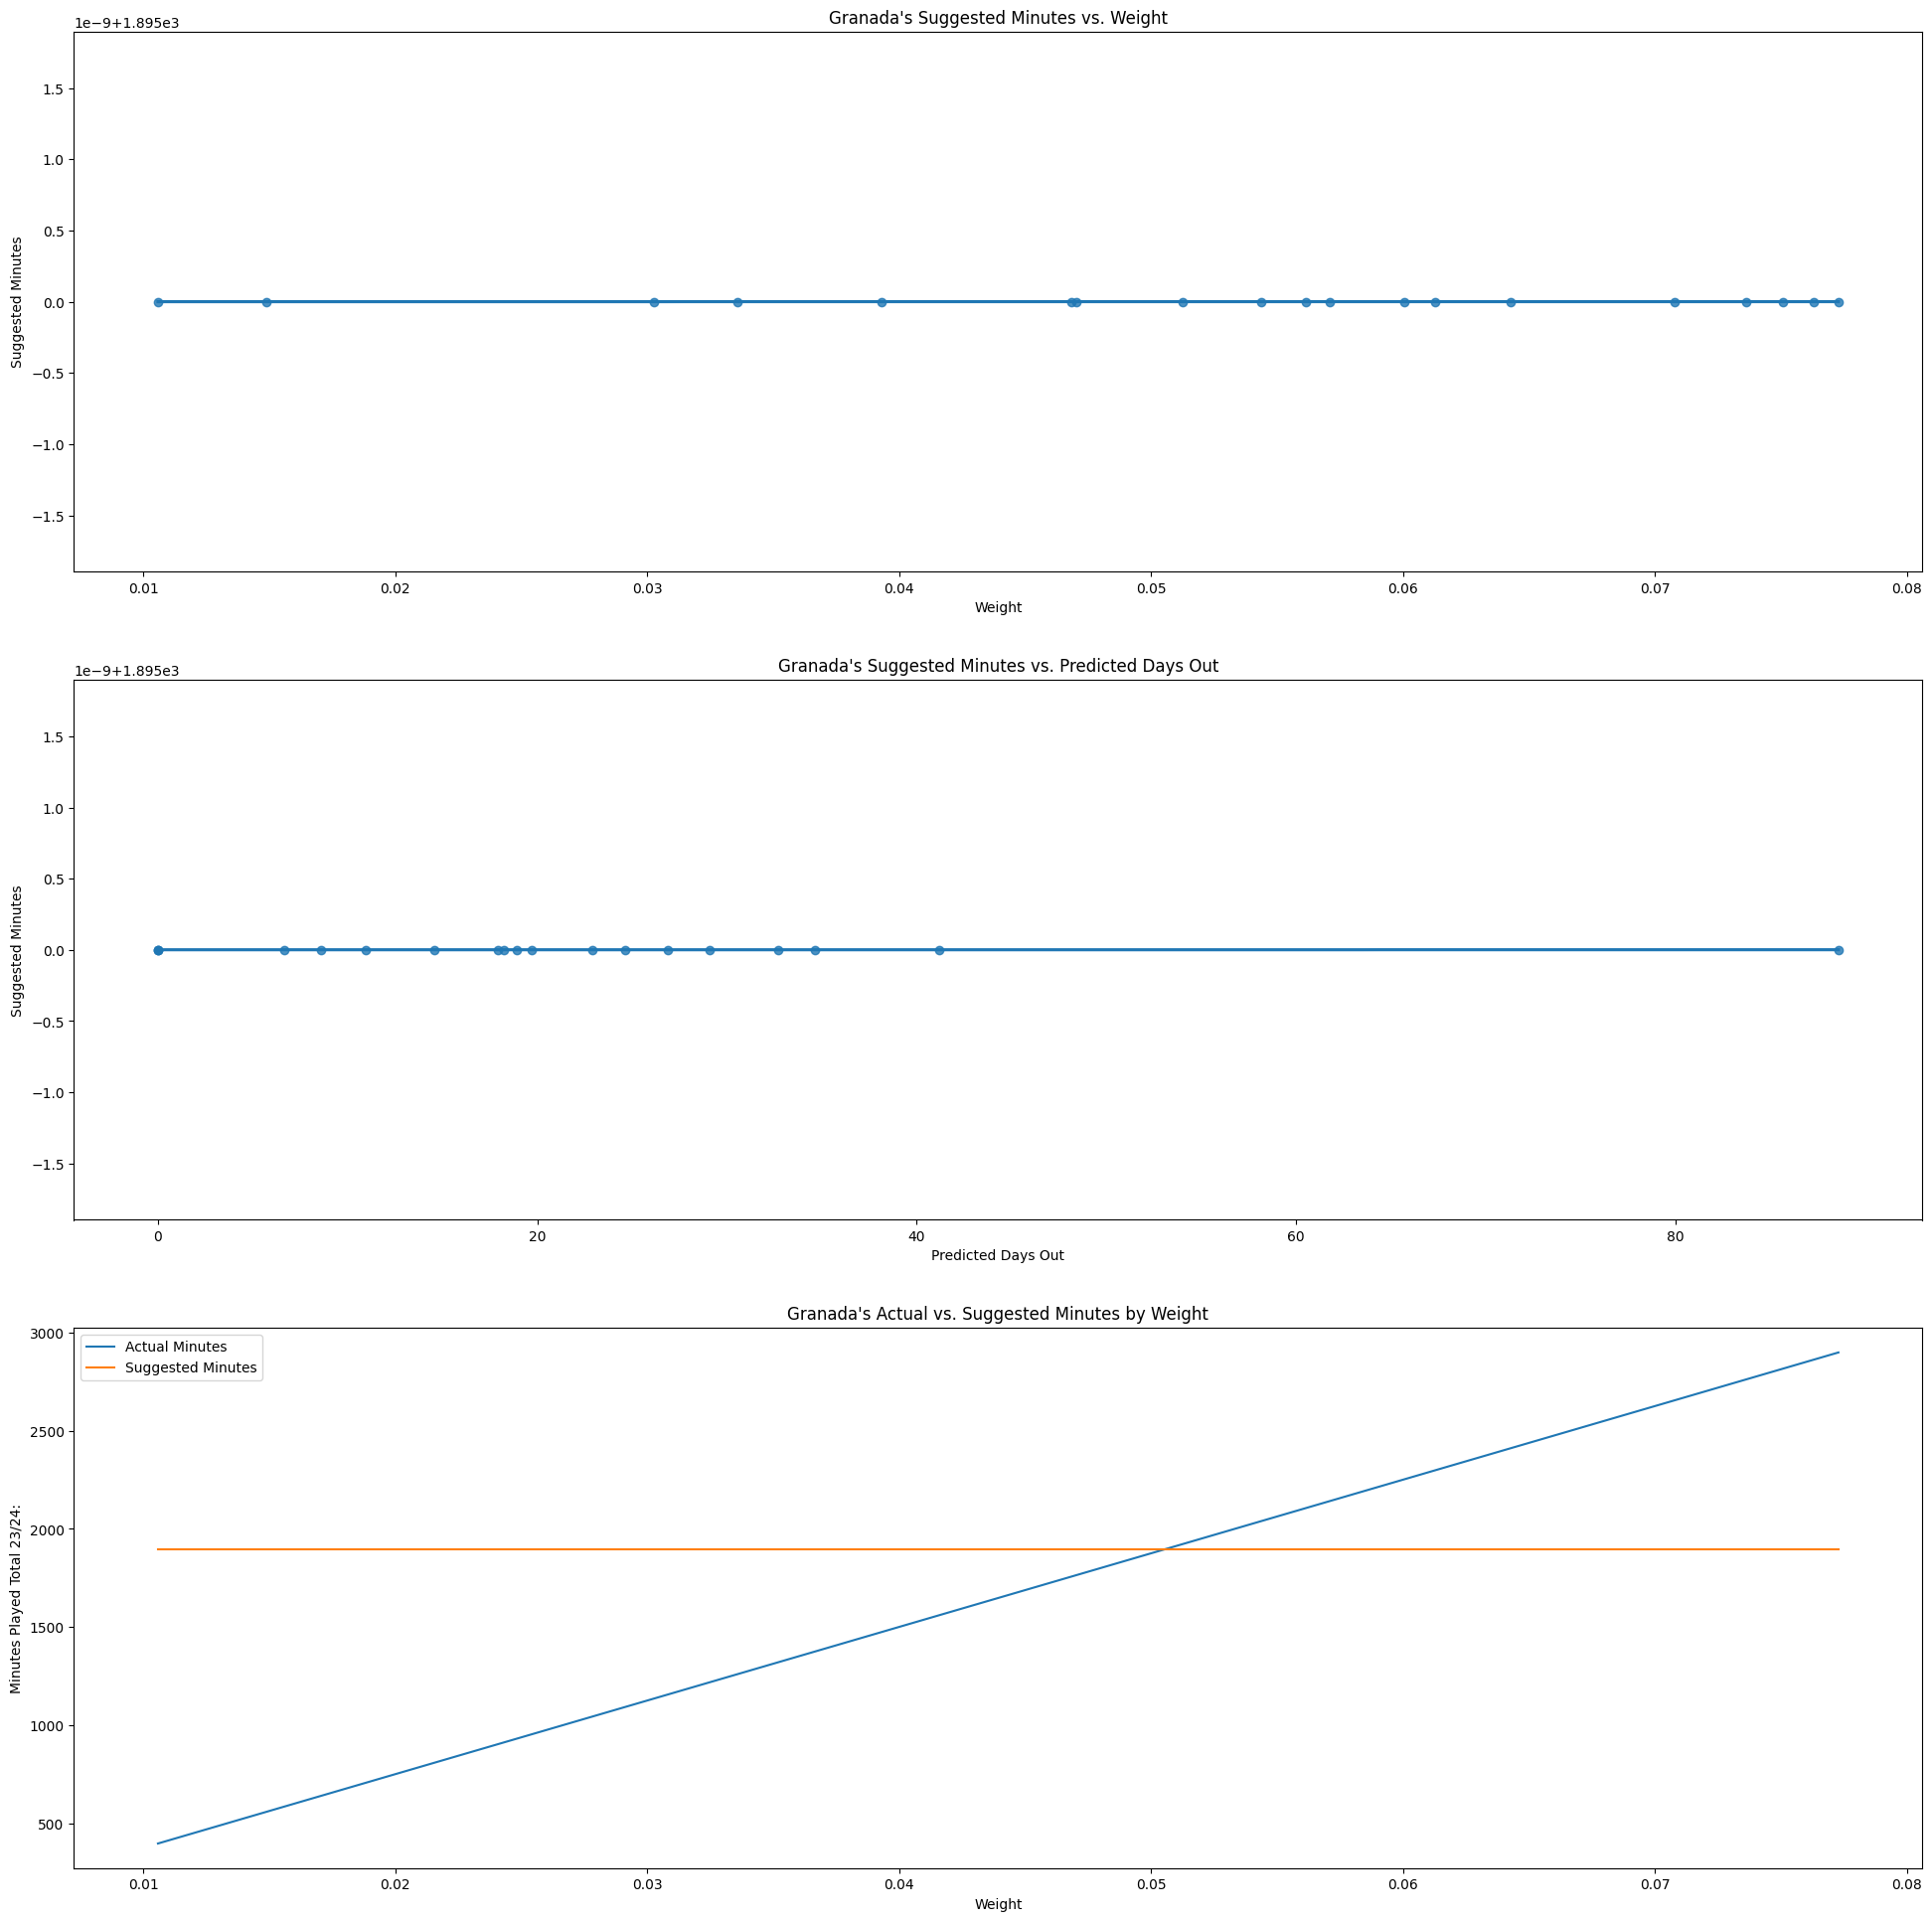

In [189]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=osasuna_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Granada's Suggested Minutes vs. Weight")

sns.regplot(data=osasuna_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Granada's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=osasuna_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=osasuna_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Granada's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [220]:
granada_df = optimise('Granada CF', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=0.1)
granada_df

Name        Club  Age  Minutes Played Total 23/24:  \
735       Bruno Méndez  Granada CF   24                         1336   
736   Kamil Piatkowski  Granada CF   23                         1077   
737      Raúl Torrente  Granada CF   22                         1250   
738      Jesús Vallejo  Granada CF   27                          106   
739      Ignasi Miquel  Granada CF   31                         3006   
740       Miguel Rubio  Granada CF   26                         1560   
741   Faitout Maouassa  Granada CF   25                          645   
742        Carlos Neva  Granada CF   27                         3156   
743     Ricard Sánchez  Granada CF   24                         2299   
744        Víctor Díaz  Granada CF   35                          252   
745      Gerard Gumbau  Granada CF   29                         2714   
746      Martin Hongla  Granada CF   26                         1805   
747     Gonzalo Villar  Granada CF   26                         1841   
748        Sergio Ruiz  Granada CF   29                         2519   
749      Óscar Melendo  Granada CF   26                         1126   
750        Myrto Uzuni  Granada CF   29                         2459   
751      Kamil Jóźwiak  Granada CF   26                          572   
752  Facundo Pellistri  Granada CF   22                         1587   
753    Antonio Puertas  Granada CF   32                          715   
754      Theo Corbeanu  Granada CF   22                         1364   
755      José Callejón  Granada CF   37                          881   
756       Matías Arezo  Granada CF   21                          359   
757         Lucas Boyé  Granada CF   28                         2767   

       Weight  Predicted Days Out  Min Playing Time  Lambda  Suggested Minutes  
735  0.037744           24.527861            1091.2     0.1               1528  
736  0.030427            8.325076             682.0     0.1               1530  
737  0.035315           16.771774             682.0     0.1               1529  
738  0.002995          163.750577               0.0     0.1               1434  
739  0.084925            2.807759            2182.4     0.1               2186  
740  0.044073           17.193781            1091.2     0.1               1529  
741  0.018222           16.771791               0.0     0.1               1529  
742  0.089163            4.111828            2182.4     0.1               2154  
743  0.064951            0.000000            1364.0     0.1               1530  
744  0.007119           53.306429               0.0     0.1               1520  
745  0.076675            0.000000            1773.2     0.1               1829  
746  0.050994            0.742741            1364.0     0.1               1530  
747  0.052012            0.000000            1364.0     0.1               1530  
748  0.071166            0.352159            1773.2     0.1               1820  
749  0.031812            4.209096             682.0     0.1               1530  
750  0.069471            4.142879            1773.2     0.1               1735  
751  0.016160           32.505333               0.0     0.1               1526  
752  0.044836           10.349203            1091.2     0.1               1529  
753  0.020200            7.608153               0.0     0.1               1530  
754  0.038535           15.981357            1091.2     0.1               1529  
755  0.024890           11.393583               0.0     0.1                597  
756  0.010142           24.833905               0.0     0.1                596  
757  0.078173           12.804128            2182.4     0.1               2252

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

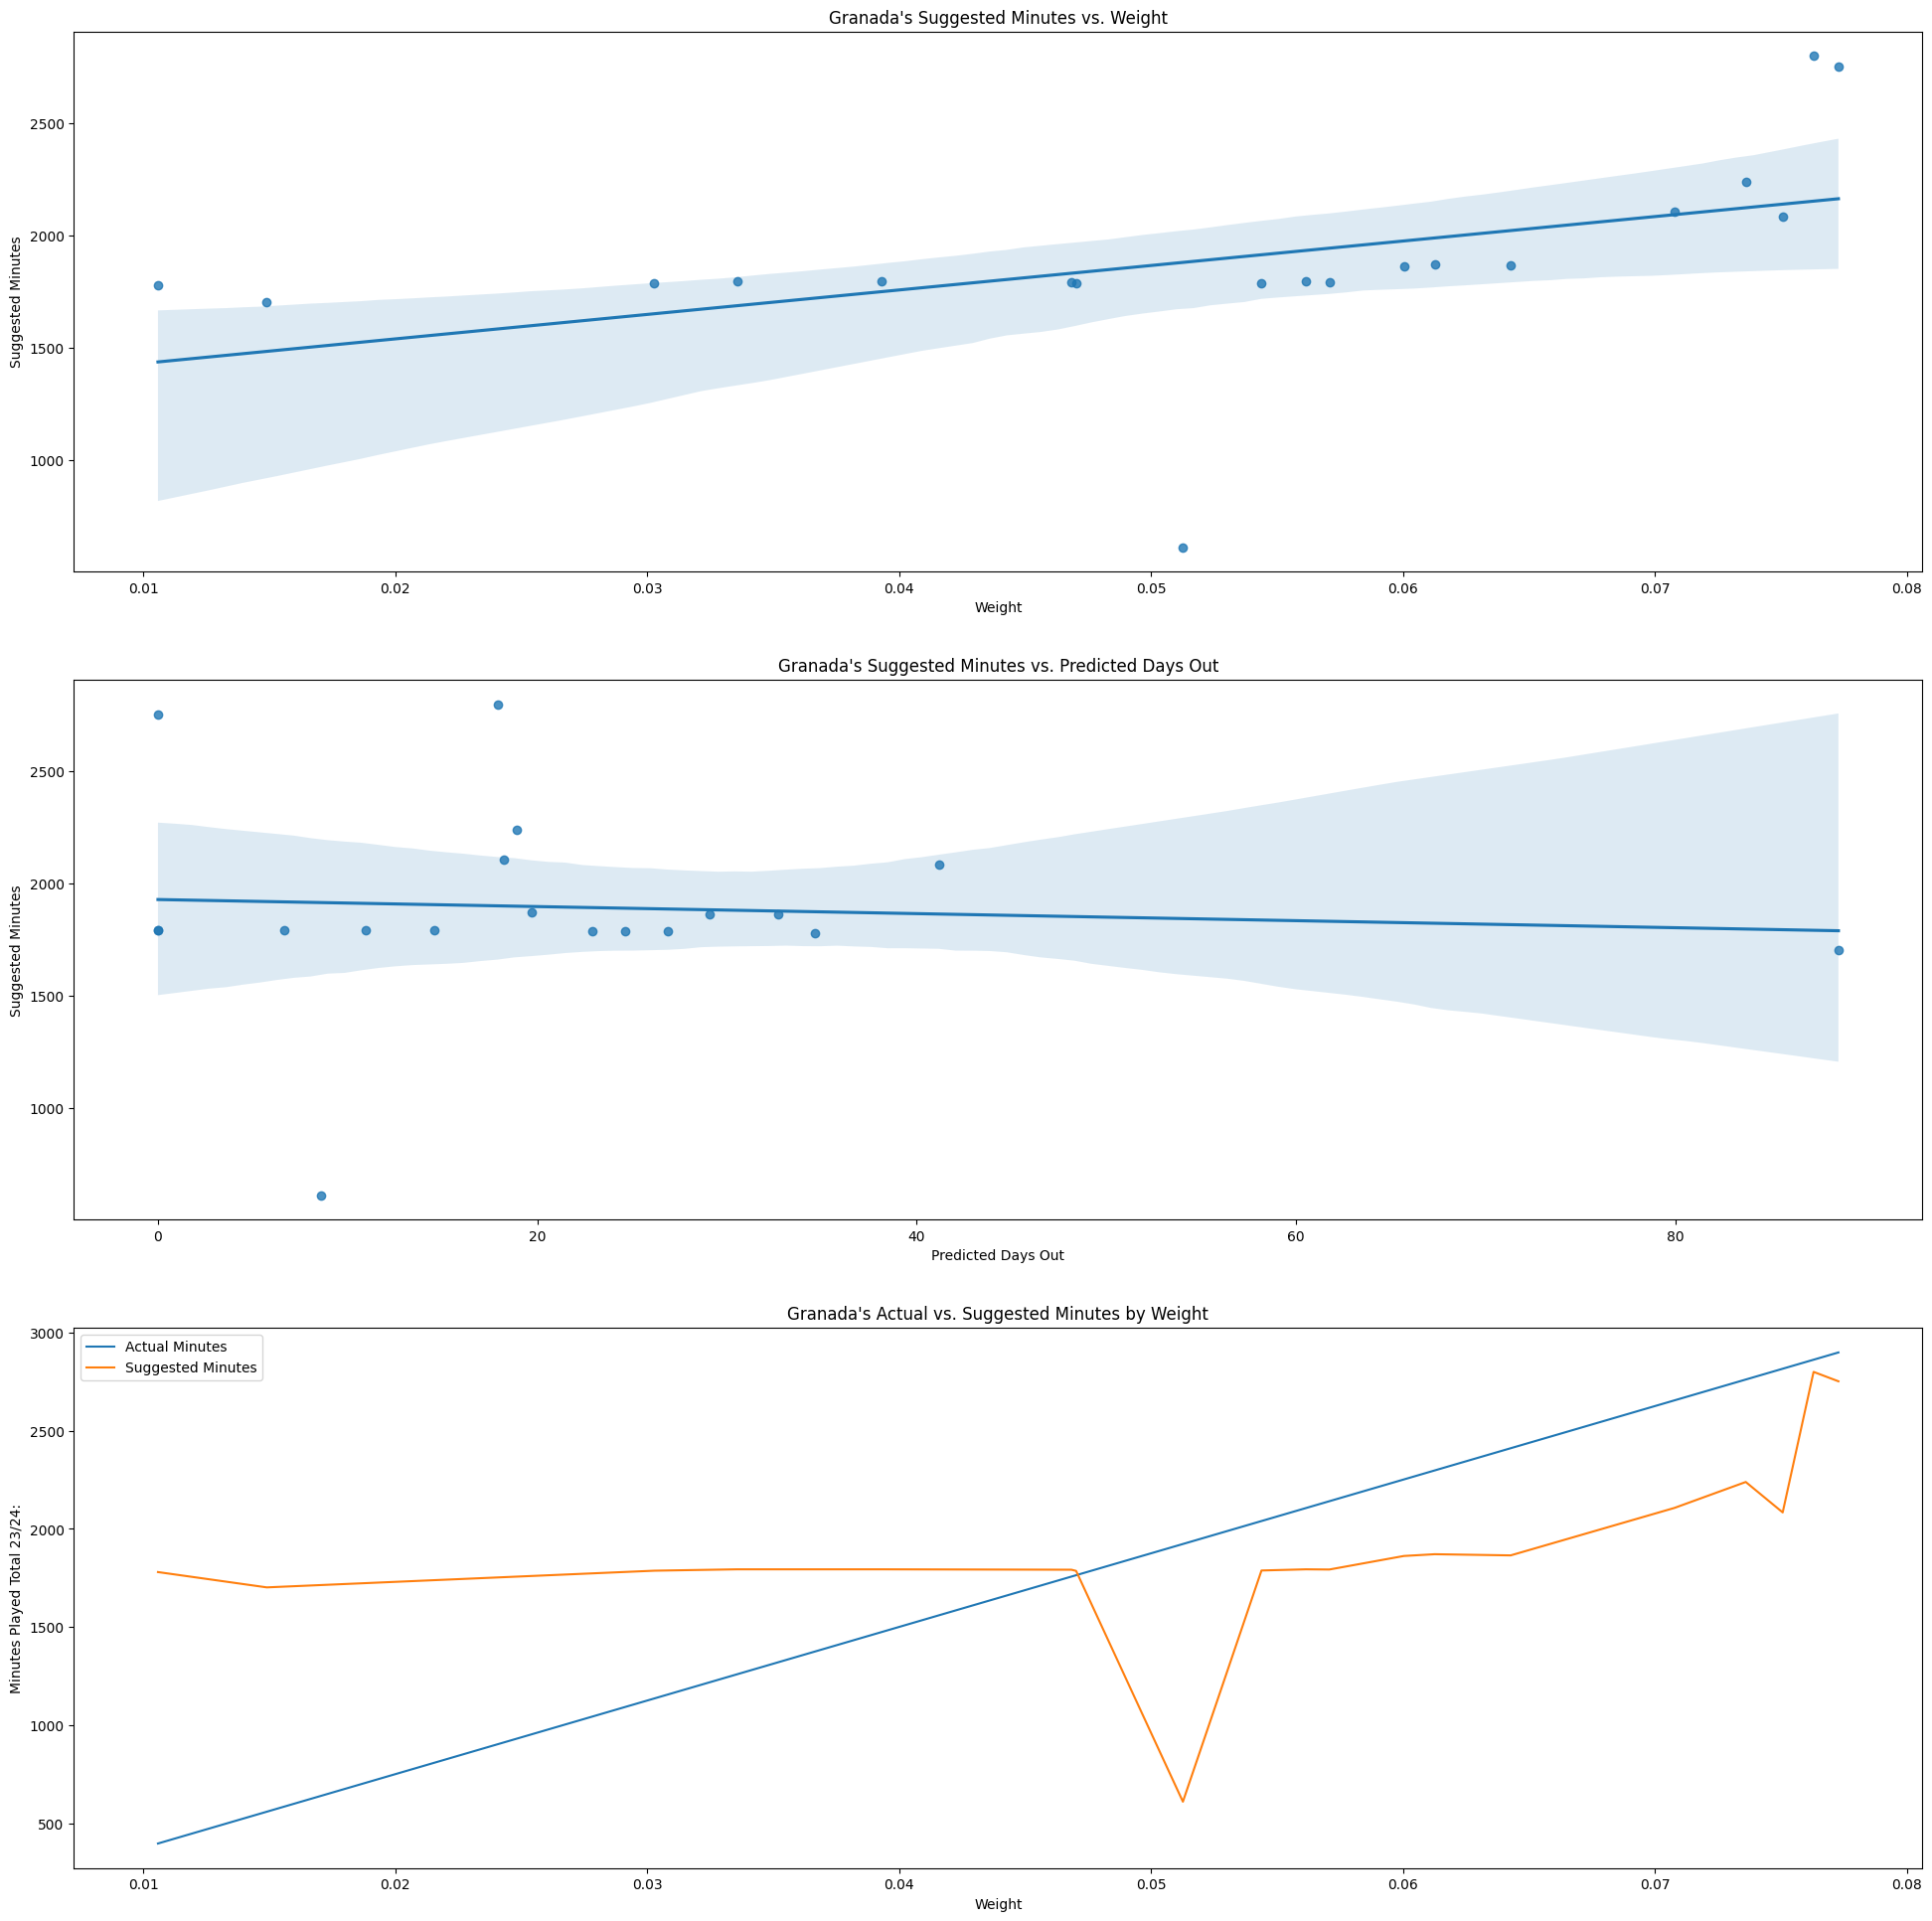

In [221]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=osasuna_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Granada's Suggested Minutes vs. Weight")

sns.regplot(data=osasuna_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Granada's Suggested Minutes vs. Predicted Days Out")

# Create a line plot
sns.lineplot(data=osasuna_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=osasuna_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Granada's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Jesús Vallejo's Suggested Minutes vs. Lambda")

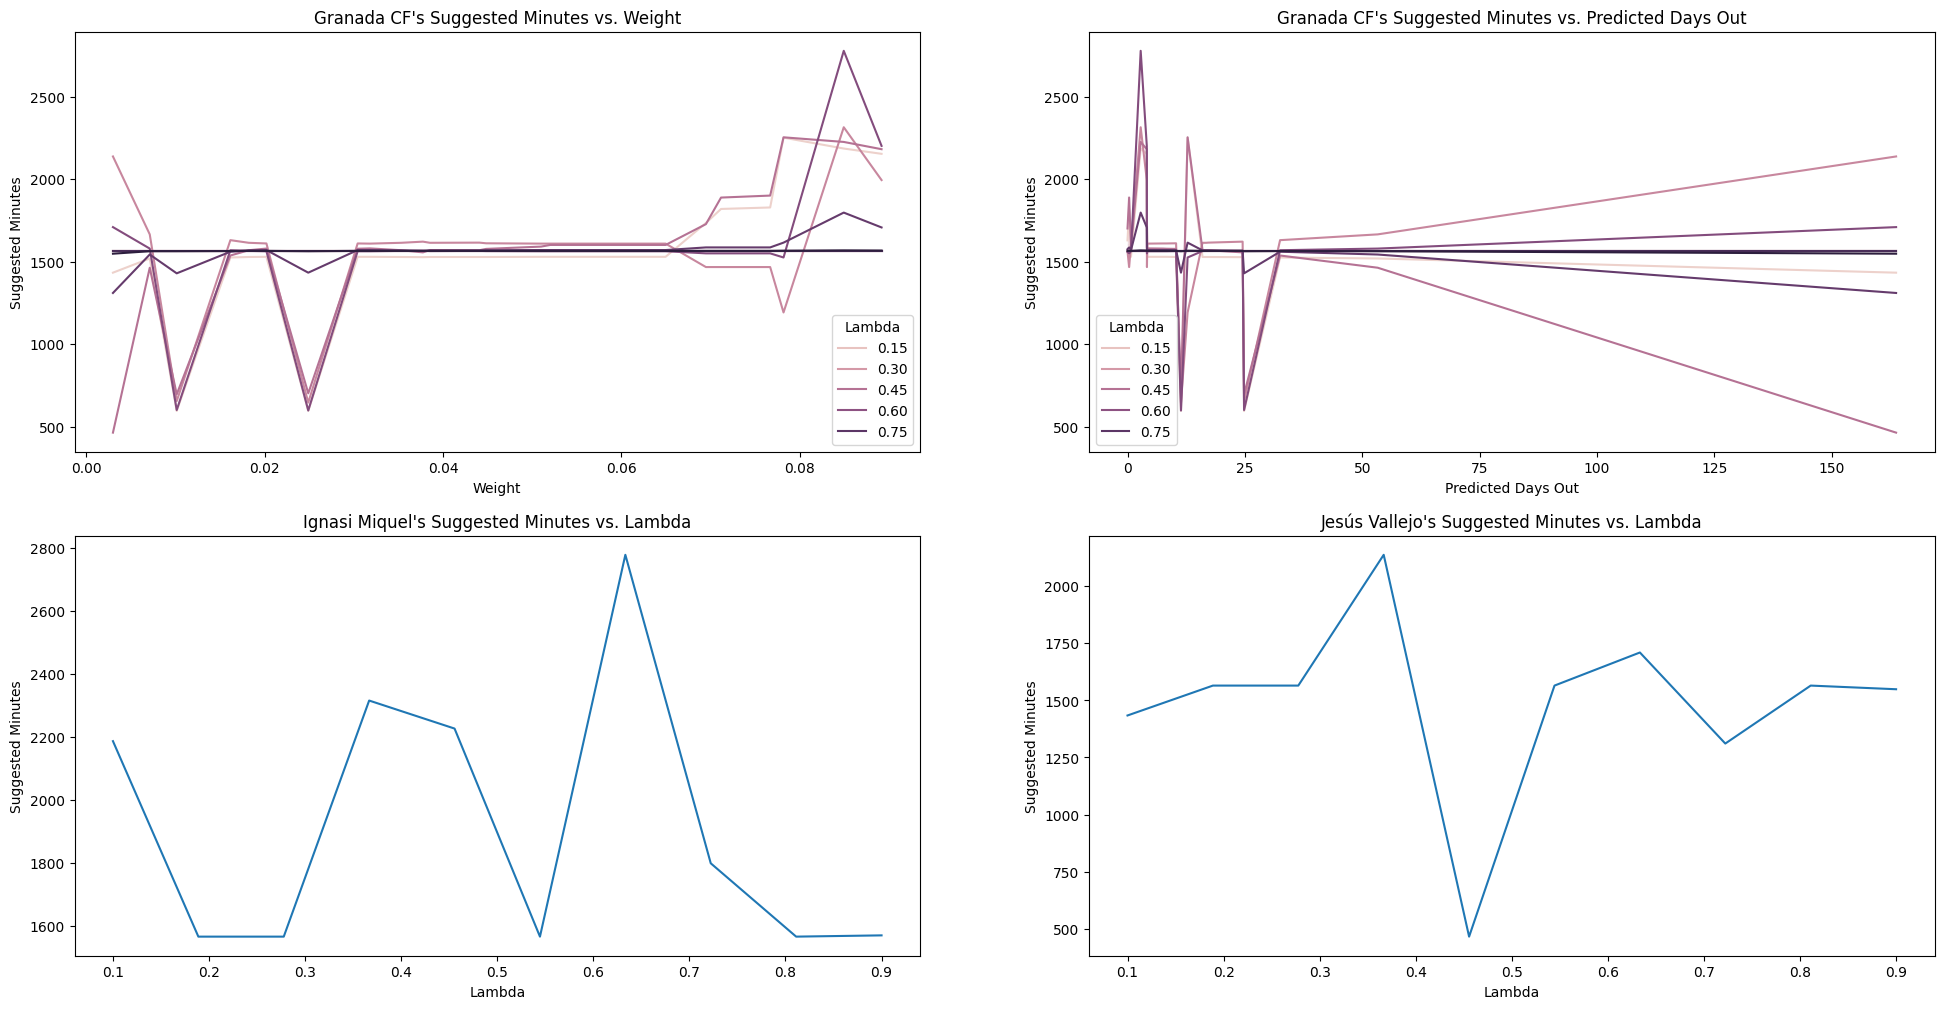

In [192]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Granada CF', total_days_out_mse_prediction_df, games_per_season=40, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Granada CF's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Granada CF's Suggested Minutes vs. Predicted Days Out")

miquel_df = results_df[results_df['Name'] == 'Ignasi Miquel']
sns.lineplot(data=miquel_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Ignasi Miquel's Suggested Minutes vs. Lambda")

vallejo_df = results_df[results_df['Name'] == 'Jesús Vallejo']
sns.lineplot(data=vallejo_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Jesús Vallejo's Suggested Minutes vs. Lambda")

In [193]:
average_injury_cost_mse_prediction_df = pd.read_csv('/kaggle/input/average-injury-cost-predictions/avg_injury_cost_mse_prediction.csv')
injury_count_mse_prediction_df = pd.read_csv('/kaggle/input/injury-count-predictions/injury_count_mse_prediction.csv')
injury_count_cost_combined_df = injury_count_mse_prediction_df
injury_count_cost_combined_df['Predicted Average Injury Cost'] = average_injury_cost_mse_prediction_df['Predicted Average Injury Cost']

In [194]:
injury_count_cost_combined_df.head()

Name    Club  Age  Minutes Played Total 23/24:    Weight  \
0  Tosin Adarabioyo  Fulham   26                         1995  0.041889   
1         Issa Diop  Fulham   27                         1949  0.040923   
2     Calvin Bassey  Fulham   24                         2562  0.053794   
3          Tim Ream  Fulham   36                         1692  0.035527   
4  Antonee Robinson  Fulham   26                         3749  0.078718   

   Predicted Injury Count  Predicted Average Injury Cost  
0                1.894689                       0.295183  
1                2.068261                       0.317022  
2                1.066523                       0.168393  
3                1.387498                       0.210753  
4                0.895854                       0.145121

## When Objective function is based on 'Injury Count' and 'Average Injury Cost'
Given a squad of $n$ players which plays $g$ number of games per season, the objective function is

$\begin{align*} 
    \min \; &\lambda \sum_{i = 1}^{n} w_i y_i c_i x_i + (1 - \lambda)\delta(x_i - \text{ min. playing time})^2\\
    \text{s.t. } &\sum_{i = 1}^{n} x_i = 90 \times 10 \times g\\
    &90 \times l_k \times g \leq x_i \leq 90 \times u_k \times g\\
    & x_i \geq 0
\end{align*}$

where $w_i$ is the **weight (importance)**, $y_i$ is the **predicted injury count**, $c_i$ is the **predicted average injury cost** and $x_i$ is the **minutes played across the whole season** for player $i$. $\lambda$ is the tradeoff term between minimizing injury risk and ensuring performance, while $\delta$ controls the severity of the penalty. 

$l_k$ and $u_k$ are the lower and upper bound of the age group playing time that player $i$ belongs to which by default follows this table:

|    Age Group | Suggested Minutes Lower Bound | Suggested Minutes Upper Bound |
|-------------:|------------------------------:|------------------------------:|
|     16 to 22 |                            15 |                            60 |
|     23 to 35 |                            70 |                            90 |
| 35 and above |                            15 |                            70 |

In other words, given a team of players, we are trying to minimise potential impact of player $i$'s injuries on the team. At the same time, we want to ensure that important players still play a fair amount of games even if their predicted days out due to injury is high. A higher $w_i y_i c_i x_i$ value indicates a greater negative impact due to:

- Higher weight: The player is more important to the team.
- Higher predicted injury count: The player is more likely to be injured multiple times across the season.
- Higher predicted average injury cost: The player's injuries are more likely to be costlier.
- Higher playing time: The player is exposed to more potential injury risks.

By minimizing this objective, the optimization problem seeks to allocate playing time in a way that reduces the overall negative **economic** impact of injuries on the team but still taking into consideration the performance of the team. This can help ensure that the team remains competitive and avoids incurring excessive injury costs.

Note that the variables $g, \; \lambda, \; \delta$ and the age group constraints are adjustable based on the needs of different teams.

In [195]:
def cost_objective_function(x, df, games_per_season, age_ranges, lambda_penalty=0.5):
    """
    Calculates the weighted sum of predicted total days out.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., weights, predicted days out, age).
    games_per_season: Number of games played per season.
    minutes_per_age: Dictionary of minutes limits for different age groups.
    lambda_penalty: Tradeoff control between minimizing injury risk and ensuring playing time.

    Returns:
    The weighted sum of predicted total days out.
    """

    predicted_injury_count = df['Predicted Injury Count'].values
    predicted_injury_cost = df['Predicted Average Injury Cost'].values
    weights = df['Weight'].values
    min_playing_time = df['Min Playing Time'].values
    
    # Calculate penalty term
    penalty = 1000 * np.power(np.maximum(0, min_playing_time - x), 2)
    return lambda_penalty * np.dot(weights, predicted_injury_count * predicted_injury_cost * x) + (1 - lambda_penalty) * (np.sum(penalty))

In [196]:
def optimise_cost(club_name, df, age_ranges=default_age_ranges, games_per_season=50, penalty_lambda=0.5):
    club_players_df = df[df['Club'] == club_name]
    num_players = len(club_players_df)
    total_available_minutes = games_per_season * 90 * 10
    base_min_playing_time = total_available_minutes / num_players
    club_players_df = get_min_playing_times(base_min_playing_time, club_players_df)

    x0 = np.full(num_players, base_min_playing_time)  # Initial guess for playing minutes

    constraints = ({'type': 'eq', 'fun': lambda x: total_playing_time_constraint(x, games_per_season)},
                 {'type': 'ineq', 'fun': lambda x: age_ub_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': lambda x: age_lb_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': non_negative_constraint})

    # Solve the optimization problem
    result = minimize(cost_objective_function, x0, args=(club_players_df, games_per_season, age_ranges, penalty_lambda), method='SLSQP', constraints=constraints)

    optimal_playing_minutes = result.x
    rounded_optimal_playing_minutes = [round(value) for value in optimal_playing_minutes]
    club_players_df['Lambda'] = penalty_lambda  # Store the used lambda value for each player
    club_players_df['Suggested Minutes'] = rounded_optimal_playing_minutes
    return club_players_df

## Lambda as the variable

In [197]:
man_city_cost_df = optimise_cost('Man City', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=0.9)
man_city_cost_df

Name      Club  Age  Minutes Played Total 23/24:  \
198             Rúben Dias  Man City   27                         3817   
199          Manuel Akanji  Man City   28                         3861   
200             Nathan Aké  Man City   29                         3053   
201            John Stones  Man City   30                         1858   
202  Taylor Harwood-Bellis  Man City   22                         3942   
203         Josko Gvardiol  Man City   22                         3479   
204           Sergio Gómez  Man City   23                          445   
205    Josh Wilson-Esbrand  Man City   21                         1248   
206             Rico Lewis  Man City   19                         1606   
207            Kyle Walker  Man City   34                         4083   
208            Issa Kaboré  Man City   23                         1788   
209                  Rodri  Man City   27                         4327   
210          Matheus Nunes  Man City   25                         1540   
211          Mateo Kovacic  Man City   30                         2711   
212           James McAtee  Man City   21                         1942   
213         Bernardo Silva  Man City   29                         3797   
214        Kevin De Bruyne  Man City   32                         1750   
215            Jérémy Doku  Man City   22                         2281   
216          Jack Grealish  Man City   28                         2114   
217             Phil Foden  Man City   24                         4274   
218             Oscar Bobb  Man City   20                          815   
219         Erling Haaland  Man City   23                         3745   
220         Julián Álvarez  Man City   24                         3479   

       Weight  Predicted Injury Count  Predicted Average Injury Cost  \
198  0.061609                0.418027                       0.077455   
199  0.062319                0.599638                       0.114154   
200  0.049278                0.837909                       0.139480   
201  0.029990                1.071749                       0.187607   
202  0.063627                0.359863                       0.077122   
203  0.056154                0.790046                       0.125385   
204  0.007183                1.006816                       0.182618   
205  0.020144                0.921236                       0.160586   
206  0.025922                0.407508                       0.073580   
207  0.065903                0.820027                       0.154623   
208  0.028860                1.289181                       0.201566   
209  0.069841                0.250853                       0.058731   
210  0.024857                0.992535                       0.194226   
211  0.043758                1.027237                       0.184190   
212  0.031345                0.943255                       0.188612   
213  0.061286                0.808551                       0.161583   
214  0.028246                2.345621                       0.423790   
215  0.036817                0.569870                       0.154336   
216  0.034122                1.222872                       0.225746   
217  0.068986                0.293307                       0.072529   
218  0.013155                0.647750                       0.184204   
219  0.060447                0.620467                       0.143507   
220  0.056154                0.243447                       0.056055   

     Min Playing Time  Lambda  Suggested Minutes  
198            3524.3     0.9               2405  
199            3524.3     0.9               2410  
200            2168.8     0.9               2355  
201            1355.5     0.9               2355  
202            3524.3     0.9               2405  
203            2711.0     0.9               2349  
204               0.0     0.9               2355  
205               0.0     0.9                899  
206               0.0     0.9                899  
207   

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

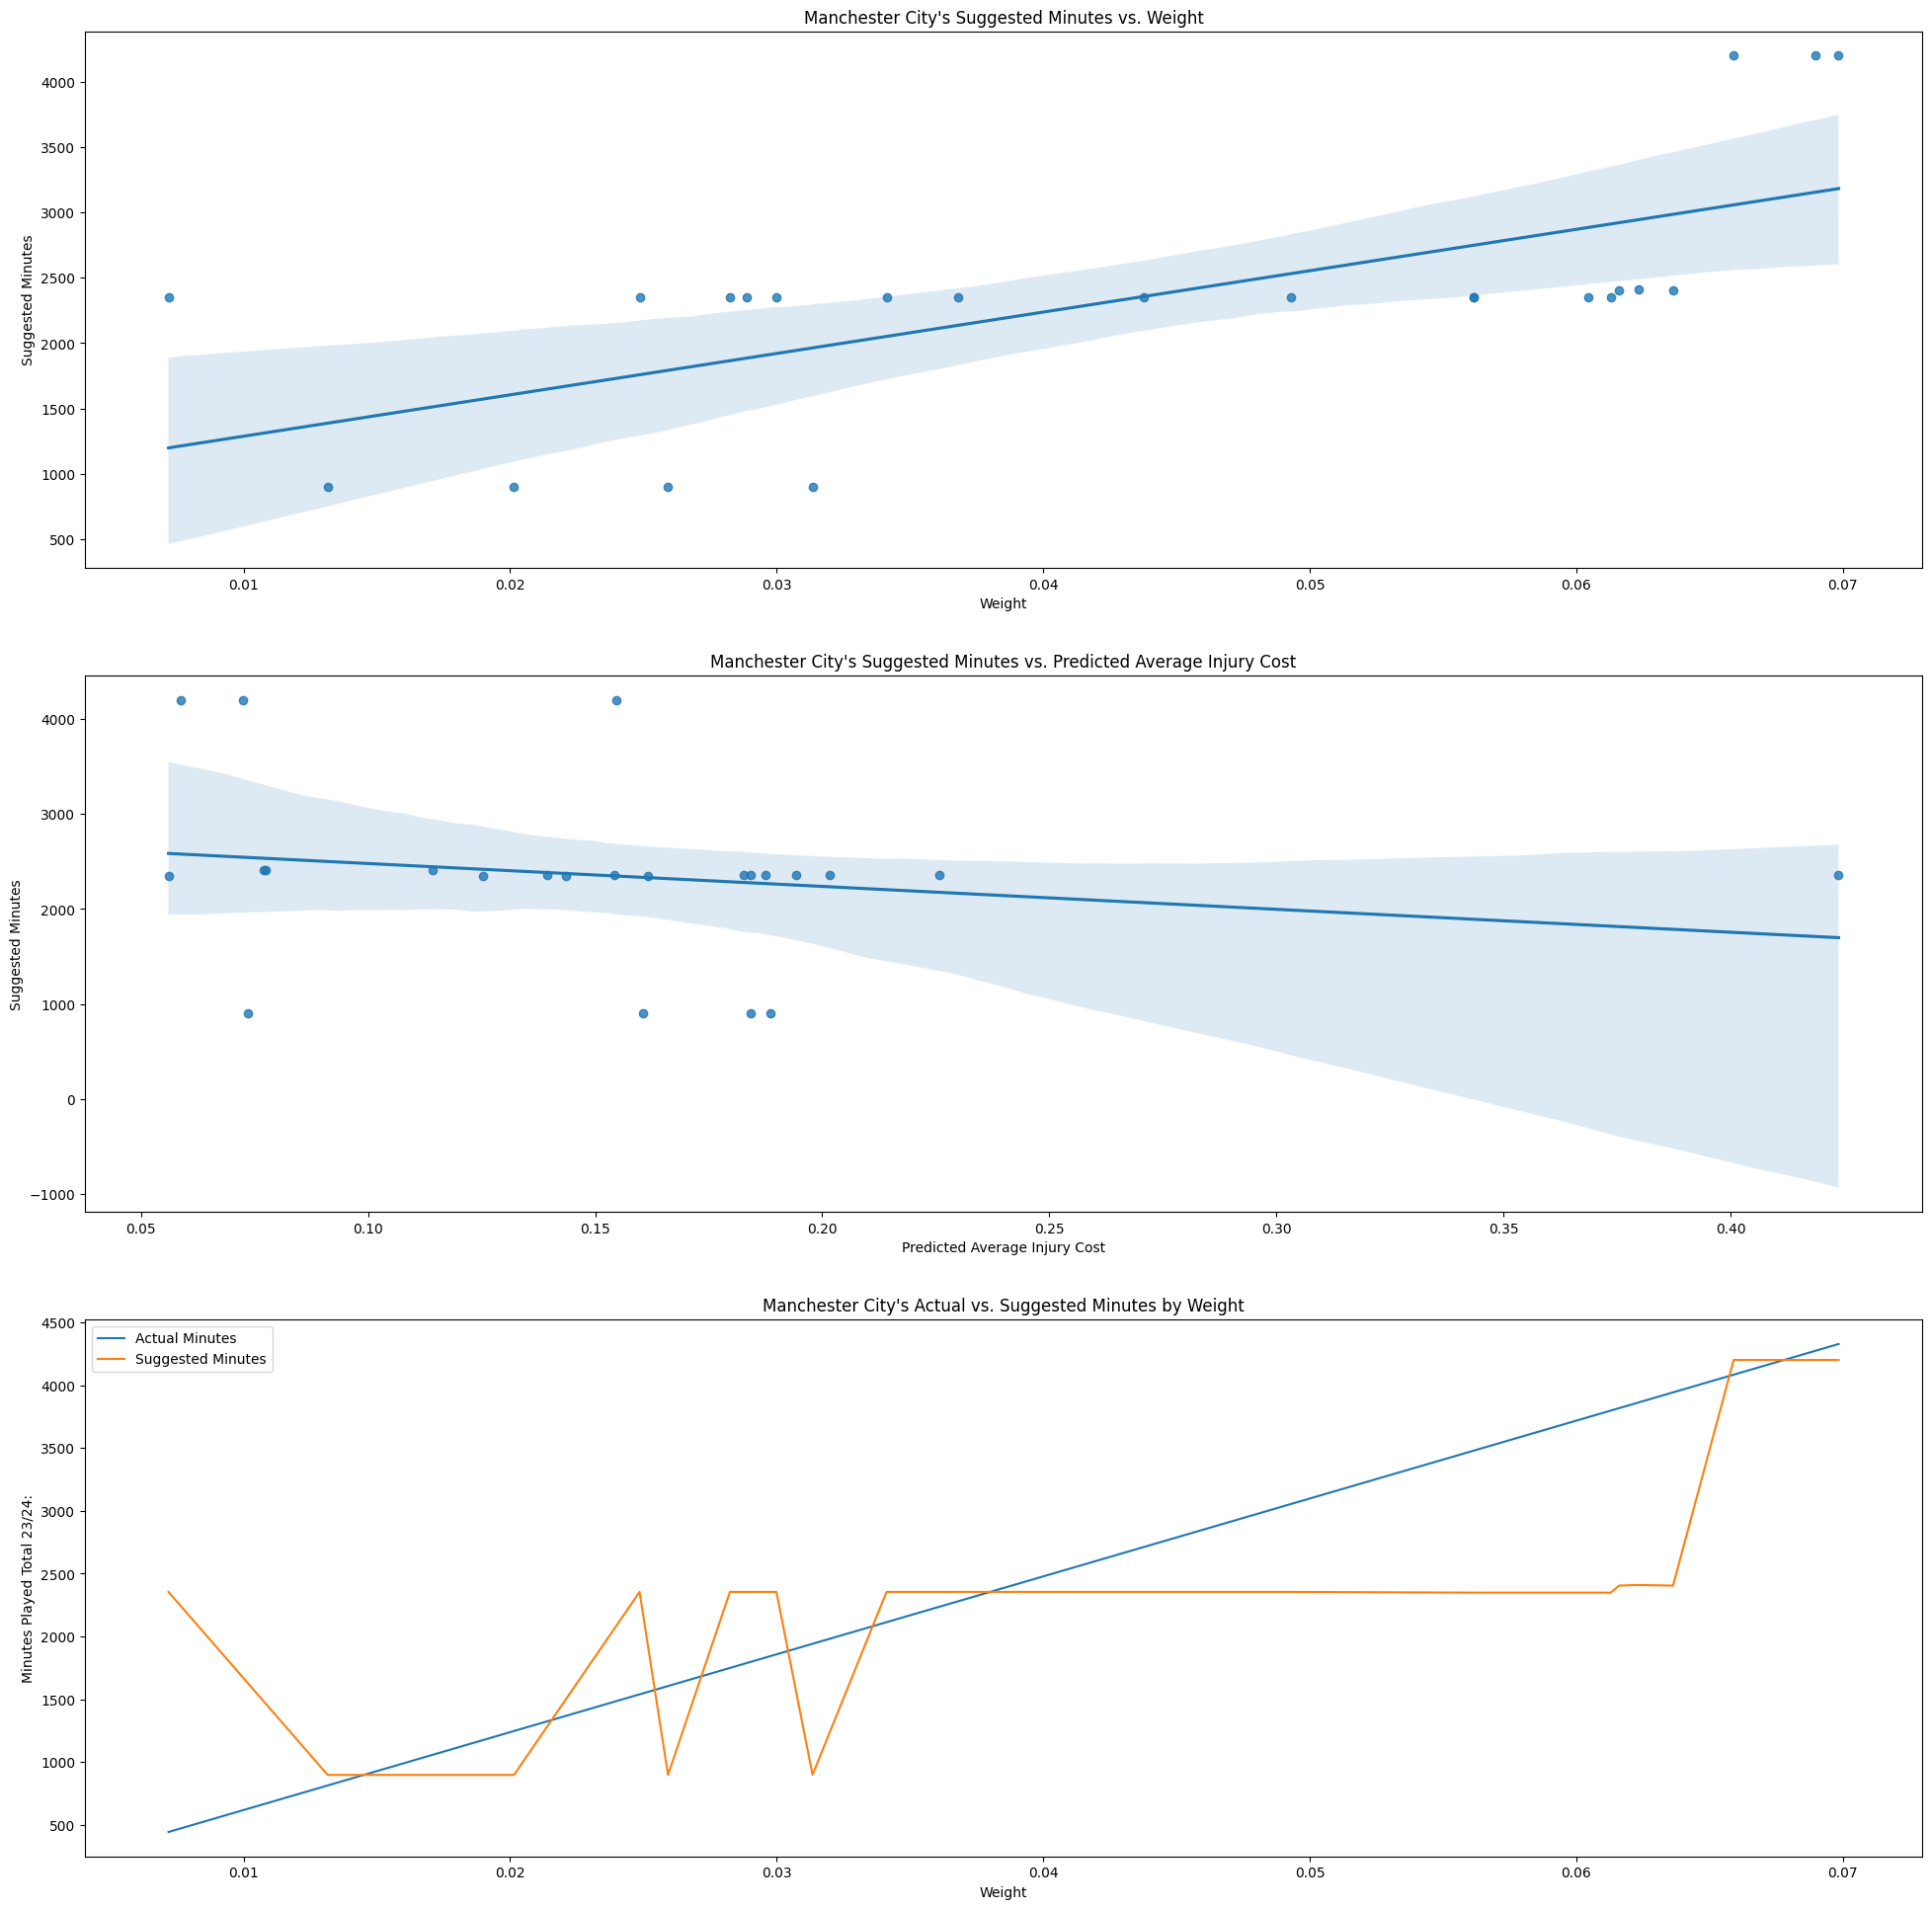

In [198]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=man_city_cost_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Manchester City's Suggested Minutes vs. Weight")

sns.regplot(data=man_city_cost_df, x='Predicted Average Injury Cost', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Manchester City's Suggested Minutes vs. Predicted Average Injury Cost")

# Create a line plot
sns.lineplot(data=man_city_cost_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=man_city_cost_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Manchester City's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [199]:
man_city_cost_df = optimise_cost('Man City', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=0.2)
man_city_cost_df

Name      Club  Age  Minutes Played Total 23/24:  \
198             Rúben Dias  Man City   27                         3817   
199          Manuel Akanji  Man City   28                         3861   
200             Nathan Aké  Man City   29                         3053   
201            John Stones  Man City   30                         1858   
202  Taylor Harwood-Bellis  Man City   22                         3942   
203         Josko Gvardiol  Man City   22                         3479   
204           Sergio Gómez  Man City   23                          445   
205    Josh Wilson-Esbrand  Man City   21                         1248   
206             Rico Lewis  Man City   19                         1606   
207            Kyle Walker  Man City   34                         4083   
208            Issa Kaboré  Man City   23                         1788   
209                  Rodri  Man City   27                         4327   
210          Matheus Nunes  Man City   25                         1540   
211          Mateo Kovacic  Man City   30                         2711   
212           James McAtee  Man City   21                         1942   
213         Bernardo Silva  Man City   29                         3797   
214        Kevin De Bruyne  Man City   32                         1750   
215            Jérémy Doku  Man City   22                         2281   
216          Jack Grealish  Man City   28                         2114   
217             Phil Foden  Man City   24                         4274   
218             Oscar Bobb  Man City   20                          815   
219         Erling Haaland  Man City   23                         3745   
220         Julián Álvarez  Man City   24                         3479   

       Weight  Predicted Injury Count  Predicted Average Injury Cost  \
198  0.061609                0.418027                       0.077455   
199  0.062319                0.599638                       0.114154   
200  0.049278                0.837909                       0.139480   
201  0.029990                1.071749                       0.187607   
202  0.063627                0.359863                       0.077122   
203  0.056154                0.790046                       0.125385   
204  0.007183                1.006816                       0.182618   
205  0.020144                0.921236                       0.160586   
206  0.025922                0.407508                       0.073580   
207  0.065903                0.820027                       0.154623   
208  0.028860                1.289181                       0.201566   
209  0.069841                0.250853                       0.058731   
210  0.024857                0.992535                       0.194226   
211  0.043758                1.027237                       0.184190   
212  0.031345                0.943255                       0.188612   
213  0.061286                0.808551                       0.161583   
214  0.028246                2.345621                       0.423790   
215  0.036817                0.569870                       0.154336   
216  0.034122                1.222872                       0.225746   
217  0.068986                0.293307                       0.072529   
218  0.013155                0.647750                       0.184204   
219  0.060447                0.620467                       0.143507   
220  0.056154                0.243447                       0.056055   

     Min Playing Time  Lambda  Suggested Minutes  
198            3524.3     0.2               3978  
199            3524.3     0.2               3978  
200            2168.8     0.2               2000  
201            1355.5     0.2               2205  
202            3524.3     0.2               3978  
203            2711.0     0.2               2221  
204               0.0     0.2               2205  
205               0.0     0.2                736  
206               0.0     0.2                736  
207   

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

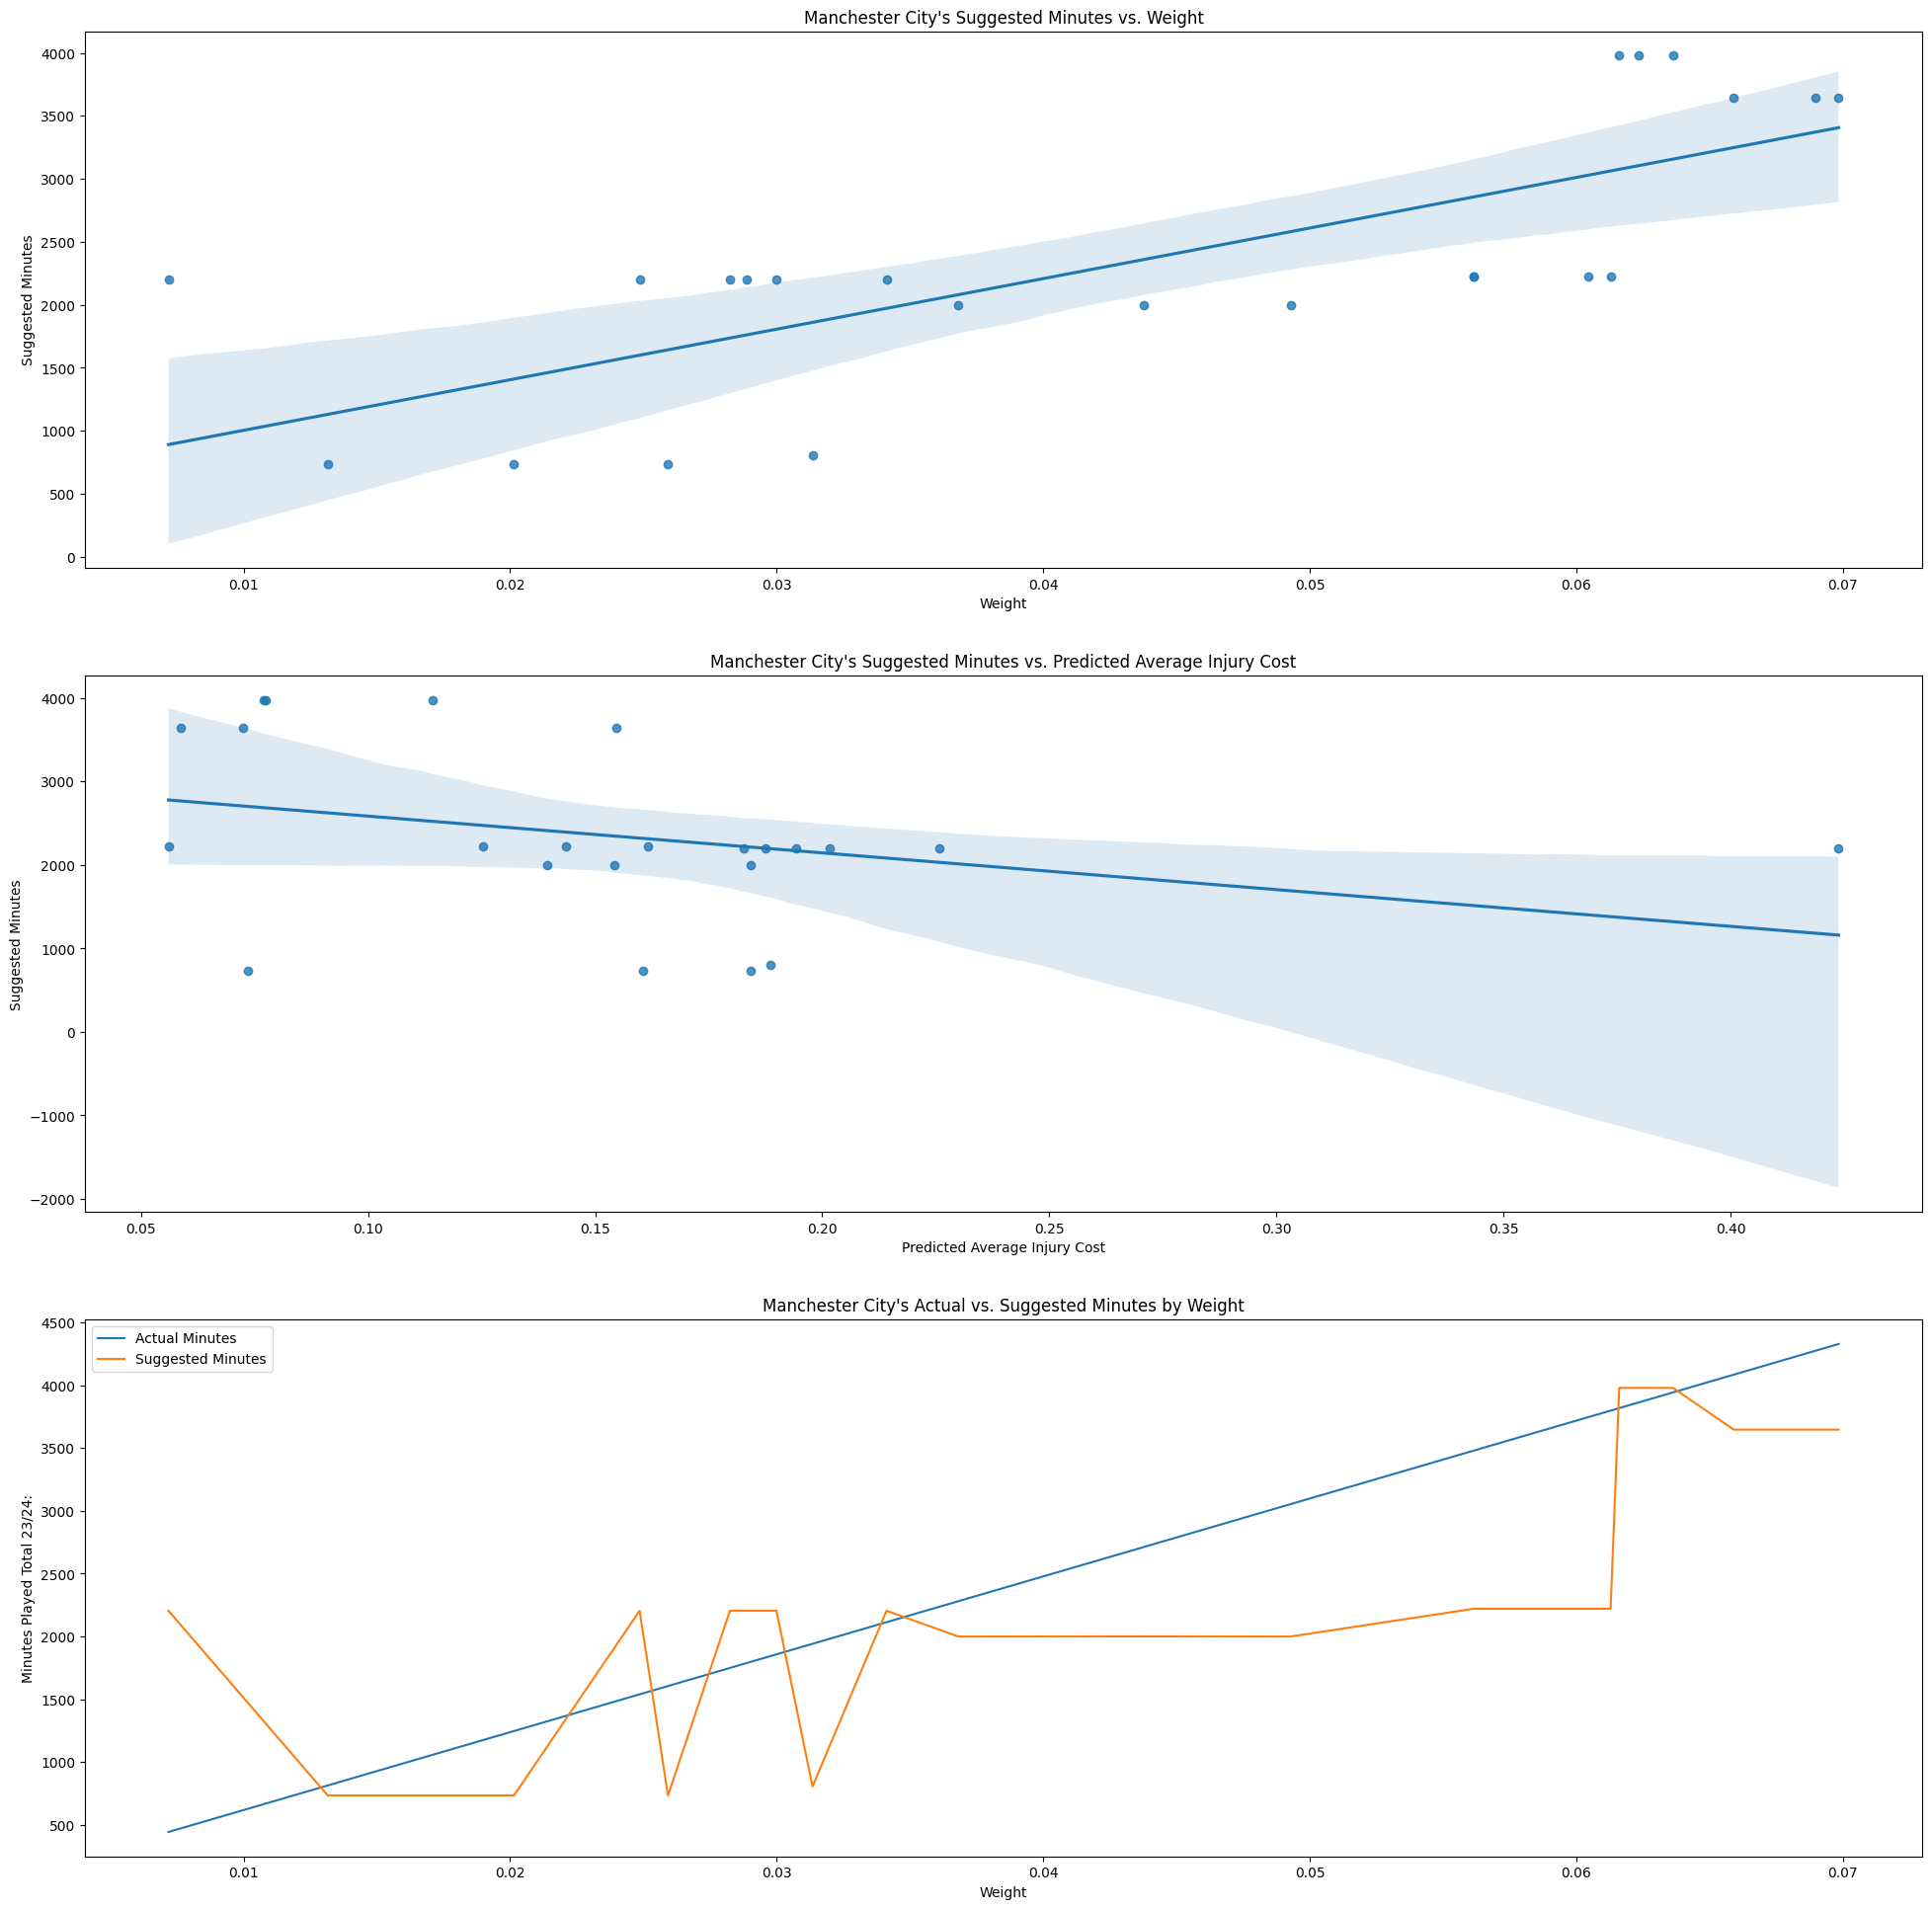

In [200]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=man_city_cost_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Manchester City's Suggested Minutes vs. Weight")

sns.regplot(data=man_city_cost_df, x='Predicted Average Injury Cost', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Manchester City's Suggested Minutes vs. Predicted Average Injury Cost")

# Create a line plot
sns.lineplot(data=man_city_cost_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=man_city_cost_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Manchester City's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Sergio Gómez's Suggested Minutes vs. Lambda")

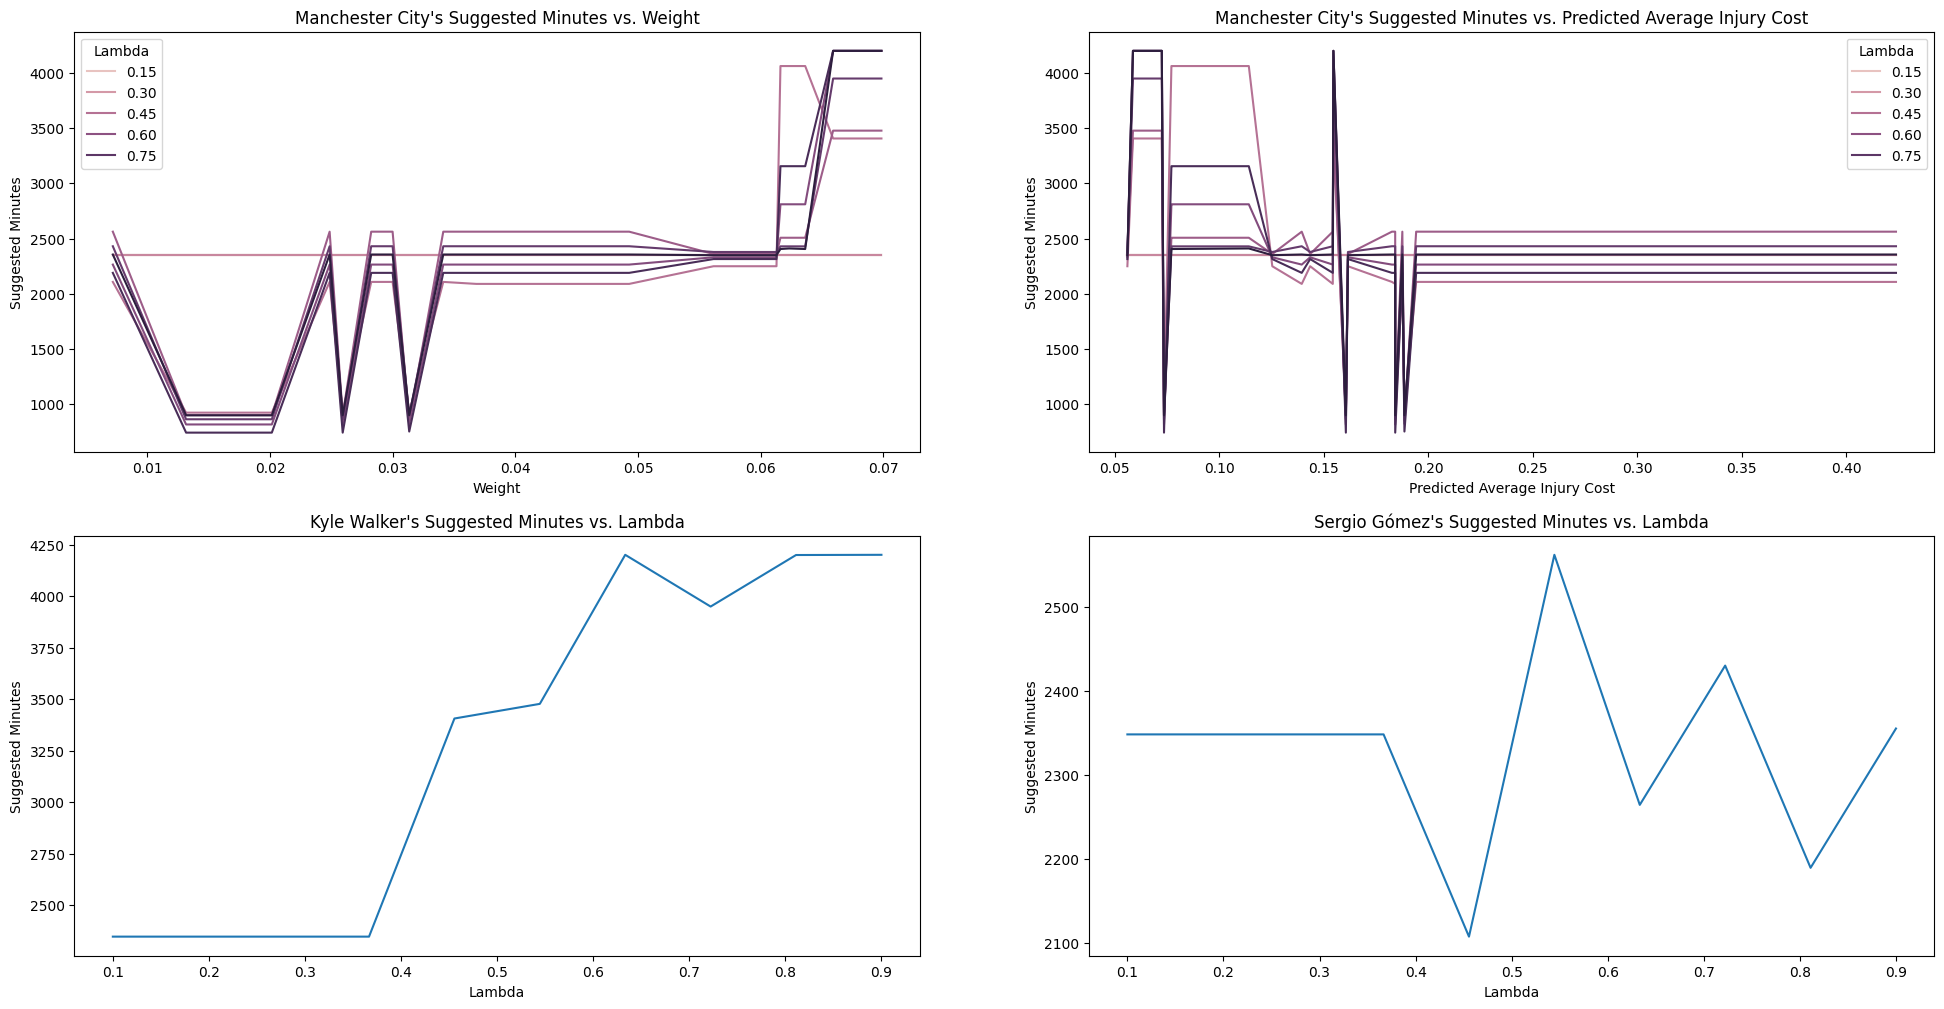

In [201]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise_cost('Man City', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Manchester City's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Average Injury Cost', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Manchester City's Suggested Minutes vs. Predicted Average Injury Cost")

walker_df = results_df[results_df['Name'] == 'Kyle Walker']
sns.lineplot(data=walker_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Kyle Walker's Suggested Minutes vs. Lambda")

sergio_df = results_df[results_df['Name'] == 'Sergio Gómez']
sns.lineplot(data=sergio_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Sergio Gómez's Suggested Minutes vs. Lambda")

In [202]:
real_madrid_cost_df = optimise_cost('Real Madrid', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=0.9)
real_madrid_cost_df

Name         Club  Age  Minutes Played Total 23/24:  \
849         Éder Militão  Real Madrid   26                          505   
850          David Alaba  Real Madrid   31                         1407   
851      Antonio Rüdiger  Real Madrid   31                         3986   
852      Nacho Fernández  Real Madrid   34                         3035   
853        Ferland Mendy  Real Madrid   28                         2744   
854          Fran García  Real Madrid   24                         1686   
855      Daniel Carvajal  Real Madrid   32                         3261   
856        Lucas Vázquez  Real Madrid   32                         1780   
857  Aurélien Tchouaméni  Real Madrid   24                         2809   
858    Federico Valverde  Real Madrid   25                         4190   
859    Eduardo Camavinga  Real Madrid   21                         2733   
860           Toni Kroos  Real Madrid   34                         3094   
861          Luka Modric  Real Madrid   38                         2238   
862        Dani Ceballos  Real Madrid   27                          862   
863      Jude Bellingham  Real Madrid   20                         3559   
864          Brahim Díaz  Real Madrid   24                         2064   
865           Arda Güler  Real Madrid   19                          440   
866             Nico Paz  Real Madrid   19                         2757   
867      Vinicius Junior  Real Madrid   23                         2994   
868              Rodrygo  Real Madrid   23                         3616   
869               Joselu  Real Madrid   34                         2090   

       Weight  Predicted Injury Count  Predicted Average Injury Cost  \
849  0.009740                1.664194                       0.191881   
850  0.027136                1.827713                       0.191089   
851  0.076876                0.849199                       0.101068   
852  0.058534                0.821950                       0.094891   
853  0.052922                1.172565                       0.140087   
854  0.032517                0.676970                       0.070525   
855  0.062893                0.910487                       0.090548   
856  0.034330                0.735942                       0.086162   
857  0.054176                0.903665                       0.111923   
858  0.080810                0.283769                       0.046067   
859  0.052710                0.681315                       0.115723   
860  0.059672                0.514180                       0.072211   
861  0.043163                0.660662                       0.111205   
862  0.016625                0.899362                       0.140736   
863  0.068640                1.285456                       0.200934   
864  0.039807                0.355489                       0.073700   
865  0.008486                1.937346                       0.293681   
866  0.053173                0.429183                       0.068575   
867  0.057743                1.408280                       0.285234   
868  0.069740                0.521449                       0.086636   
869  0.040309                0.807705                       0.139538   

     Min Playing Time  Lambda  Suggested Minutes  
849               0.0     0.9               2571  
850               0.0     0.9               2571  
851            4390.4     0.9               3976  
852            2744.0     0.9               2571  
853            2195.2     0.9               2571  
854               0.0     0.9               2571  
855            3567.2     0.9               3298  
856               0.0     0.9               2571  
857            2744.0     0.9               2571  
858            4390.4     0.9               3976  
859            2195.2     0.9               1342  
860            3567.2     0.9               3298  
861            1372.0     0.9                901  
862               0.0     0.9               2571  
863            3567

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

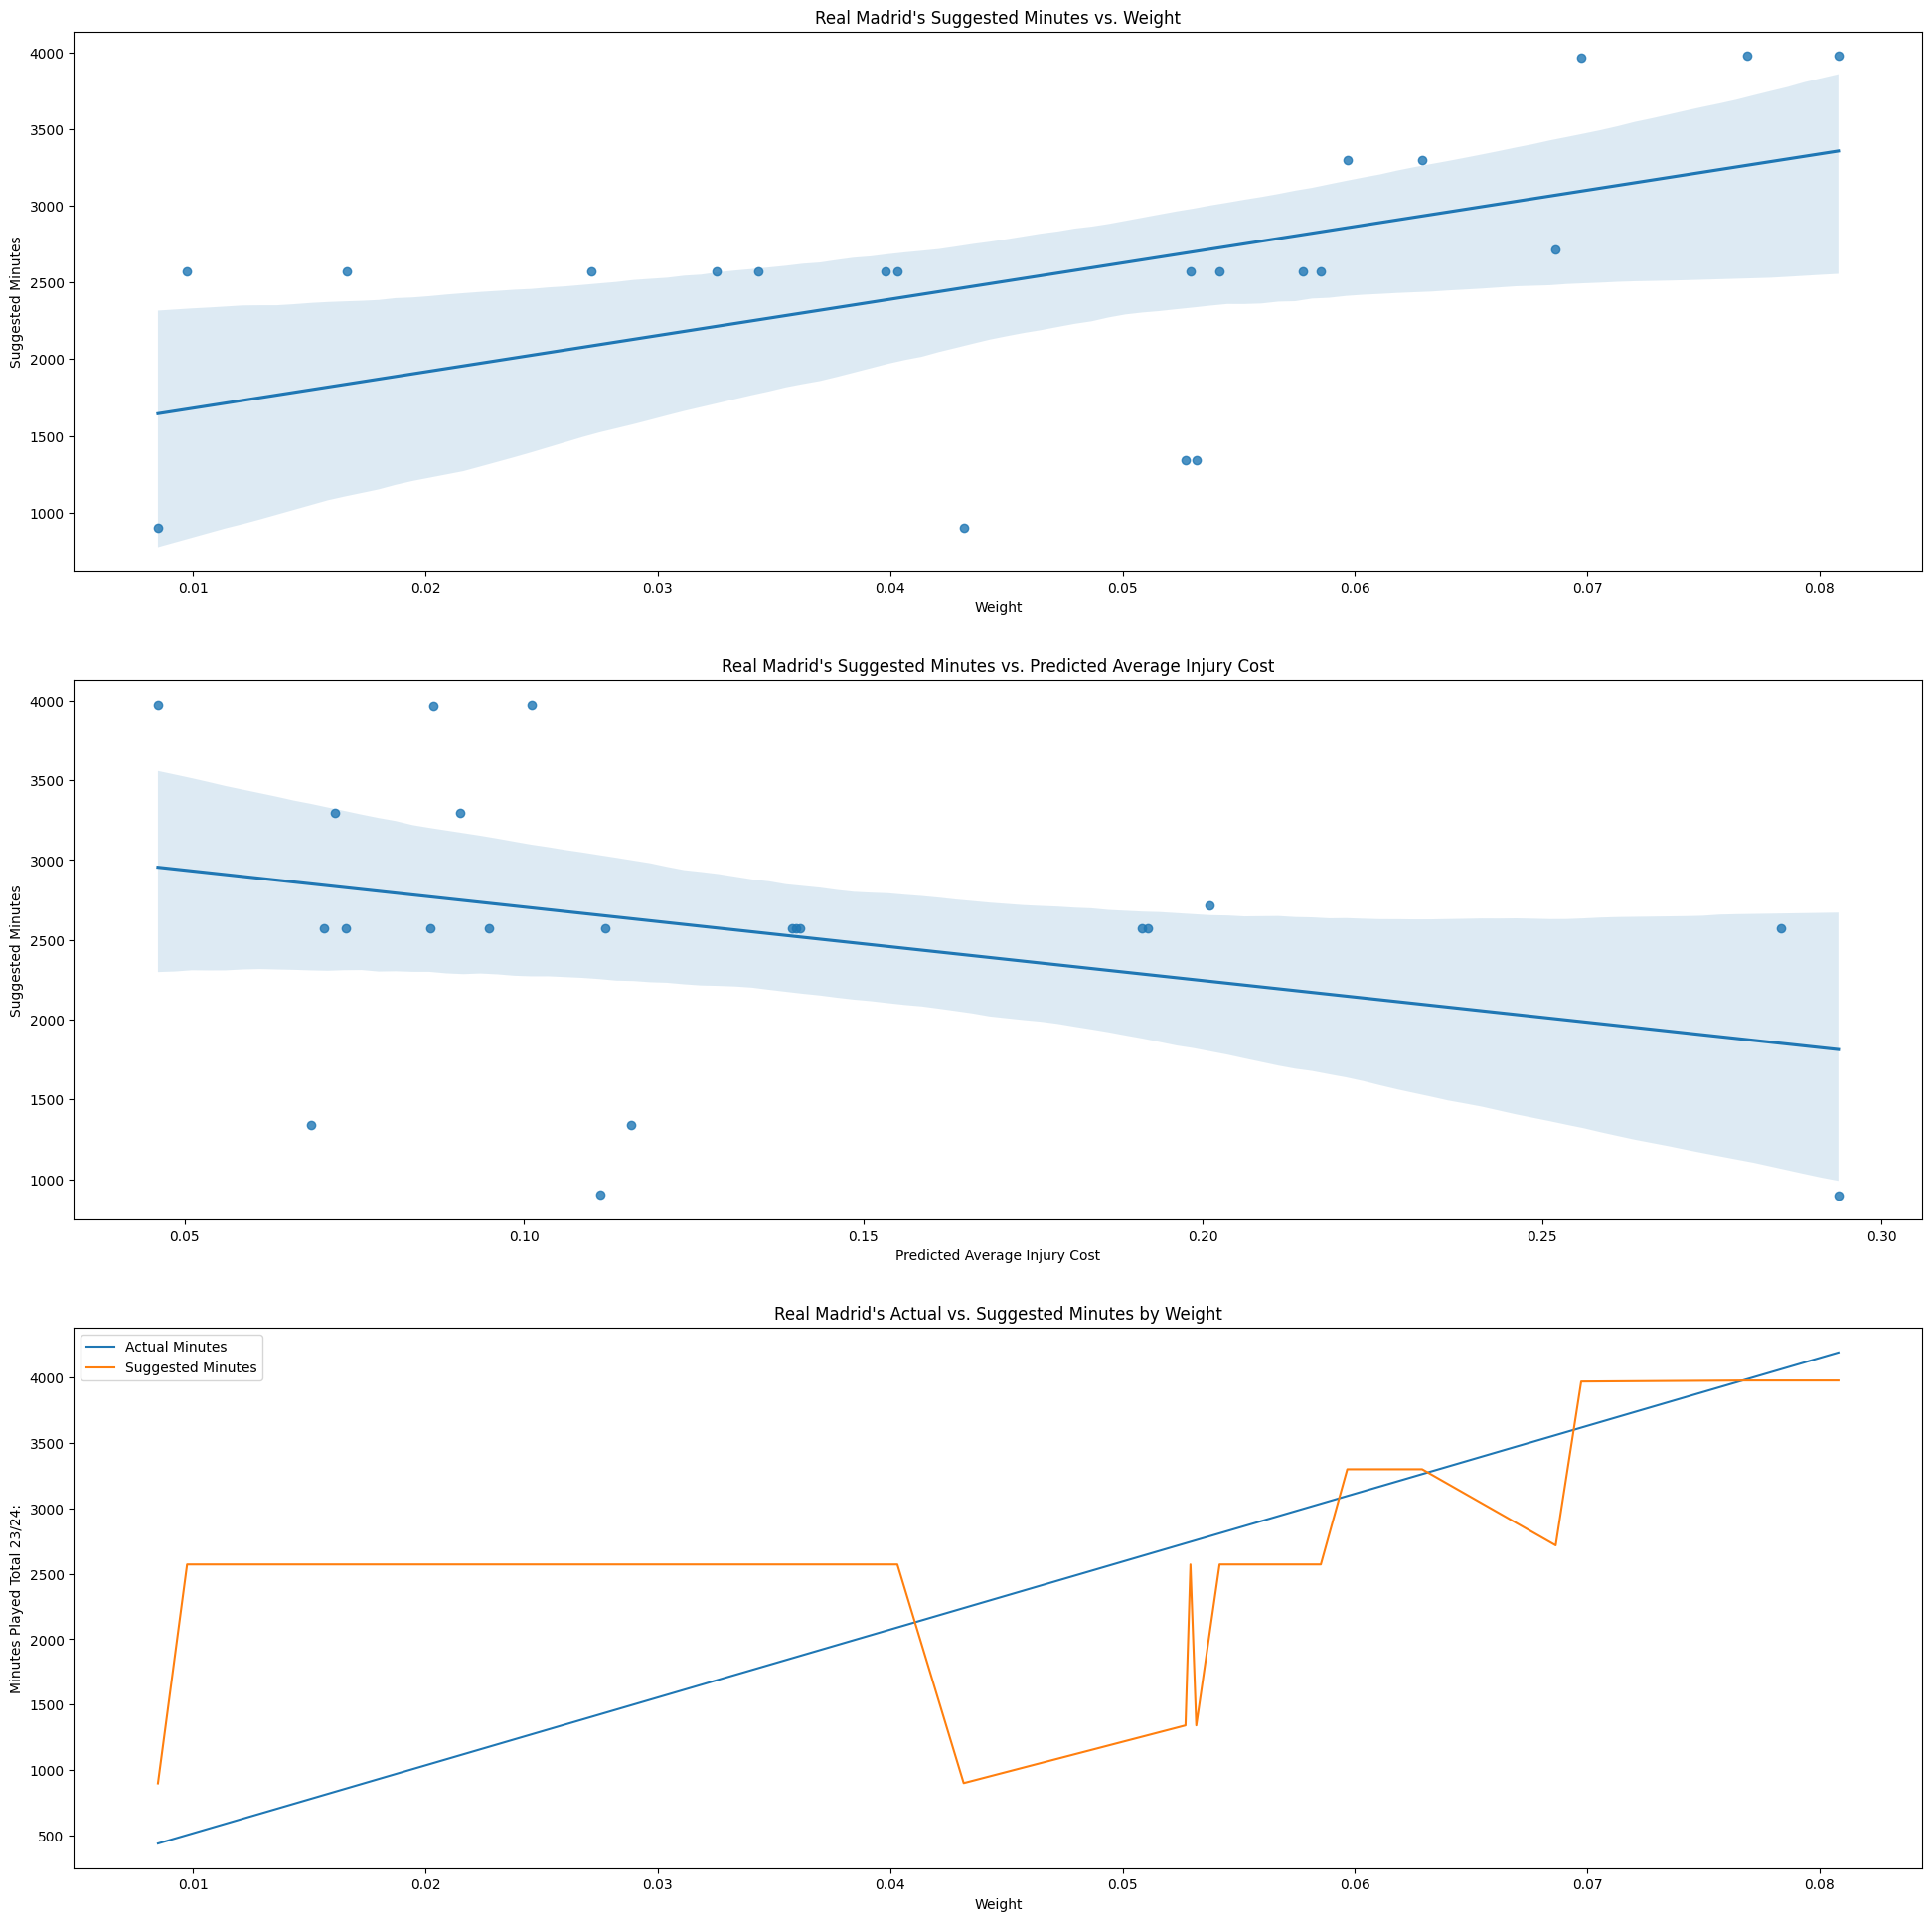

In [203]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=real_madrid_cost_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Real Madrid's Suggested Minutes vs. Weight")

sns.regplot(data=real_madrid_cost_df, x='Predicted Average Injury Cost', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Real Madrid's Suggested Minutes vs. Predicted Average Injury Cost")

# Create a line plot
sns.lineplot(data=real_madrid_cost_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=real_madrid_cost_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Real Madrid's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [204]:
real_madrid_cost_df = optimise_cost('Real Madrid', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=0.2)
real_madrid_cost_df

Name         Club  Age  Minutes Played Total 23/24:  \
849         Éder Militão  Real Madrid   26                          505   
850          David Alaba  Real Madrid   31                         1407   
851      Antonio Rüdiger  Real Madrid   31                         3986   
852      Nacho Fernández  Real Madrid   34                         3035   
853        Ferland Mendy  Real Madrid   28                         2744   
854          Fran García  Real Madrid   24                         1686   
855      Daniel Carvajal  Real Madrid   32                         3261   
856        Lucas Vázquez  Real Madrid   32                         1780   
857  Aurélien Tchouaméni  Real Madrid   24                         2809   
858    Federico Valverde  Real Madrid   25                         4190   
859    Eduardo Camavinga  Real Madrid   21                         2733   
860           Toni Kroos  Real Madrid   34                         3094   
861          Luka Modric  Real Madrid   38                         2238   
862        Dani Ceballos  Real Madrid   27                          862   
863      Jude Bellingham  Real Madrid   20                         3559   
864          Brahim Díaz  Real Madrid   24                         2064   
865           Arda Güler  Real Madrid   19                          440   
866             Nico Paz  Real Madrid   19                         2757   
867      Vinicius Junior  Real Madrid   23                         2994   
868              Rodrygo  Real Madrid   23                         3616   
869               Joselu  Real Madrid   34                         2090   

       Weight  Predicted Injury Count  Predicted Average Injury Cost  \
849  0.009740                1.664194                       0.191881   
850  0.027136                1.827713                       0.191089   
851  0.076876                0.849199                       0.101068   
852  0.058534                0.821950                       0.094891   
853  0.052922                1.172565                       0.140087   
854  0.032517                0.676970                       0.070525   
855  0.062893                0.910487                       0.090548   
856  0.034330                0.735942                       0.086162   
857  0.054176                0.903665                       0.111923   
858  0.080810                0.283769                       0.046067   
859  0.052710                0.681315                       0.115723   
860  0.059672                0.514180                       0.072211   
861  0.043163                0.660662                       0.111205   
862  0.016625                0.899362                       0.140736   
863  0.068640                1.285456                       0.200934   
864  0.039807                0.355489                       0.073700   
865  0.008486                1.937346                       0.293681   
866  0.053173                0.429183                       0.068575   
867  0.057743                1.408280                       0.285234   
868  0.069740                0.521449                       0.086636   
869  0.040309                0.807705                       0.139538   

     Min Playing Time  Lambda  Suggested Minutes  
849               0.0     0.2               2242  
850               0.0     0.2               2242  
851            4390.4     0.2               4162  
852            2744.0     0.2               2467  
853            2195.2     0.2               2234  
854               0.0     0.2               2242  
855            3567.2     0.2               3507  
856               0.0     0.2               2242  
857            2744.0     0.2               2513  
858            4390.4     0.2               4162  
859            2195.2     0.2               1912  
860            3567.2     0.2               3507  
861            1372.0     0.2               1092  
862               0.0     0.2               2242  
863            3567

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

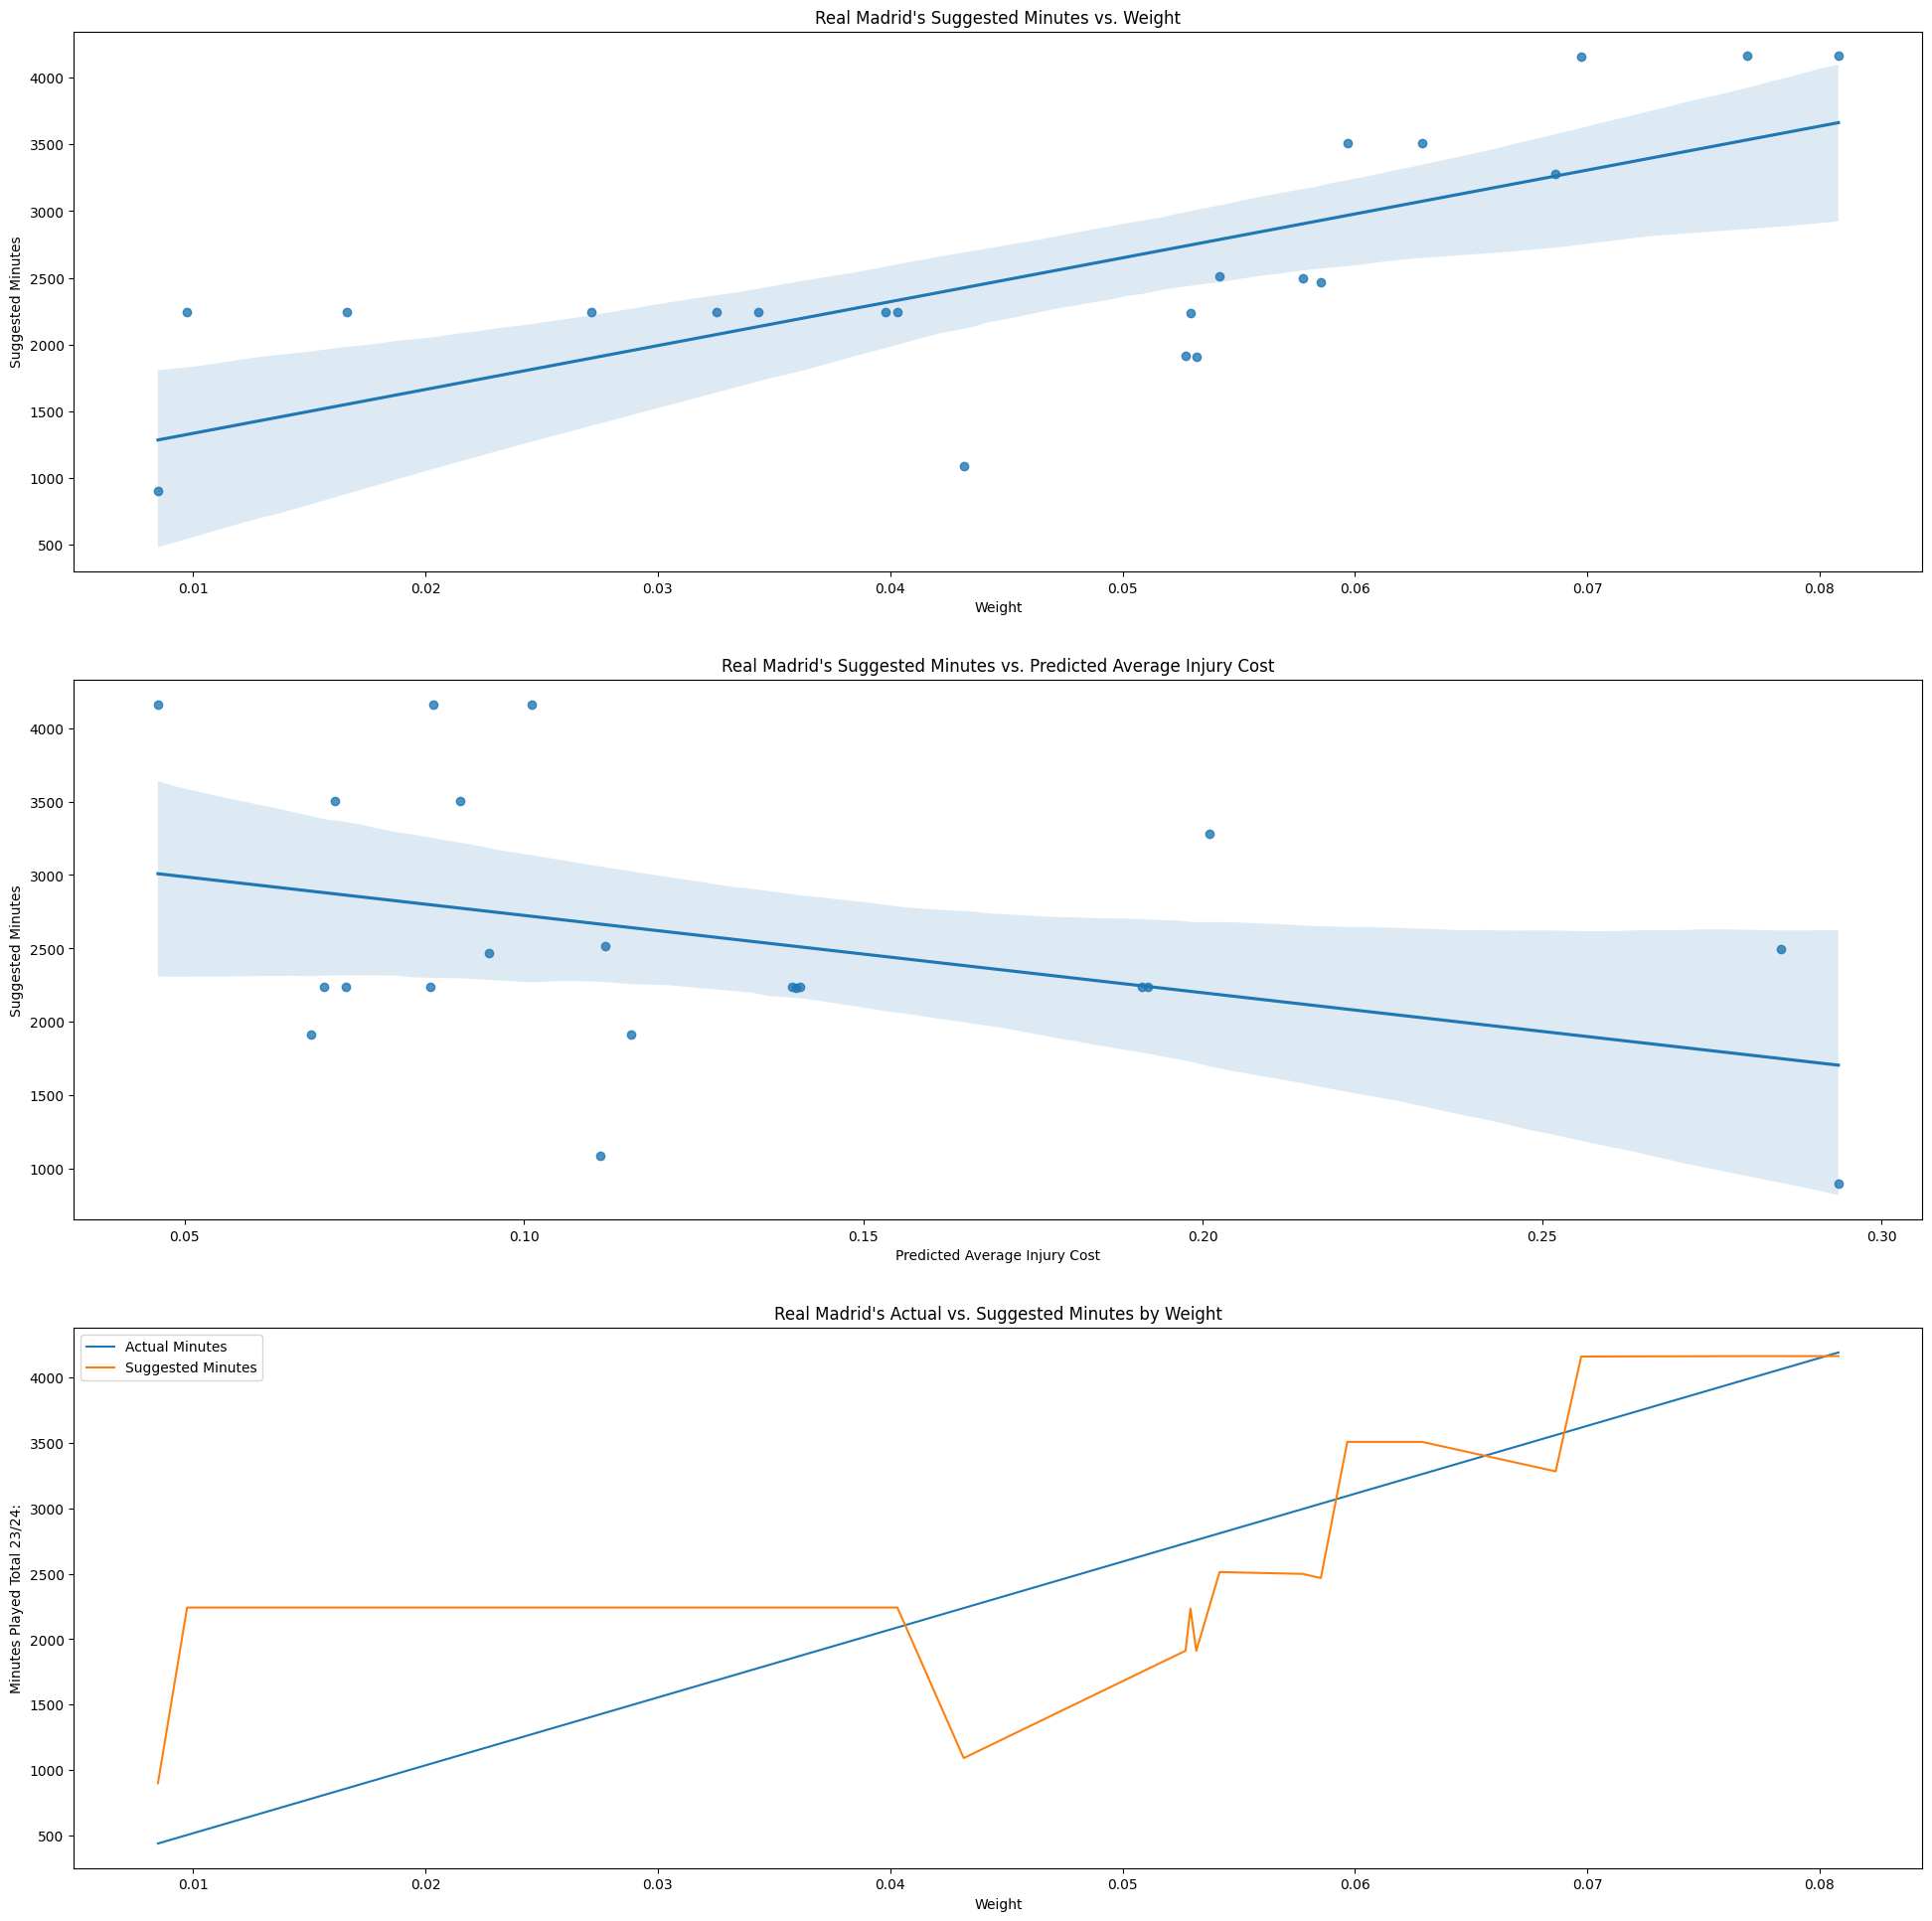

In [205]:
# Create separate line charts
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
# Plot suggested minutes vs. weights
sns.regplot(data=real_madrid_cost_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Real Madrid's Suggested Minutes vs. Weight")

sns.regplot(data=real_madrid_cost_df, x='Predicted Average Injury Cost', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Real Madrid's Suggested Minutes vs. Predicted Average Injury Cost")

# Create a line plot
sns.lineplot(data=real_madrid_cost_df, x='Weight', y='Minutes Played Total 23/24:', label='Actual Minutes', ax=axes[2])
sns.lineplot(data=real_madrid_cost_df, x='Weight', y='Suggested Minutes', label='Suggested Minutes', ax=axes[2])

# Set plot title and labels
ax=axes[2].set_title("Real Madrid's Actual vs. Suggested Minutes by Weight")

# Add legend
plt.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Guler's Suggested Minutes vs. Lambda")

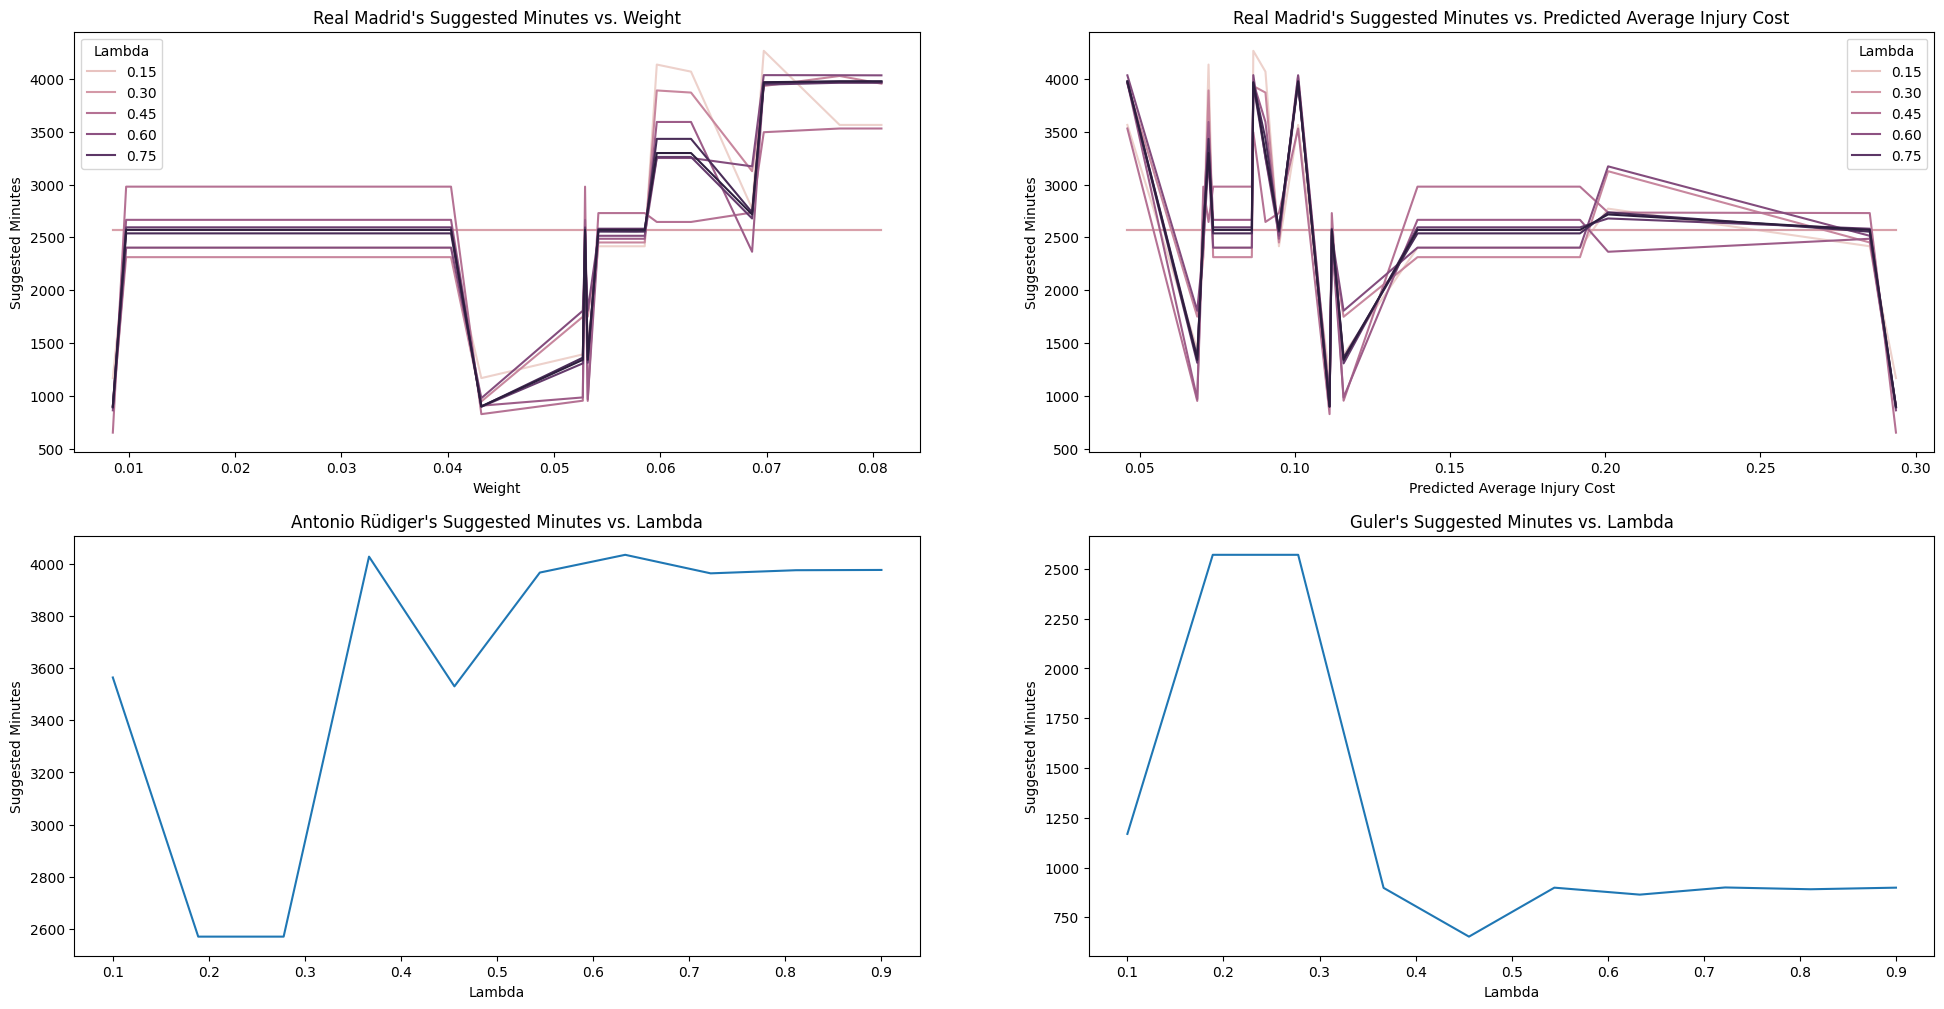

In [206]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise_cost('Real Madrid', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Real Madrid's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Average Injury Cost', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Real Madrid's Suggested Minutes vs. Predicted Average Injury Cost")

rudiger_df = results_df[results_df['Name'] == 'Antonio Rüdiger']
sns.lineplot(data=rudiger_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Antonio Rüdiger's Suggested Minutes vs. Lambda")

guler_df = results_df[results_df['Name'] == 'Arda Güler']
sns.lineplot(data=guler_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Guler's Suggested Minutes vs. Lambda")